# ***NOTEBOOK FOR ANALYSING THE `SYNTHEA` DATA***
***
- ***GOAL IS TO FIND STRONG REASONS BEHIND PATIENTS READMISSION***

## **Starting of Analysis**

### ***Data Import, Creating Connection and Checking the data***

In [1]:
import os
from pathlib import Path

def get_project_root(project_name="portfolio_projects"):
    """
    Universally finds the project root.
    1. Checks if we are inside the project (standard usage).
    2. Checks if we are above the project (your specific usage).
    """
    current_path = Path.cwd()

    # CASE 1: Standard Usage (Running from inside the repo)
    if project_name in str(current_path):
        while current_path.name != project_name:
            current_path = current_path.parent
        return current_path

    # CASE 2: Your Setup (Running from 'Machine' or a parent folder)
    # We search specifically for the project folder inside the current directory
    # limiting depth to 4 levels to keep it fast.
    else:
        # rglob searches recursively for the folder name
        for path in current_path.rglob(project_name):
            if path.is_dir():
                return path
        
        raise FileNotFoundError(f"Could not find project: {project_name}")

# --- USAGE ---
repo_root = get_project_root()

data_path = repo_root / "about_synthea_patient_readmission"
print(data_path)

C:\Users\Rano's PC\Machine\PORTFOLIO_PROJECTS\about_synthea_patient_readmission


In [2]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys, os
sys.path.append(os.path.abspath(f"{data_path}"))

import src.plots as P
import src.stat_tests as S

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
# The Correct Way (Universal)
file_path = data_path / "dataset" / "processed_data" / "processed_synthea_data.csv"

data = pd.read_csv(file_path)

In [5]:
pd.set_option('display.max_columns',None)

In [6]:
data.head()

encounterclass  encounter_duration  total_procedures  avg_procedure_cost  \
0       WELLNESS                30.0                 1              648.01   
1       WELLNESS                15.0                 0                0.00   
2     AMBULATORY                30.0                 1             2230.40   
3     AMBULATORY                15.0                 0                0.00   
4       WELLNESS                30.0                 1              590.58   

   total_medicines  avg_base_medicine_cost  avg_total_medicine_cost  \
0                0                    0.00                     0.00   
1                0                    0.00                     0.00   
2                0                    0.00                     0.00   
3                1                   20.48                    20.48   
4                0                    0.00                     0.00   

   reasons_for_medications is_ongoing_condition  total_conditions  \
0                        0         NO CONDITION                 0   
1                        0         NO CONDITION                 0   
2                        0                   NO                 1   
3                        1                   NO                 1   
4                        0         NO CONDITION                 0   

  is_ongoing_careplan  total_careplans  age_as_2022  marital   race  \
0         NO CAREPLAN                0           18  UNKNOWN  WHITE   
1         NO CAREPLAN                0           18  UNKNOWN  WHITE   
2         NO CAREPLAN                0           18  UNKNOWN  WHITE   
3         NO CAREPLAN                0           18  UNKNOWN  WHITE   
4         NO CAREPLAN                0           18  UNKNOWN  WHITE   

     ethnicity patient_gender provider_gender  utilization caused_readmission  \
0  NONHISPANIC              M               M           25                 NO   
1  NONHISPANIC              M               M           25                 NO   
2  NONHISPANIC              M               M         1616                 NO   
3  NONHISPANIC              M               M         1616                 NO   
4  NONHISPANIC              M               M           25                 NO   

   condition_duration  careplan_duration  visit_number  coverage_ratio  \
0                   0                  0             1            1.00   
1                   0                  0             2            1.00   
2                   9                  0             3            0.42   
3                  12                  0             4            0.42   
4                   0                  0             5            1.00   

   medication_duration  procedures_per_hour  
0                    0                  1.0  
1                    0                  0.0  
2                    0                  1.0  
3                   12                  0.0  
4                    0                  1.0

### ***Initial Data Health Check***

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53346 entries, 0 to 53345
Data columns (total 26 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   encounterclass           53346 non-null  object 
 1   encounter_duration       53346 non-null  float64
 2   total_procedures         53346 non-null  int64  
 3   avg_procedure_cost       53346 non-null  float64
 4   total_medicines          53346 non-null  int64  
 5   avg_base_medicine_cost   53346 non-null  float64
 6   avg_total_medicine_cost  53346 non-null  float64
 7   reasons_for_medications  53346 non-null  int64  
 8   is_ongoing_condition     53346 non-null  object 
 9   total_conditions         53346 non-null  int64  
 10  is_ongoing_careplan      53346 non-null  object 
 11  total_careplans          53346 non-null  int64  
 12  age_as_2022              53346 non-null  int64  
 13  marital                  53346 non-null  object 
 14  race                  

In [8]:
rows,columns = data.shape
print(f"Rows -> {rows}")
print(f"Columns -> {columns}")

Rows -> 53346
Columns -> 26


In [9]:
data.isnull().sum()[data.isnull().sum()>0].reset_index(name = 'null_counts')

Empty DataFrame
Columns: [index, null_counts]
Index: []

In [10]:
data.duplicated().sum()

np.int64(127)

- ***there are `duplicated` values***

In [11]:
data.describe().round(2).T

count      mean        std   min    25%     50%  \
encounter_duration       53346.0  31489.33  835605.88  15.0  15.00   27.00   
total_procedures         53346.0      0.66       1.70   0.0   0.00    0.00   
avg_procedure_cost       53346.0   2129.45    5596.18   0.0   0.00    0.00   
total_medicines          53346.0      0.80       1.20   0.0   0.00    1.00   
avg_base_medicine_cost   53346.0    162.61     406.75   0.0   0.00    6.80   
avg_total_medicine_cost  53346.0   1431.68    9931.92   0.0   0.00    7.22   
reasons_for_medications  53346.0      0.50       0.61   0.0   0.00    0.00   
total_conditions         53346.0      0.16       0.41   0.0   0.00    0.00   
total_careplans          53346.0      0.07       0.25   0.0   0.00    0.00   
age_as_2022              53346.0     55.66      25.87   0.0  35.00   58.00   
utilization              53346.0   1329.70    1427.73   1.0  86.00  821.00   
condition_duration       53346.0      7.54     156.39   0.0   0.00    0.00   
careplan_duration        53346.0      7.11     117.53   0.0   0.00    0.00   
visit_number             53346.0    127.88     300.86   1.0  12.00   30.00   
coverage_ratio           53346.0      0.48       0.34   0.0   0.23    0.54   
medication_duration      53346.0    122.99     443.13   0.0   0.00    0.00   
procedures_per_hour      53346.0      0.45       0.75   0.0   0.00    0.00   

                             75%          max  
encounter_duration         45.00  45964800.00  
total_procedures            1.00        21.00  
avg_procedure_cost        602.04    187968.69  
total_medicines             1.00        10.00  
avg_base_medicine_cost    263.49      6901.17  
avg_total_medicine_cost  1783.74   1296594.95  
reasons_for_medications     1.00         4.00  
total_conditions            0.00         7.00  
total_careplans             0.00         2.00  
age_as_2022                73.00       112.00  
utilization              2159.00      4828.00  
condition_duration          0.00     17947.00  
careplan_duration           0.00     10204.00  
visit_number               69.00      2006.00  
coverage_ratio              0.69         1.00  
medication_duration       361.00     24091.00  
procedures_per_hour         1.00         4.00

***Knowledge from Initial Health Check:***

- There is scenario where `age is 0`, need to check that

In [12]:
data[data['age_as_2022'] ==0]

encounterclass  encounter_duration  total_procedures  \
12642       WELLNESS                15.0                 0   
12643      EMERGENCY               144.0                 2   
12644       WELLNESS                30.0                 1   
12645      EMERGENCY               209.0                 1   
12646       WELLNESS                30.0                 1   
12647      EMERGENCY               138.0                 1   
12648       WELLNESS                30.0                 1   
12649     OUTPATIENT                15.0                 0   
12650       WELLNESS                15.0                 0   
12651       WELLNESS                15.0                 0   
21660       WELLNESS                15.0                 0   
21661       WELLNESS                15.0                 0   
21662       WELLNESS                30.0                 1   
21663       WELLNESS                30.0                 1   
21664       WELLNESS                15.0                 0   
21665       WELLNESS                15.0                 0   
21666      EMERGENCY                60.0                 0   

       avg_procedure_cost  total_medicines  avg_base_medicine_cost  \
12642                0.00                0                    0.00   
12643             8767.99                1                  158.21   
12644              705.72                0                    0.00   
12645            11712.93                1                  892.68   
12646              597.26                0                    0.00   
12647            13533.45                0                    0.00   
12648              458.61                0                    0.00   
12649                0.00                2                   13.78   
12650                0.00                0                    0.00   
12651                0.00                0                    0.00   
21660                0.00                0                    0.00   
21661                0.00                0                    0.00   
21662              348.31                0                    0.00   
21663              747.64                0                    0.00   
21664                0.00                0                    0.00   
21665                0.00                0                    0.00   
21666                0.00                0                    0.00   

       avg_total_medicine_cost  reasons_for_medications is_ongoing_condition  \
12642                     0.00                        0         NO CONDITION   
12643                  1423.89                        0                  YES   
12644                     0.00                        0         NO CONDITION   
12645                  7141.44                        0         NO CONDITION   
12646                     0.00                        0         NO CONDITION   
12647                     0.00                        0         NO CONDITION   
12648                     0.00                        0         NO CONDITION   
12649                    13.78                        0                   NO   
12650                     0.00                        0         NO CONDITION   
12651                     0.00                        0         NO CONDITION   
21660                     0.00                        0         NO CONDITION   
21661                     0.00                        0         NO CONDITION   
21662                     0.00                        0         NO CONDITION   
21663                     0.00                        0         NO CONDITION   
21664                     0.00                        0         NO CONDITION   
21665                     0.00                        0         NO CONDITION   
21666                     0.00                        0                  YES   

       total_conditions is_ongoing_careplan  total_careplans  age_as_2022  \
12642                 0         NO CAREPLAN                0            0   
12643                 2         N

- ***These 17 age values are actually patients who born in 2022 so it is showing age as 0, I can impute them with 1***

In [13]:
data['age_as_2022']=data['age_as_2022'].apply(lambda x: 1 if x==0 else x)

In [14]:
data['age_as_2022'].describe().round(2).reset_index()

index  age_as_2022
0  count     53346.00
1   mean        55.66
2    std        25.87
3    min         1.00
4    25%        35.00
5    50%        58.00
6    75%        73.00
7    max       112.00

In [15]:
data[data.duplicated()]

encounterclass  encounter_duration  total_procedures  \
7458        WELLNESS                15.0                 0   
8381        WELLNESS                15.0                 0   
8513        WELLNESS                15.0                 0   
8514        WELLNESS                15.0                 0   
8515        WELLNESS                15.0                 0   
...              ...                 ...               ...   
52409       WELLNESS                15.0                 0   
52578       WELLNESS                15.0                 0   
52857       WELLNESS                15.0                 0   
52860       WELLNESS                15.0                 0   
52870       WELLNESS                15.0                 0   

       avg_procedure_cost  total_medicines  avg_base_medicine_cost  \
7458                  0.0                0                     0.0   
8381                  0.0                0                     0.0   
8513                  0.0                0                     0.0   
8514                  0.0                0                     0.0   
8515                  0.0                0                     0.0   
...                   ...              ...                     ...   
52409                 0.0                0                     0.0   
52578                 0.0                0                     0.0   
52857                 0.0                0                     0.0   
52860                 0.0                0                     0.0   
52870                 0.0                0                     0.0   

       avg_total_medicine_cost  reasons_for_medications is_ongoing_condition  \
7458                       0.0                        0         NO CONDITION   
8381                       0.0                        0         NO CONDITION   
8513                       0.0                        0         NO CONDITION   
8514                       0.0                        0         NO CONDITION   
8515                       0.0                        0         NO CONDITION   
...                        ...                      ...                  ...   
52409                      0.0                        0         NO CONDITION   
52578                      0.0                        0         NO CONDITION   
52857                      0.0                        0         NO CONDITION   
52860                      0.0                        0         NO CONDITION   
52870                      0.0                        0         NO CONDITION   

       total_conditions is_ongoing_careplan  total_careplans  age_as_2022  \
7458                  0         NO CAREPLAN                0           18   
8381                  0         NO CAREPLAN                0           12   
8513                  0         NO CAREPLAN                0            7   
8514                  0         NO CAREPLAN                0            7   
8515                  0         NO CAREPLAN                0            7   
...                 ...                 ...              ...          ...   
52409                 0         NO CAREPLAN                0           50   
52578                 0         NO CAREPLAN                0           40   
52857                 0         NO CAREPLAN                0           13   
52860                 0         NO CAREPLAN                0           13   
52870                 0         NO CAREPLAN                0           13   

       marital   race    ethnicity patient_gender provider_gender  \
7458   UNKNOWN  WHITE  NONHISPANIC              M               M   
8381   UNKNOWN  WHITE  NONHISPANIC              M               F   
8513   UNKNOWN  WHITE  NONHISPANIC              F               F   
8514   UNKNOWN  WHITE  NONHISPANIC              F               F   
8515   UNKNOWN  WHITE  NONHISPANIC              F               F   
...        ...    ...          ...            ...             ...   
52409  MARRIED  WHITE  NONHISPANIC              F  

- ***There are 64 duplicate values, as there is no primary key - duplicates may not be actually duplicate, it can be different entries with same values, so I am keeping them***

In [16]:
data.select_dtypes(include='object').describe().T

count unique           top   freq
encounterclass        53346      6      WELLNESS  19106
is_ongoing_condition  53346      3  NO CONDITION  45696
is_ongoing_careplan   53346      3   NO CAREPLAN  49874
marital               53346      3       MARRIED  30413
race                  53346      5         WHITE  41794
ethnicity             53346      2   NONHISPANIC  49267
patient_gender        53346      2             F  26891
provider_gender       53346      2             F  31135
caused_readmission    53346      2            NO  32361

### ***Univariate Analysis***

**encounterclass**

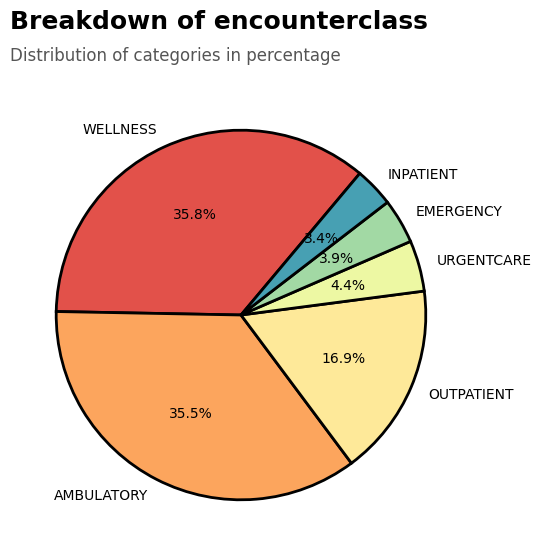

In [17]:
plt.figure(figsize=(6,6))
P.plot_pie('encounterclass',data)

- ***`Ambulatory` and `Wellness` have the most occurances among `6 different classes`***

**encounter_duration**

In [18]:
data['encounter_duration'].describe().round(2).reset_index()

index  encounter_duration
0  count            53346.00
1   mean            31489.33
2    std           835605.88
3    min               15.00
4    25%               15.00
5    50%               27.00
6    75%               45.00
7    max         45964800.00

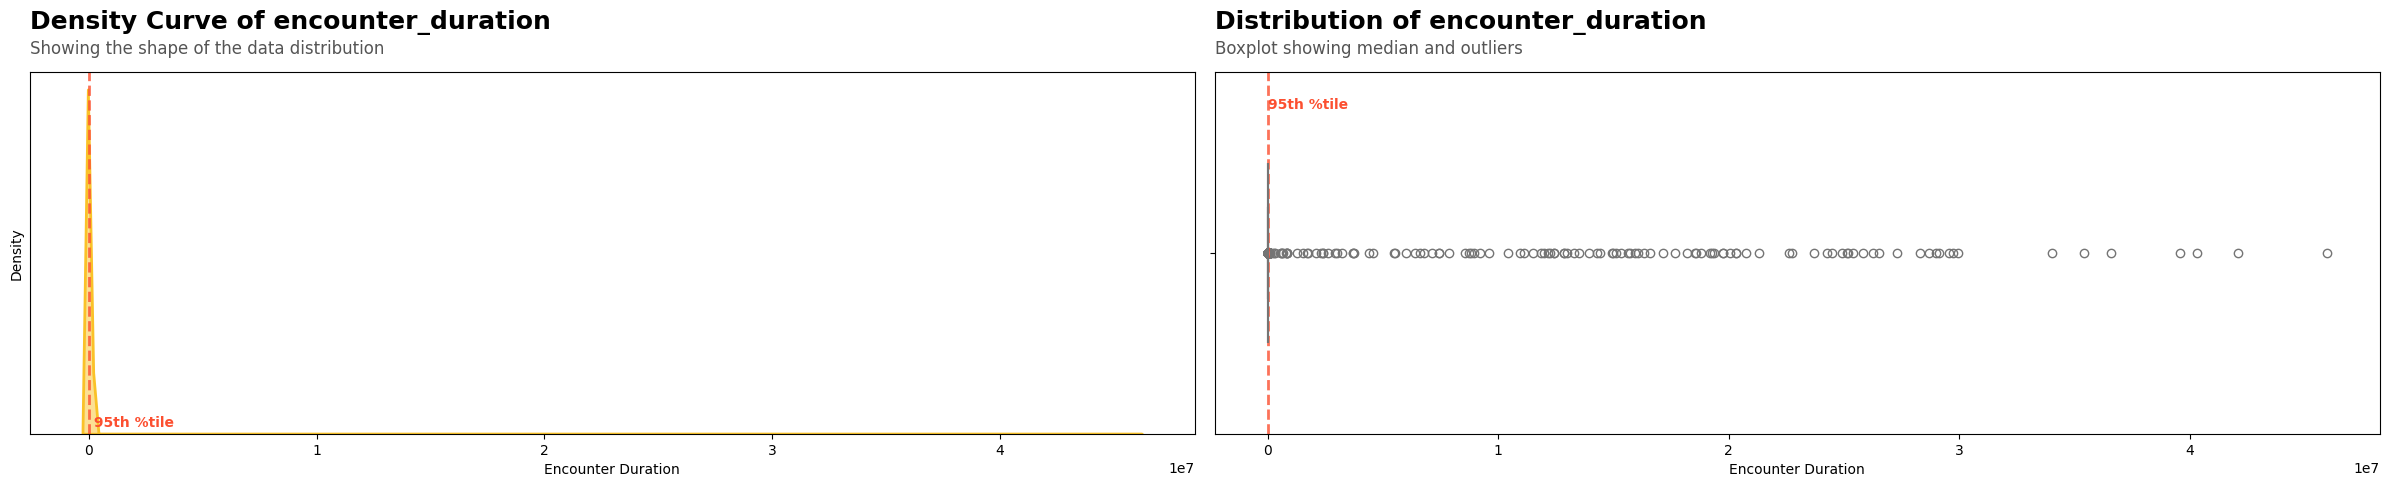

In [21]:
plt.figure(figsize=(24,5))
plt.subplot(1,2,1)
P.plot_kde('encounter_duration',data)
plt.subplot(1,2,2)
P.plot_box('encounter_duration',data)
plt.tight_layout()
plt.show()


In [22]:
data['encounter_duration'].skew().round(2)

np.float64(32.33)

- ***Encounter duration is skewed towards right, `skewness = ~24`***

**total_procedures**

In [23]:
data['total_procedures'].describe().round(2).reset_index()

index  total_procedures
0  count          53346.00
1   mean              0.66
2    std              1.70
3    min              0.00
4    25%              0.00
5    50%              0.00
6    75%              1.00
7    max             21.00

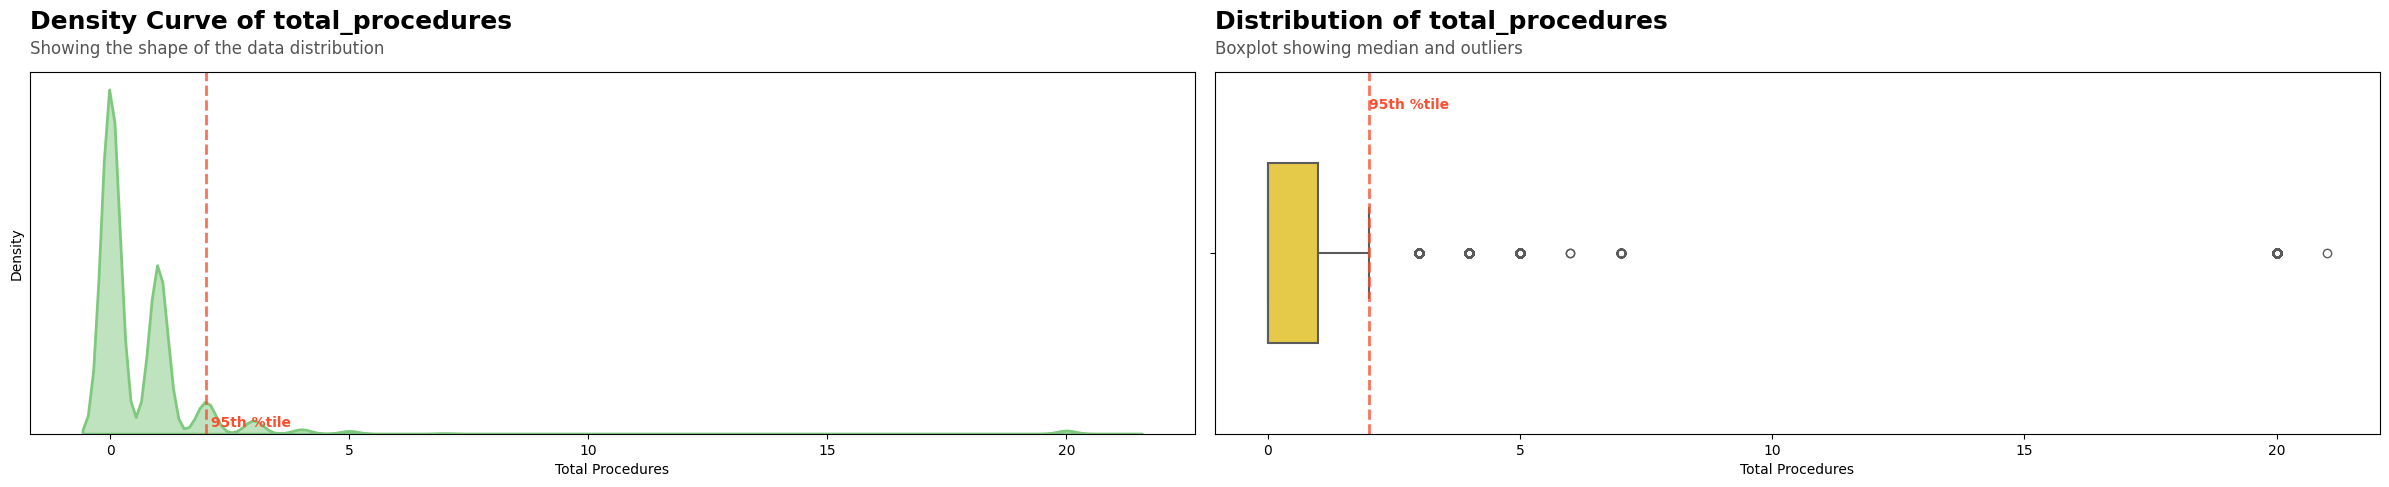

In [24]:
plt.figure(figsize=(24,5))
plt.subplot(1,2,1)
P.plot_kde('total_procedures',data)
plt.subplot(1,2,2)
P.plot_box('total_procedures',data)
plt.tight_layout()
plt.show()


In [25]:
data['total_procedures'].value_counts().div(len(data)).mul(100).round(2).reset_index(name = 'percentage')

total_procedures  percentage
0                 0       60.50
1                 1       29.59
2                 2        5.62
3                 3        2.35
4                 4        0.78
5                20        0.57
6                 5        0.49
7                 7        0.08
8                 6        0.00
9                21        0.00

In [26]:
bins = [-1, 0, 1, 100]
labels = ['NONE', 'SINGLE', 'MULTIPLE']
data['total_procedures'] = pd.cut(data['total_procedures'], bins=bins, labels=labels)

In [27]:
data['total_procedures'].value_counts().div(len(data)).mul(100).round(2).reset_index(name = 'percentage')

total_procedures  percentage
0             NONE       60.50
1           SINGLE       29.59
2         MULTIPLE        9.91

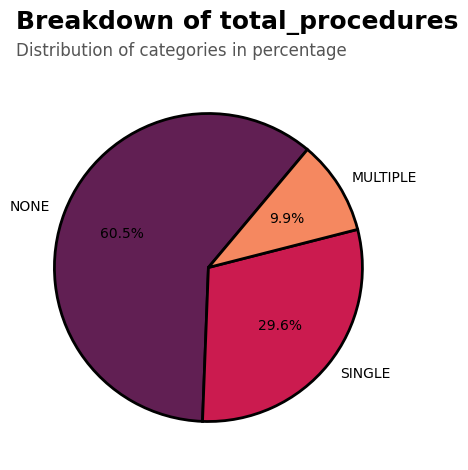

In [28]:
plt.figure(figsize=(24,5))
P.plot_pie('total_procedures',data)

- ***Changed the type of `total_procedures` - most of the observations have `none procedures` `~60% of overall observations`***

**avg_procedure_cost**

In [29]:
data['avg_procedure_cost'].describe().round(2).reset_index()

index  avg_procedure_cost
0  count            53346.00
1   mean             2129.45
2    std             5596.18
3    min                0.00
4    25%                0.00
5    50%                0.00
6    75%              602.04
7    max           187968.69

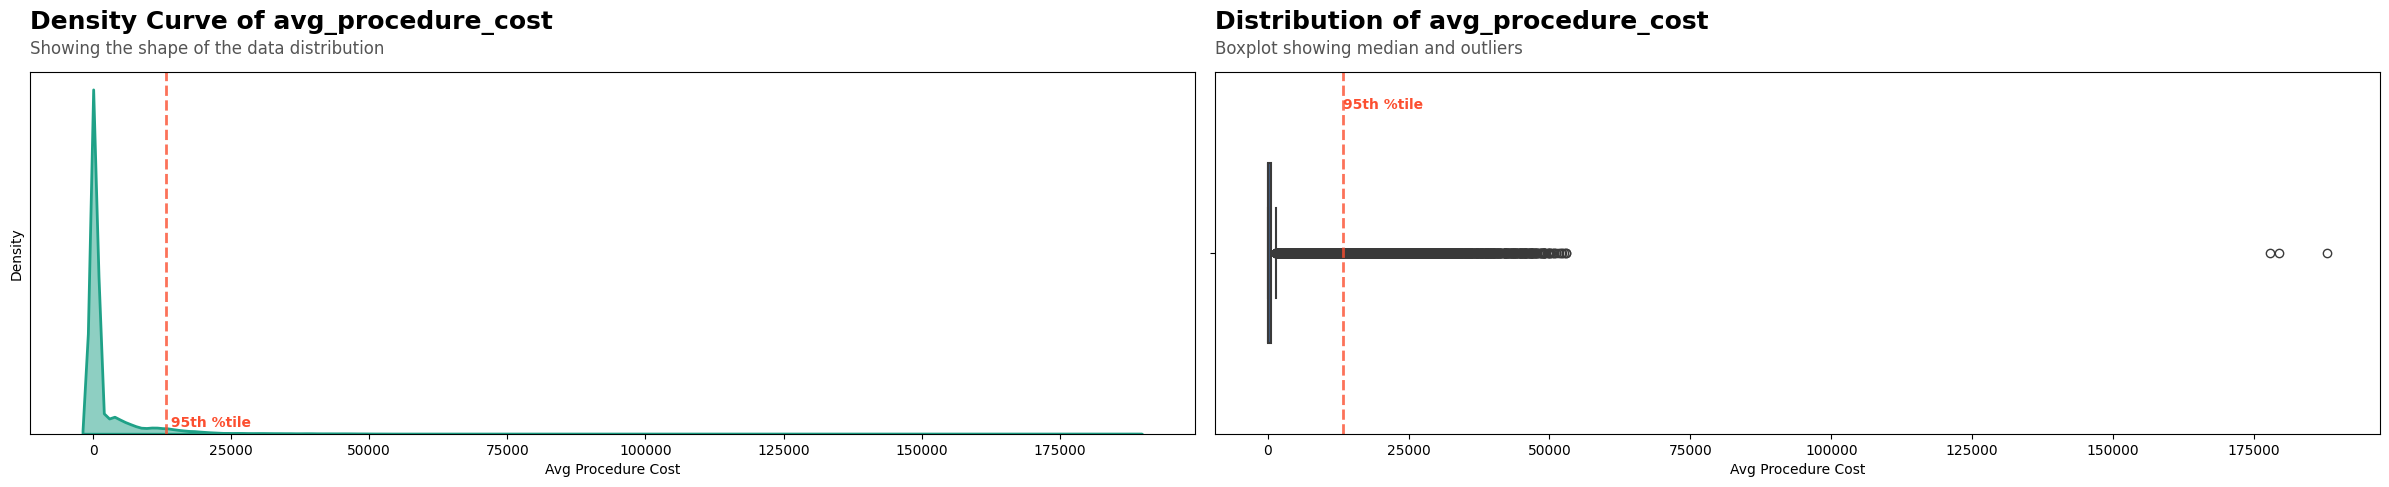

In [30]:
plt.figure(figsize=(24,5))
plt.subplot(1,2,1)
P.plot_kde('avg_procedure_cost',data)
plt.subplot(1,2,2)
P.plot_box('avg_procedure_cost',data)
plt.tight_layout()
plt.show()


In [31]:
data[data['avg_procedure_cost']> 75000]

encounterclass  encounter_duration total_procedures  avg_procedure_cost  \
3214      INPATIENT              1800.0           SINGLE           187968.69   
4447      INPATIENT              1800.0           SINGLE           177834.83   
9318      INPATIENT              1740.0           SINGLE           179470.09   

      total_medicines  avg_base_medicine_cost  avg_total_medicine_cost  \
3214                0                     0.0                      0.0   
4447                0                     0.0                      0.0   
9318                0                     0.0                      0.0   

      reasons_for_medications is_ongoing_condition  total_conditions  \
3214                        0         NO CONDITION                 0   
4447                        0         NO CONDITION                 0   
9318                        0         NO CONDITION                 0   

     is_ongoing_careplan  total_careplans  age_as_2022  marital   race  \
3214         NO CAREPLAN                0           54  MARRIED  BLACK   
4447         NO CAREPLAN                0           41   SINGLE  WHITE   
9318         NO CAREPLAN                0           67   SINGLE  WHITE   

        ethnicity patient_gender provider_gender  utilization  \
3214  NONHISPANIC              F               F         1314   
4447  NONHISPANIC              M               M         1643   
9318     HISPANIC              M               F         2225   

     caused_readmission  condition_duration  careplan_duration  visit_number  \
3214                 NO                   0                  0            24   
4447                YES                   0                  0            13   
9318                YES                   0                  0            46   

      coverage_ratio  medication_duration  procedures_per_hour  
3214             0.0                    0                 0.03  
4447             0.0                    0                 0.03  
9318             0.0                    0                 0.03

- ***These outliers are actual values, we should remember the `extreme 3 outliers`***

In [32]:
data[data['avg_procedure_cost']< 75000]['avg_procedure_cost'].describe().round().reset_index()

index  avg_procedure_cost
0  count             53343.0
1   mean              2119.0
2    std              5432.0
3    min                 0.0
4    25%                 0.0
5    50%                 0.0
6    75%               602.0
7    max             52910.0

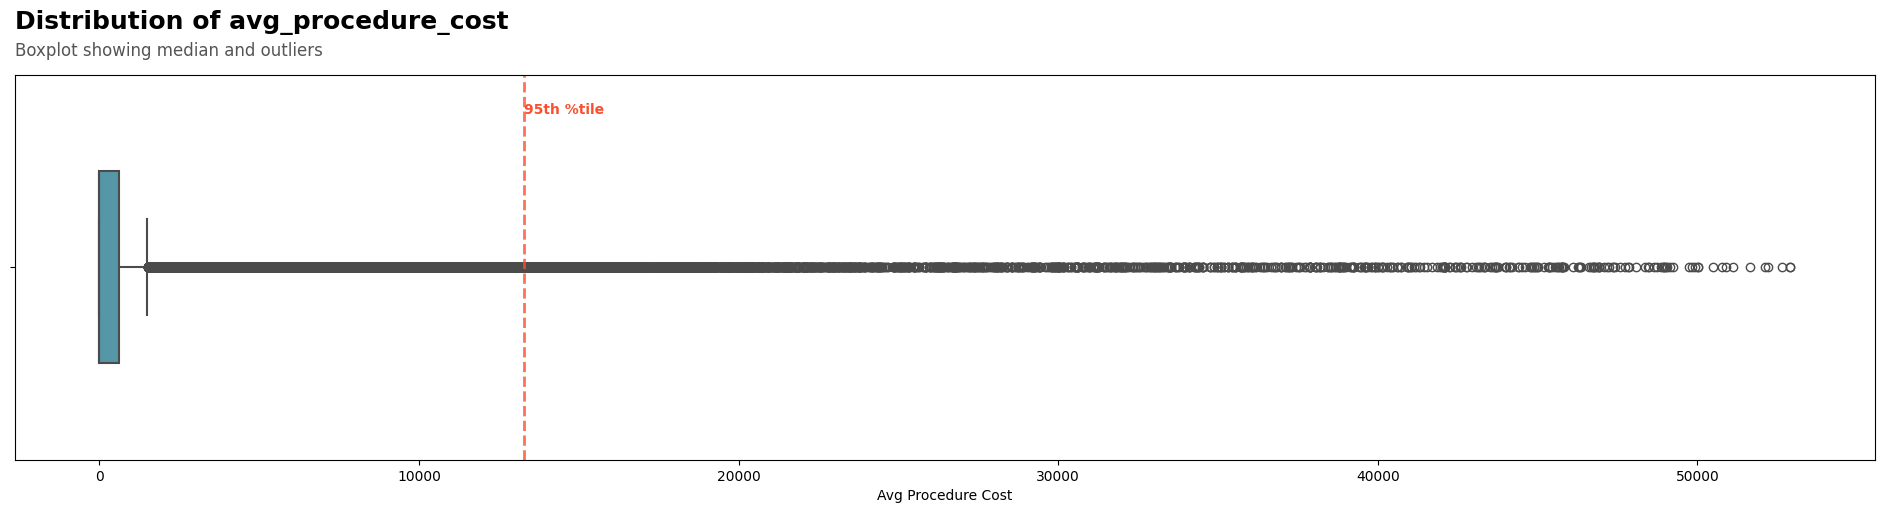

In [33]:
plt.figure(figsize=(24,5))
P.plot_box('avg_procedure_cost',data[data['avg_procedure_cost']< 75000])

In [34]:
data['avg_procedure_cost'].skew().round(2)

np.float64(5.54)

In [35]:
data[data['avg_procedure_cost']< 75000]['avg_procedure_cost'].skew().round(2)

np.float64(4.03)

- ***Removing the outliers made the skew less***

**total_medicines**

In [36]:
data['total_medicines'].describe().round(2).reset_index()

index  total_medicines
0  count          53346.0
1   mean              0.8
2    std              1.2
3    min              0.0
4    25%              0.0
5    50%              1.0
6    75%              1.0
7    max             10.0

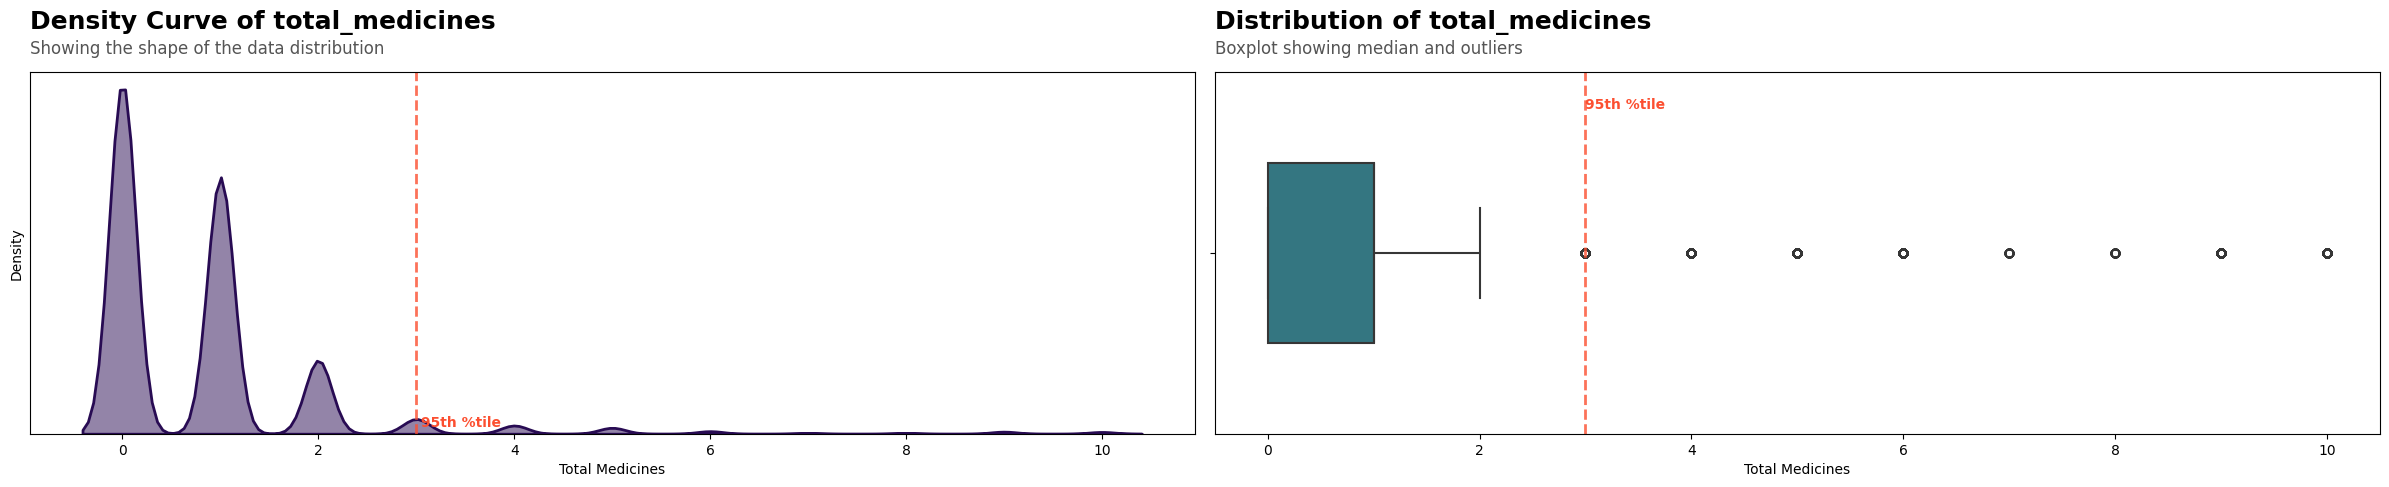

In [37]:
plt.figure(figsize=(24,5))
plt.subplot(1,2,1)
P.plot_kde('total_medicines',data)
plt.subplot(1,2,2)
P.plot_box('total_medicines',data)
plt.tight_layout()
plt.show()


In [38]:
data['total_medicines'].value_counts().div(len(data)).mul(100).round(2).reset_index(name = 'percentage')

total_medicines  percentage
0                 0       48.88
1                 1       35.73
2                 2       10.24
3                 3        2.05
4                 4        1.15
5                 5        0.83
6                 6        0.36
7                 9        0.29
8                10        0.25
9                 8        0.11
10                7        0.11

In [39]:
bins = [-1, 0, 1, 100]
labels = ['NONE', 'SINGLE', 'MULTIPLE']
data['total_medicines'] = pd.cut(data['total_medicines'], bins=bins, labels=labels)

In [40]:
data['total_medicines'].value_counts().div(len(data)).mul(100).round(2).reset_index(name = 'percentage')

total_medicines  percentage
0            NONE       48.88
1          SINGLE       35.73
2        MULTIPLE       15.38

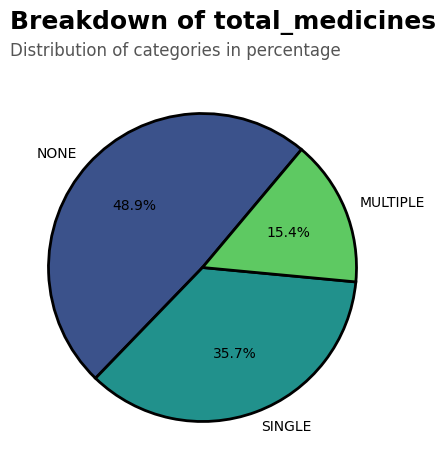

In [43]:
plt.figure(figsize=(24,5))
P.plot_pie('total_medicines',data)

- ***Changed the type of `total_medicines` - most of the observations have `none` medicines, `approx 49%`***

**avg_base_medicine_cost**

In [44]:
data['avg_base_medicine_cost'].describe().round(2).reset_index()

index  avg_base_medicine_cost
0  count                53346.00
1   mean                  162.61
2    std                  406.75
3    min                    0.00
4    25%                    0.00
5    50%                    6.80
6    75%                  263.49
7    max                 6901.17

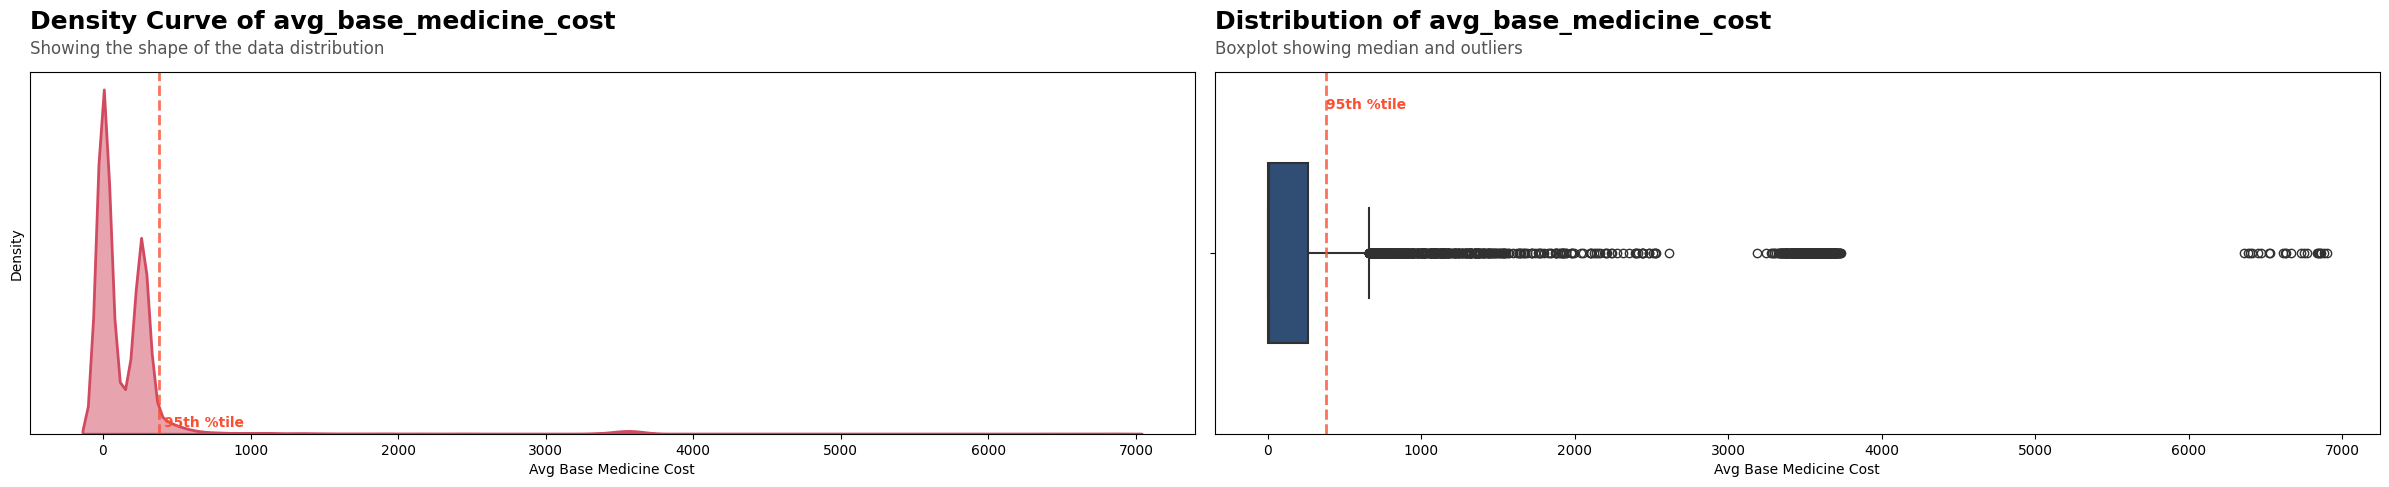

In [45]:
plt.figure(figsize=(24,5))
plt.subplot(1,2,1)
P.plot_kde('avg_base_medicine_cost',data)
plt.subplot(1,2,2)
P.plot_box('avg_base_medicine_cost',data)
plt.tight_layout()
plt.show()


- ***As seen from the visual, `avg_base_medicine_cost` is `skewed` towards `right`...and prices are clustered in `3 major price ranges`***

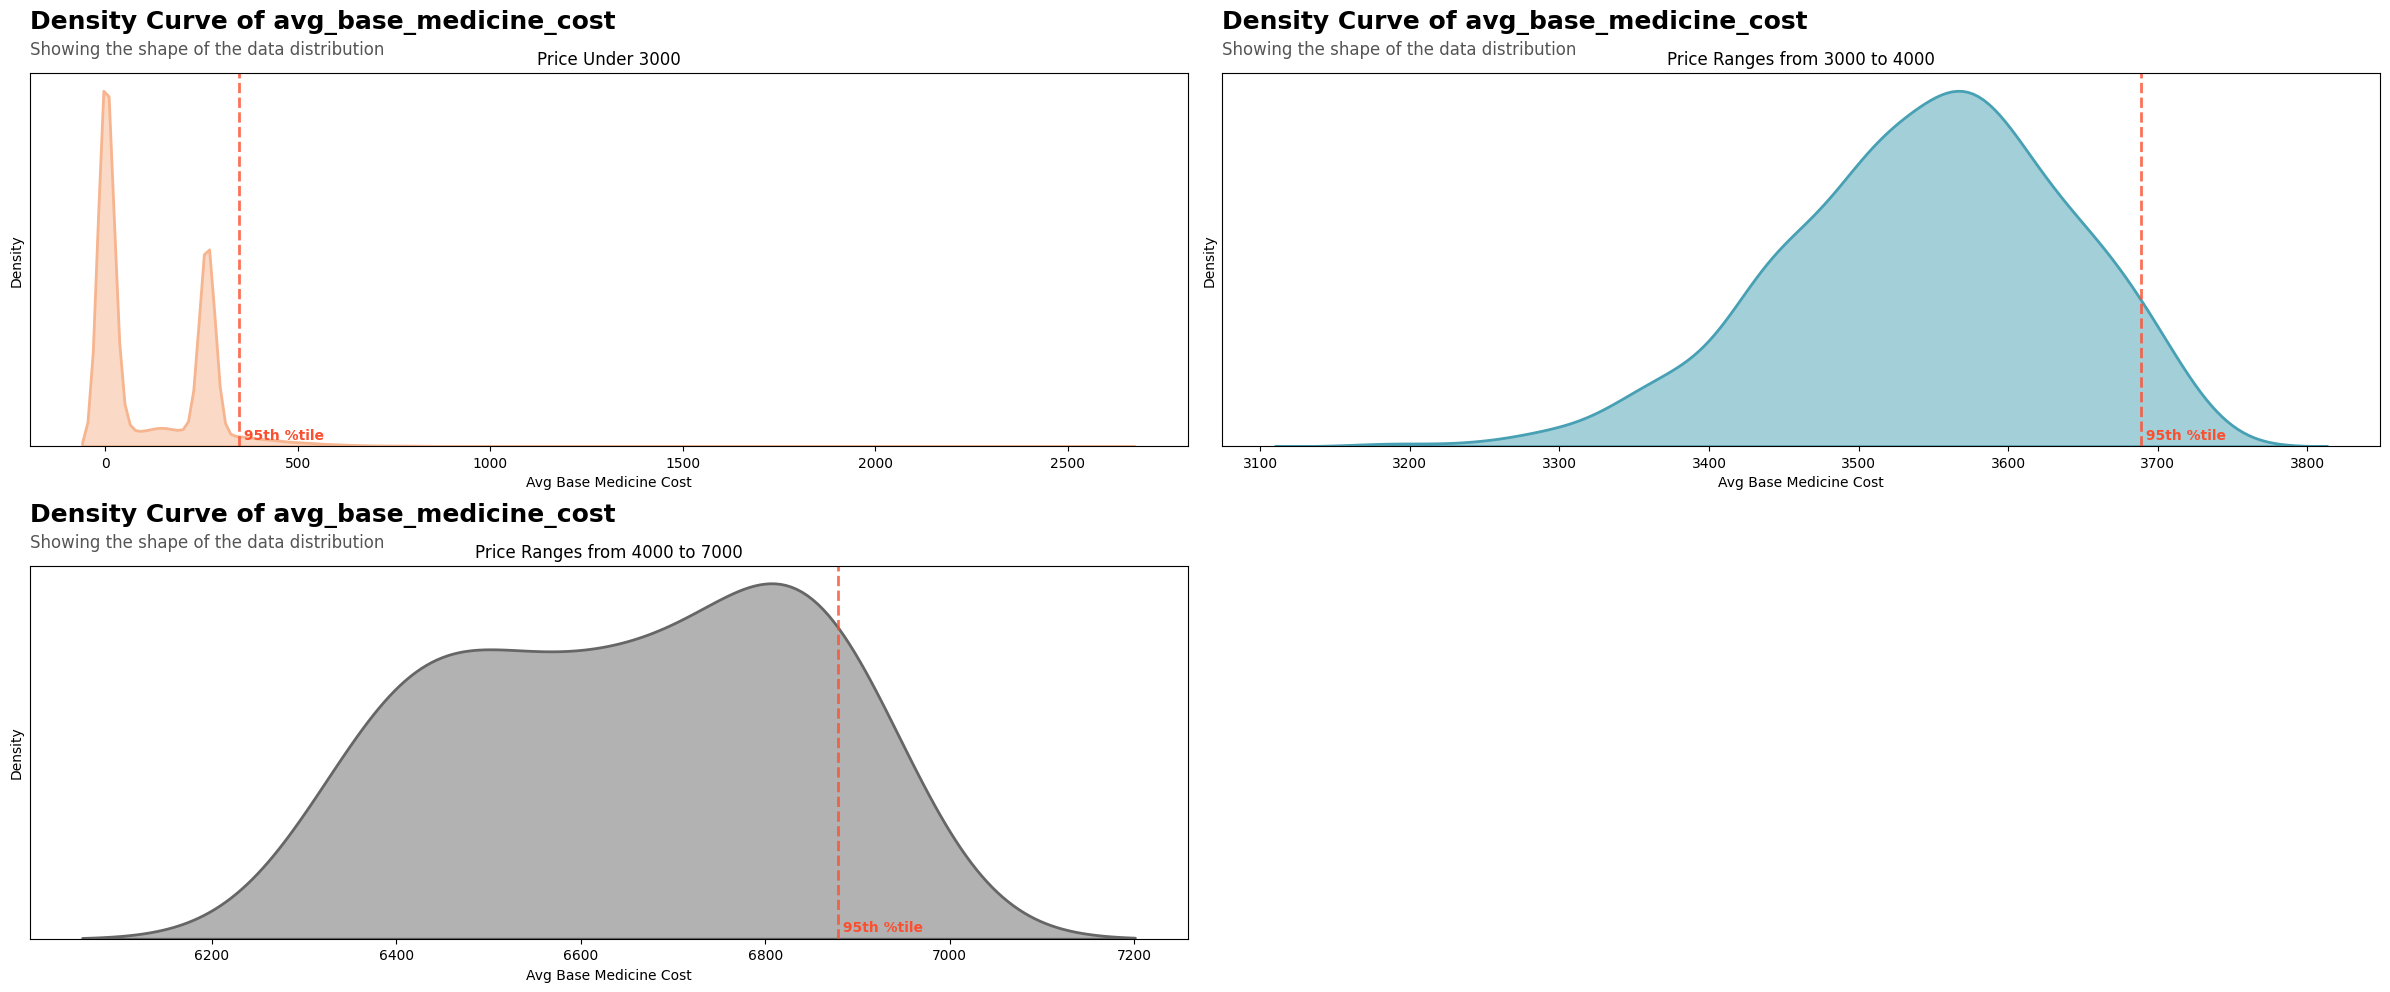

In [46]:
plt.figure(figsize=(24,10))
plt.subplot(2,2,1)
P.plot_kde('avg_base_medicine_cost',data[(data['avg_base_medicine_cost'] < 3000)])
plt.title('Price Under 3000')
plt.subplot(2,2,2)
P.plot_kde('avg_base_medicine_cost',data[(data['avg_base_medicine_cost'] > 3000) & (data['avg_base_medicine_cost'] < 4000)])
plt.title('Price Ranges from 3000 to 4000')
plt.subplot(2,2,3)
P.plot_kde('avg_base_medicine_cost',data[(data['avg_base_medicine_cost'] > 4000) & (data['avg_base_medicine_cost'] < 7000)])
plt.title('Price Ranges from 4000 to 7000')
plt.tight_layout()
plt.show()


In [47]:
data['avg_base_medicine_cost'].skew().round(2)

np.float64(7.72)

- ***As we can see, the `avg_base_medicine_cost` is `skewed` towards `right` and mainly `clusters around 3 different groups`***

**avg_total_medicine_cost**

In [48]:
data['avg_total_medicine_cost'].describe().round(2).reset_index()

index  avg_total_medicine_cost
0  count                 53346.00
1   mean                  1431.68
2    std                  9931.92
3    min                     0.00
4    25%                     0.00
5    50%                     7.22
6    75%                  1783.74
7    max               1296594.95

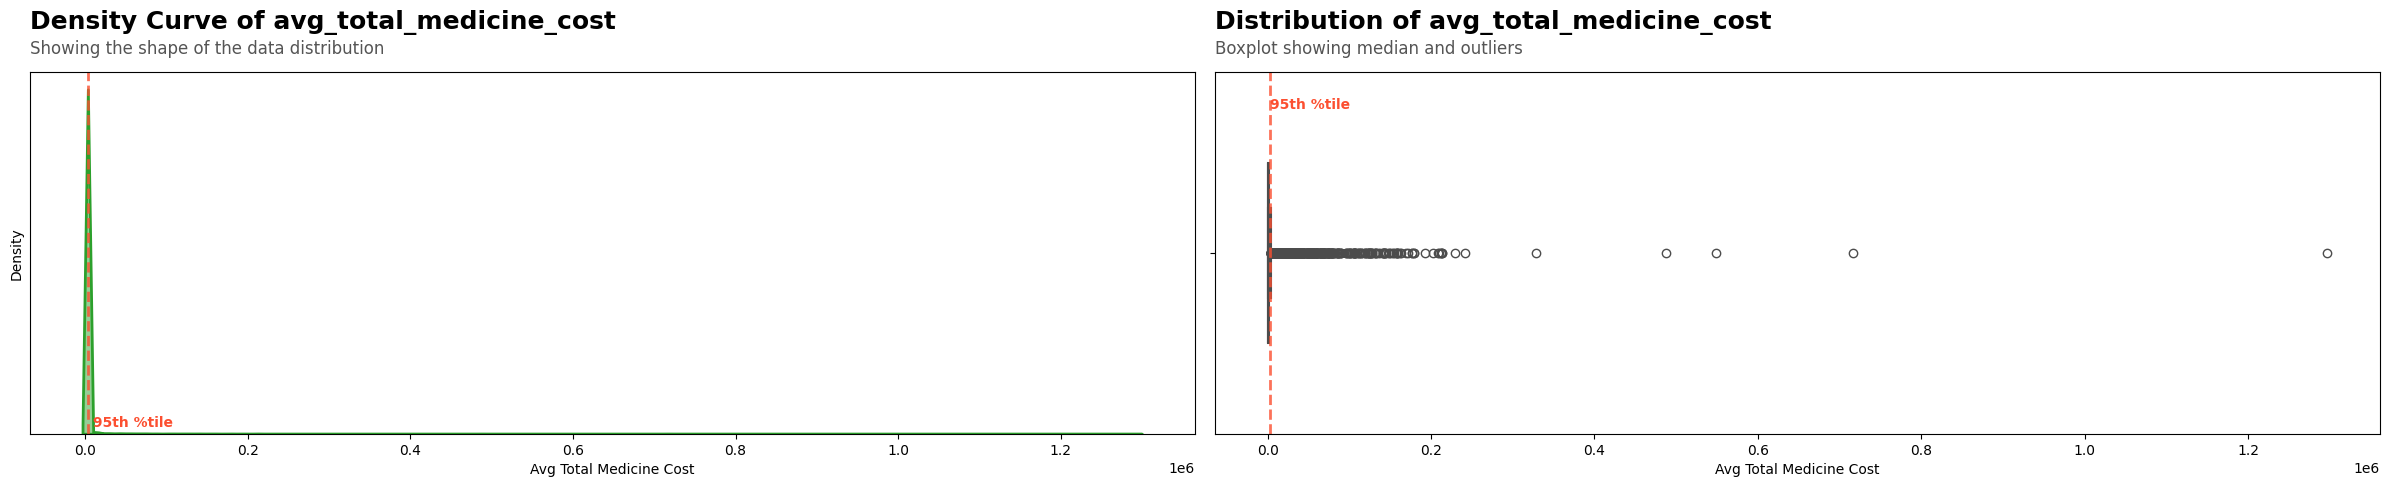

In [50]:
plt.figure(figsize=(24,5))
plt.subplot(1,2,1)
P.plot_kde('avg_total_medicine_cost',data)
plt.subplot(1,2,2)
P.plot_box('avg_total_medicine_cost',data)
plt.tight_layout()
plt.show()


In [51]:
data[data['avg_total_medicine_cost']> 200000]

encounterclass  encounter_duration total_procedures  avg_procedure_cost  \
3248       INPATIENT              1620.0             NONE                 0.0   
4849      AMBULATORY                15.0             NONE                 0.0   
4853      AMBULATORY                15.0             NONE                 0.0   
13315       WELLNESS                15.0             NONE                 0.0   
15029     AMBULATORY                95.0             NONE                 0.0   
17076     AMBULATORY                91.0             NONE                 0.0   
23163     AMBULATORY                30.0             NONE                 0.0   
30452      EMERGENCY               132.0             NONE                 0.0   
33439      EMERGENCY               131.0             NONE                 0.0   
33731     AMBULATORY                15.0             NONE                 0.0   
34595     AMBULATORY                15.0             NONE                 0.0   
34741     AMBULATORY                30.0             NONE                 0.0   
41166     AMBULATORY                30.0             NONE                 0.0   
52259      EMERGENCY               110.0             NONE                 0.0   

      total_medicines  avg_base_medicine_cost  avg_total_medicine_cost  \
3248           SINGLE                 1376.11                549067.89   
4849           SINGLE                  263.49                211582.47   
4853           SINGLE                  263.49                210001.53   
13315          SINGLE                  263.49                229763.28   
15029          SINGLE                  263.49                213426.90   
17076          SINGLE                  263.49                213953.88   
23163        MULTIPLE                 1514.19                328578.14   
30452          SINGLE                  688.16                487217.28   
33439          SINGLE                 1843.07                716954.23   
33731          SINGLE                  263.49                211582.47   
34595          SINGLE                  263.49                201833.34   
34741        MULTIPLE                 1496.95                241008.95   
41166          SINGLE                  263.49                208684.08   
52259          SINGLE                 2208.85               1296594.95   

       reasons_for_medications is_ongoing_condition  total_conditions  \
3248                         0         NO CONDITION                 0   
4849                         1         NO CONDITION                 0   
4853                         1         NO CONDITION                 0   
13315                        0         NO CONDITION                 0   
15029                        0         NO CONDITION                 0   
17076                        0         NO CONDITION                 0   
23163                        1         NO CONDITION                 0   
30452                        0         NO CONDITION                 0   
33439                        0                  YES                 2   
33731                        1         NO CONDITION                 0   
34595                        1         NO CONDITION                 0   
34741                        1         NO CONDITION                 0   
41166                        1         NO CONDITION                 0   
52259                        0         NO CONDITION                 0   

      is_ongoing_careplan  total_careplans  age_as_2022  marital   race  \
3248          NO CAREPLAN                0           63  MARRIED  WHITE   
4849          NO CAREPLAN                0           91  MARRIED  WHITE   
4853          NO CAREPLAN                0           91  MARRIED  WHITE   
13315                 YES                1           98   SINGLE  WHITE   
15029         NO CAREPLAN                0           78  MARRIED  BLACK   
17076         NO CAREPLAN                0           84  MARRIED  WHITE   
23163         NO CAREPLAN                0           75  M

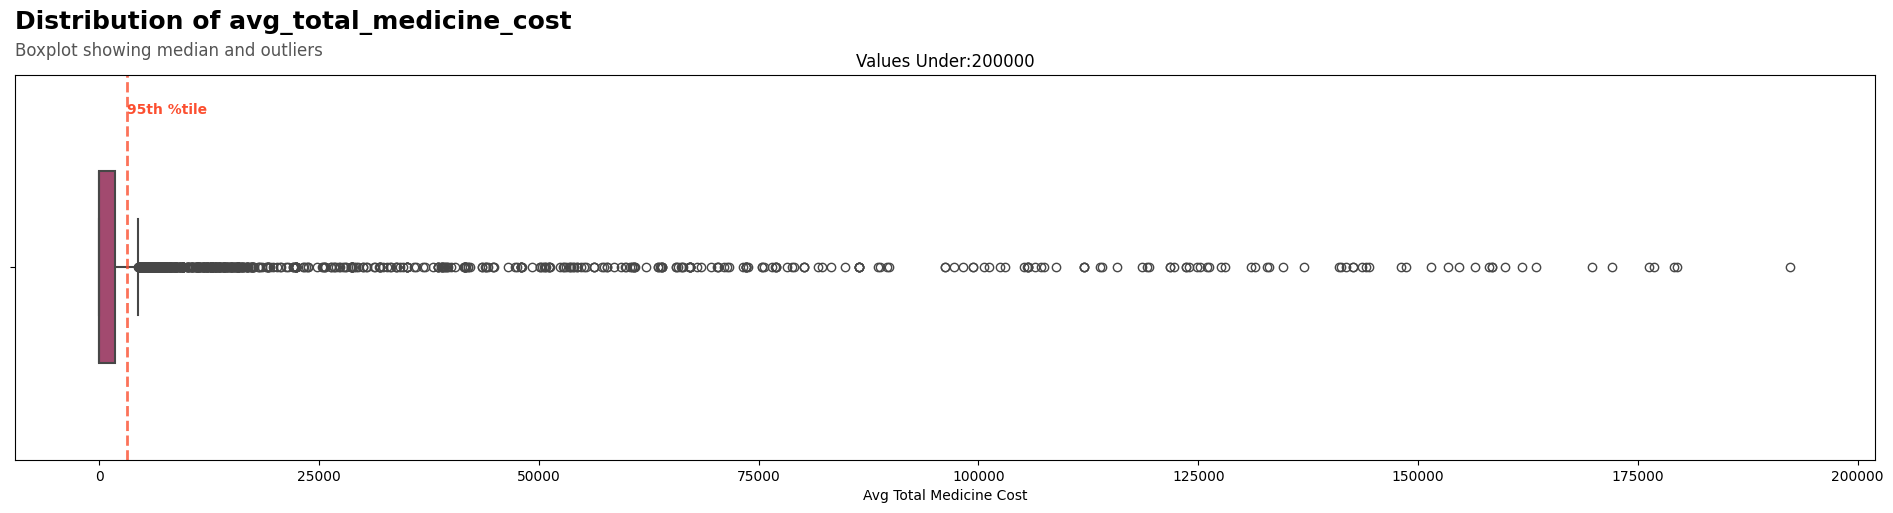

In [52]:
plt.figure(figsize=(24,5))
P.plot_box('avg_total_medicine_cost',data[data['avg_total_medicine_cost']< 200000])
plt.title('Values Under:200000')
plt.show()

In [53]:
data['avg_total_medicine_cost'].skew().round(2)

np.float64(60.36)

- ***As seen, there are `14 max outliers`,and `total_base_medicine_cost` is highly `skewed` towards `right`***

**reasons_for_medications**

In [54]:
data['reasons_for_medications'].describe().round(2).reset_index()

index  reasons_for_medications
0  count                 53346.00
1   mean                     0.50
2    std                     0.61
3    min                     0.00
4    25%                     0.00
5    50%                     0.00
6    75%                     1.00
7    max                     4.00

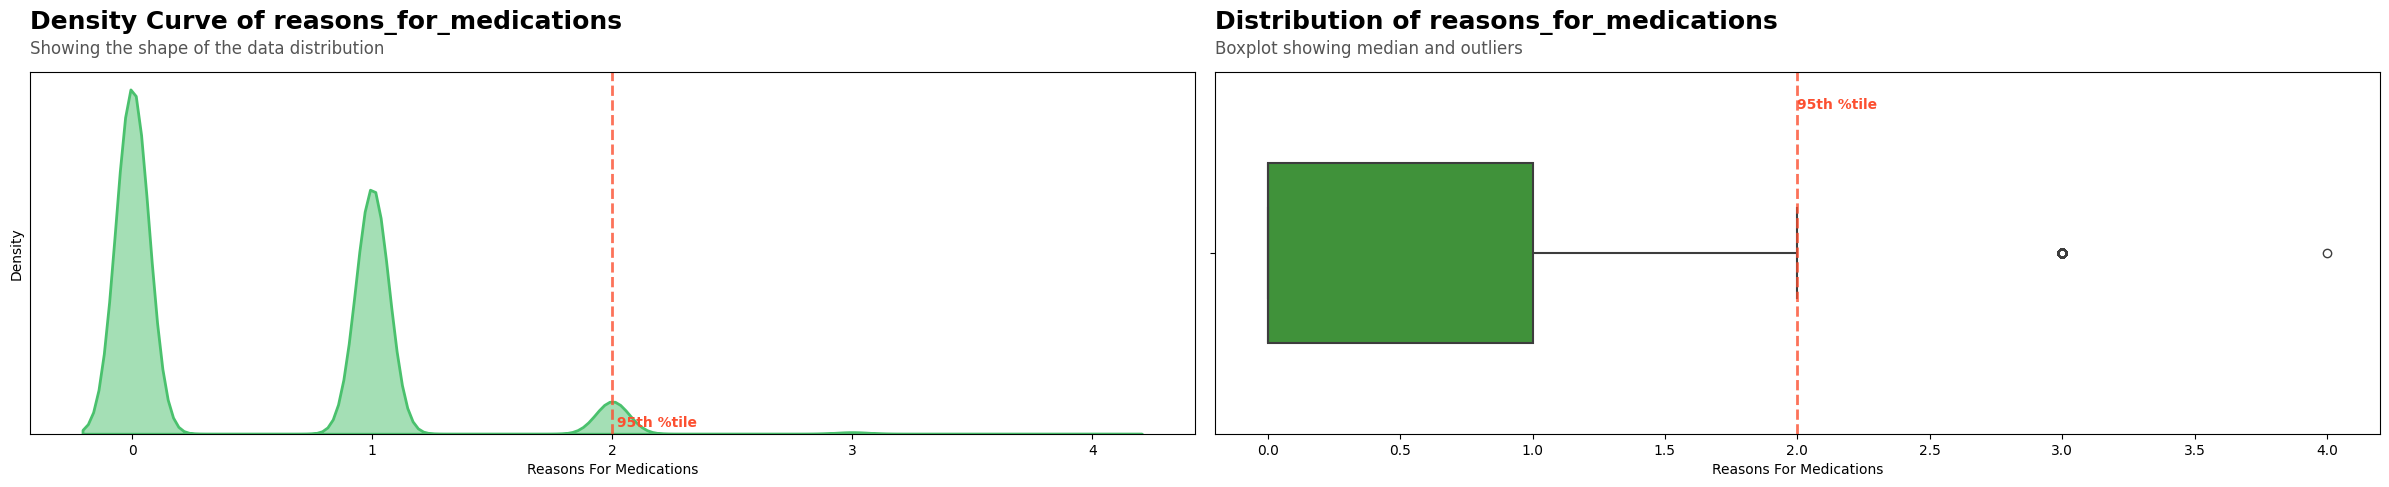

In [55]:
plt.figure(figsize=(24,5))
plt.subplot(1,2,1)
P.plot_kde('reasons_for_medications',data)
plt.subplot(1,2,2)
P.plot_box('reasons_for_medications',data)
plt.tight_layout()
plt.show()


In [56]:
data['reasons_for_medications'].value_counts().div(len(data)).mul(100).round(2).reset_index(name = 'percentage')

reasons_for_medications  percentage
0                        0       55.27
1                        1       39.30
2                        2        5.17
3                        3        0.25
4                        4        0.00

In [57]:
bins = [-1, 0, 1, 10]
labels = ['NONE', 'SINGLE', 'MULTIPLE']
data['reasons_for_medications'] = pd.cut(data['reasons_for_medications'], bins=bins, labels=labels)

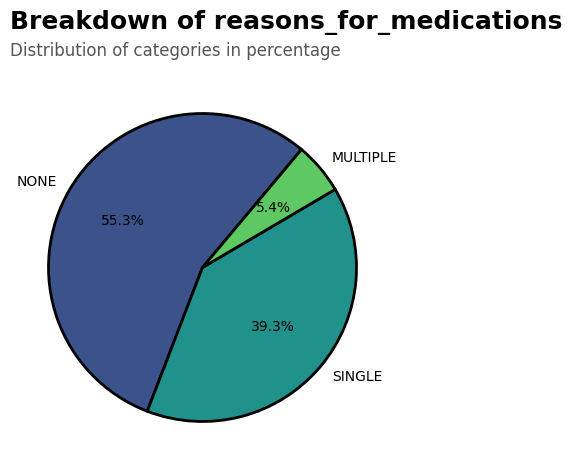

In [58]:
plt.figure(figsize=(24,5))
P.plot_pie('reasons_for_medications',data)

- ***Changed the type of `reason_for_medication` - most of the observations are from `None` class, `~55%`***

**is_ongoing_condition**

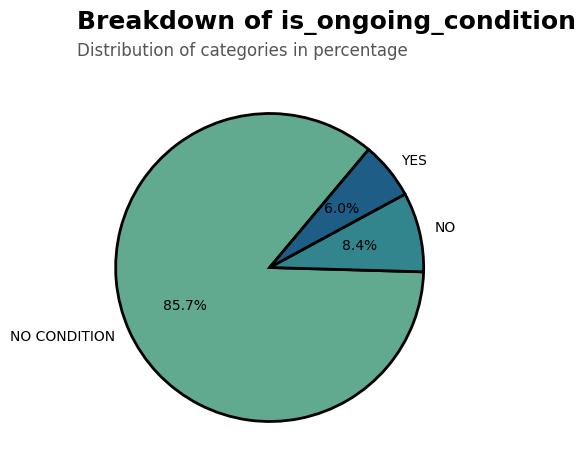

In [59]:
plt.figure(figsize=(24,5))
P.plot_pie('is_ongoing_condition',data)

- ***Most of the observations of `is_ongoing_condition` column is `NO CONDITION`, `~85%`of overall values***

**total_conditions**

In [60]:
data['total_conditions'].describe().round(2).reset_index()

index  total_conditions
0  count          53346.00
1   mean              0.16
2    std              0.41
3    min              0.00
4    25%              0.00
5    50%              0.00
6    75%              0.00
7    max              7.00

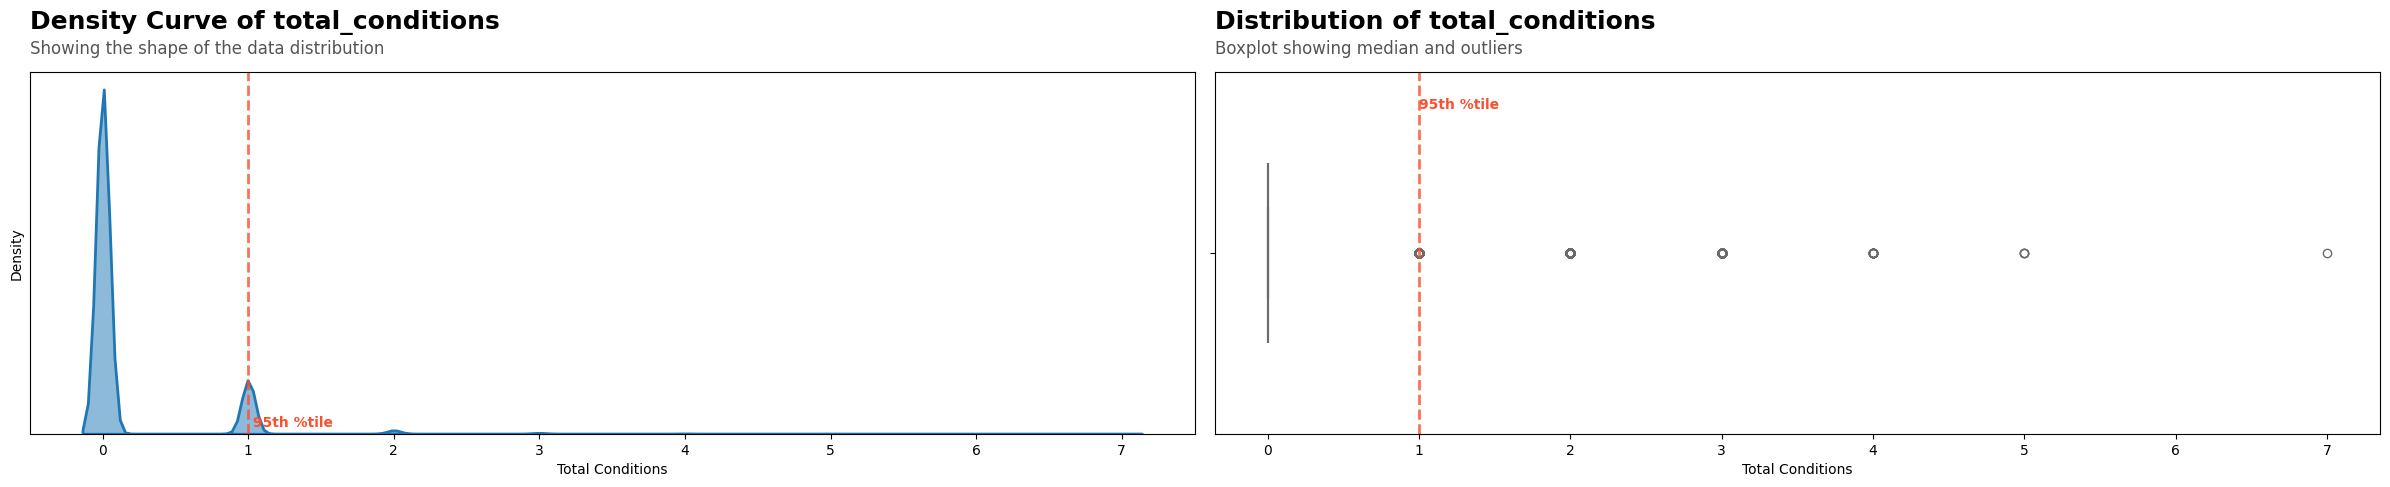

In [61]:
plt.figure(figsize=(24,5))
plt.subplot(1,2,1)
P.plot_kde('total_conditions',data)
plt.subplot(1,2,2)
P.plot_box('total_conditions',data)
plt.tight_layout()
plt.show()

In [62]:
data['total_conditions'].value_counts().div(len(data)).mul(100).round(2).reset_index(name = 'percentage')

total_conditions  percentage
0                 0       85.66
1                 1       13.25
2                 2        0.88
3                 3        0.18
4                 4        0.03
5                 5        0.01
6                 7        0.00

In [63]:
bins = [-1, 0, 1, 10]
labels = ['NONE', 'SINGLE', 'MULTIPLE']
data['total_conditions'] = pd.cut(data['total_conditions'], bins=bins, labels=labels)

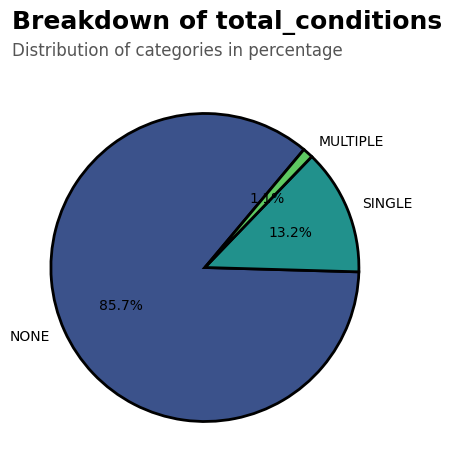

In [64]:
plt.figure(figsize=(24,5))
P.plot_pie('total_conditions',data)

- ***Changed the type of `total_conditions` - most of the observations are from `None` class, `~85%`***

**is_ongoing_careplan**

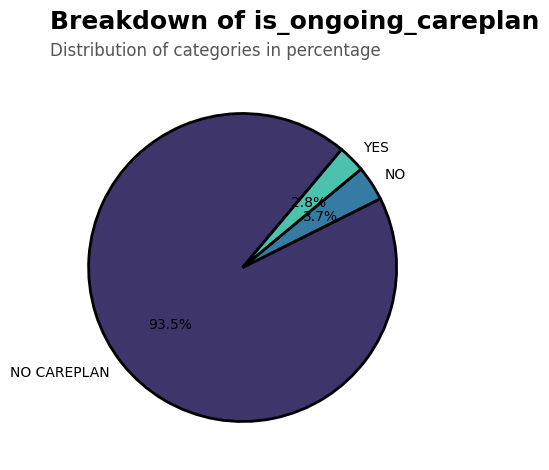

In [65]:
plt.figure(figsize=(24,5))
P.plot_pie('is_ongoing_careplan',data)

- ***Most of the observations of `is_ongoin_careplan` is from `NO CAREPLAN `class, `approx 94%`***

**total_careplans**

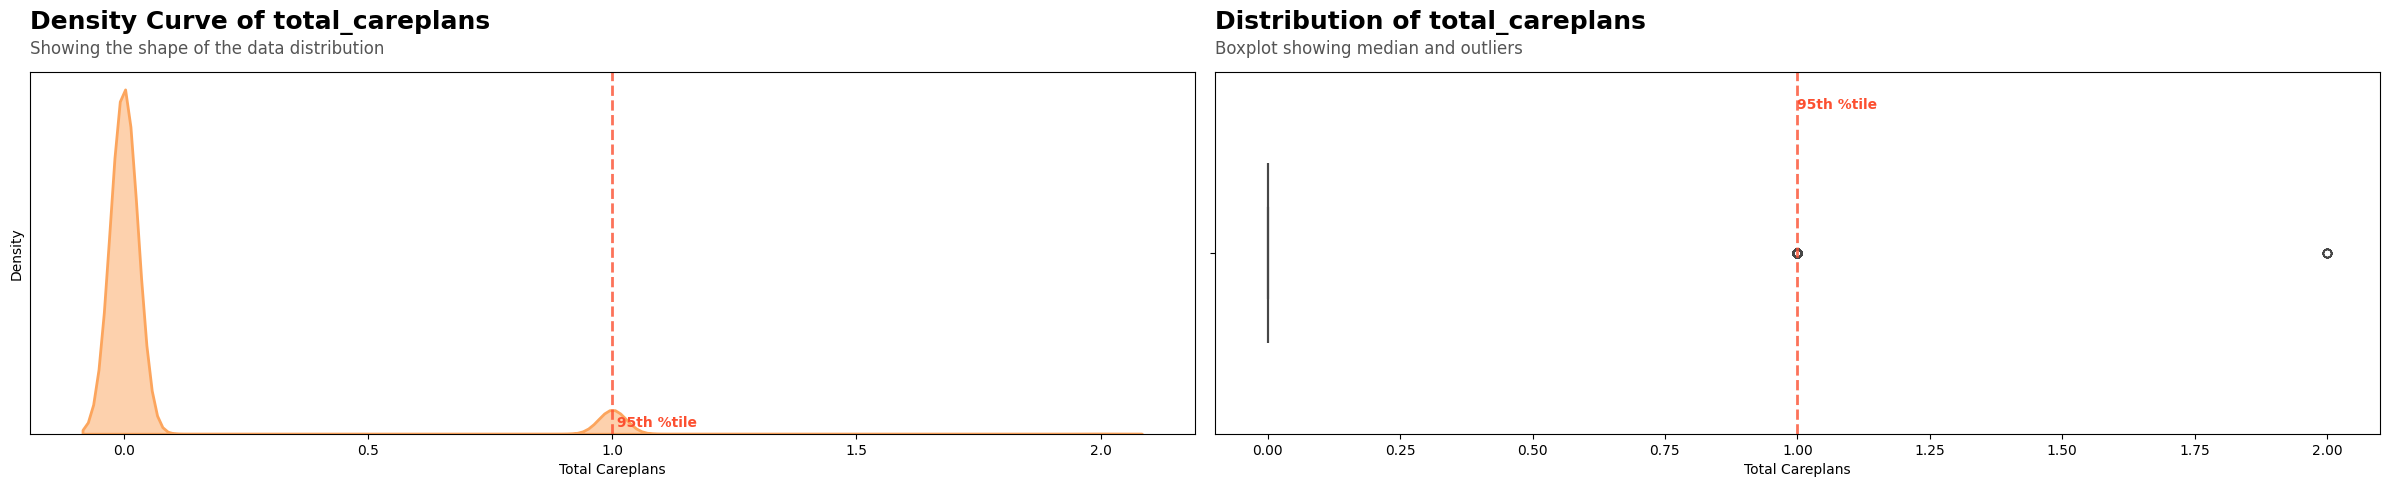

In [66]:
plt.figure(figsize=(24,5))
plt.subplot(1,2,1)
P.plot_kde('total_careplans',data)
plt.subplot(1,2,2)
P.plot_box('total_careplans',data)
plt.tight_layout()
plt.show()

In [67]:
data['total_careplans'].value_counts().div(len(data)).mul(100).round(2).reset_index(name = 'percentage')

total_careplans  percentage
0                0       93.49
1                1        6.49
2                2        0.02

In [68]:
data['total_careplans']=np.where(data['total_careplans'] == 0,'NO','YES')

In [69]:
data.rename(columns={'total_careplans':'was_careplan'},inplace=True)

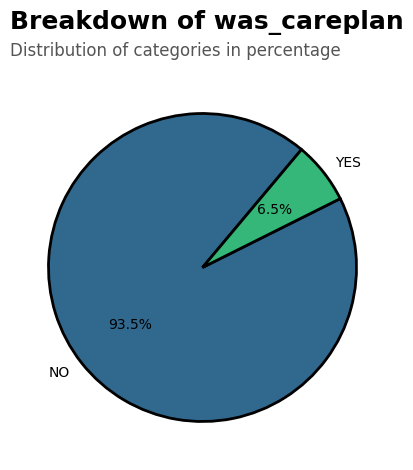

In [70]:
plt.figure(figsize=(24,5))
P.plot_pie('was_careplan',data)

- ***Changed the type of `total_careplans` column and renamed it to `was_careplan` - most of the observations are from `NO` category, `~94%`***

**age_as_2022**

In [71]:
data['age_as_2022'].describe().round(2).reset_index()

index  age_as_2022
0  count     53346.00
1   mean        55.66
2    std        25.87
3    min         1.00
4    25%        35.00
5    50%        58.00
6    75%        73.00
7    max       112.00

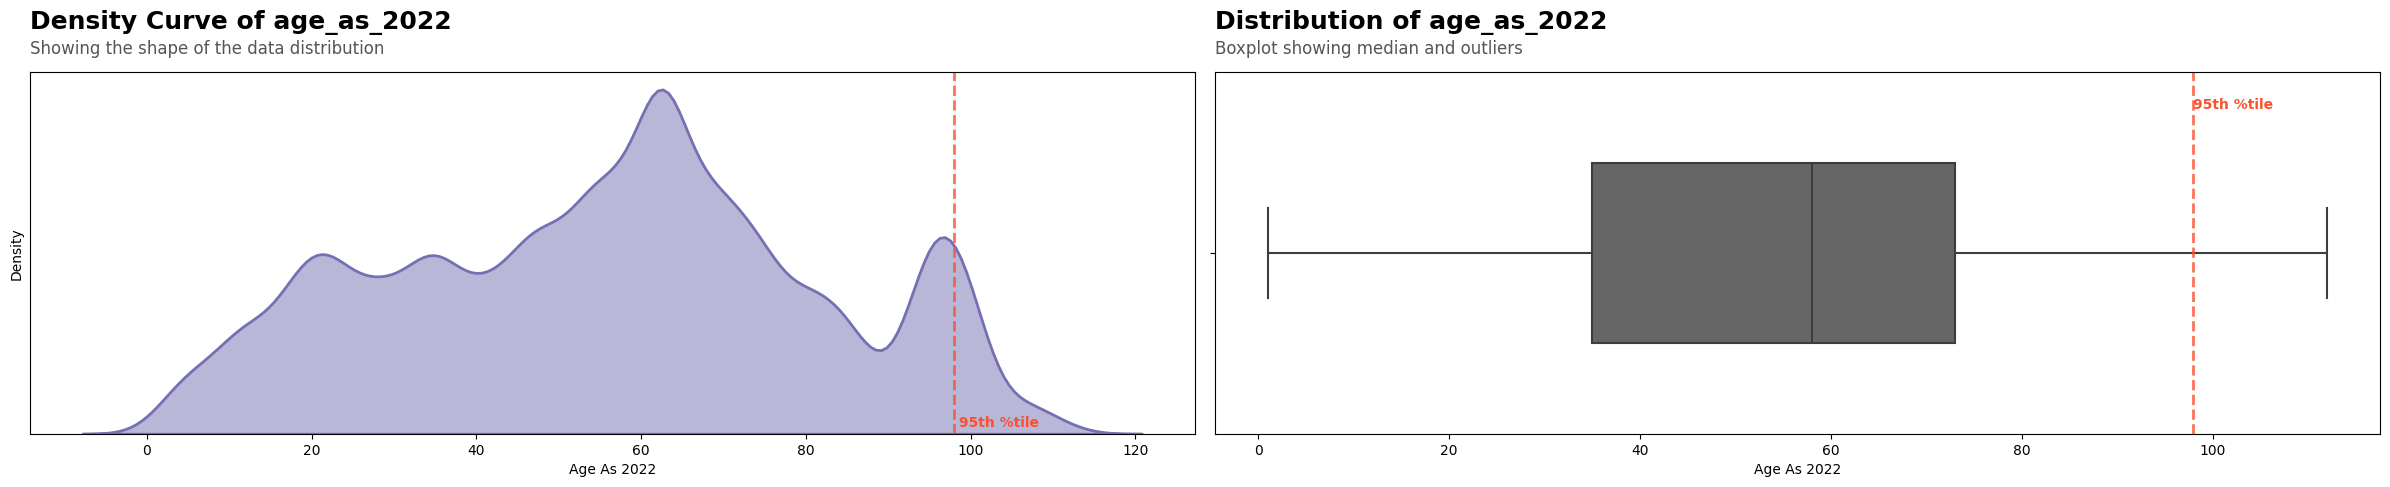

In [72]:
plt.figure(figsize=(24,5))
plt.subplot(1,2,1)
P.plot_kde('age_as_2022',data)
plt.subplot(1,2,2)
P.plot_box('age_as_2022',data)
plt.tight_layout()
plt.show()

In [73]:
data['age_as_2022'].skew().round(2)

np.float64(-0.04)

In [74]:
rows, columns = data[data['age_as_2022']>89].shape

print(f"Percentage of people aged above 100: {round((rows/len(data)*100),2)}%")

Percentage of people aged above 100: 12.69%


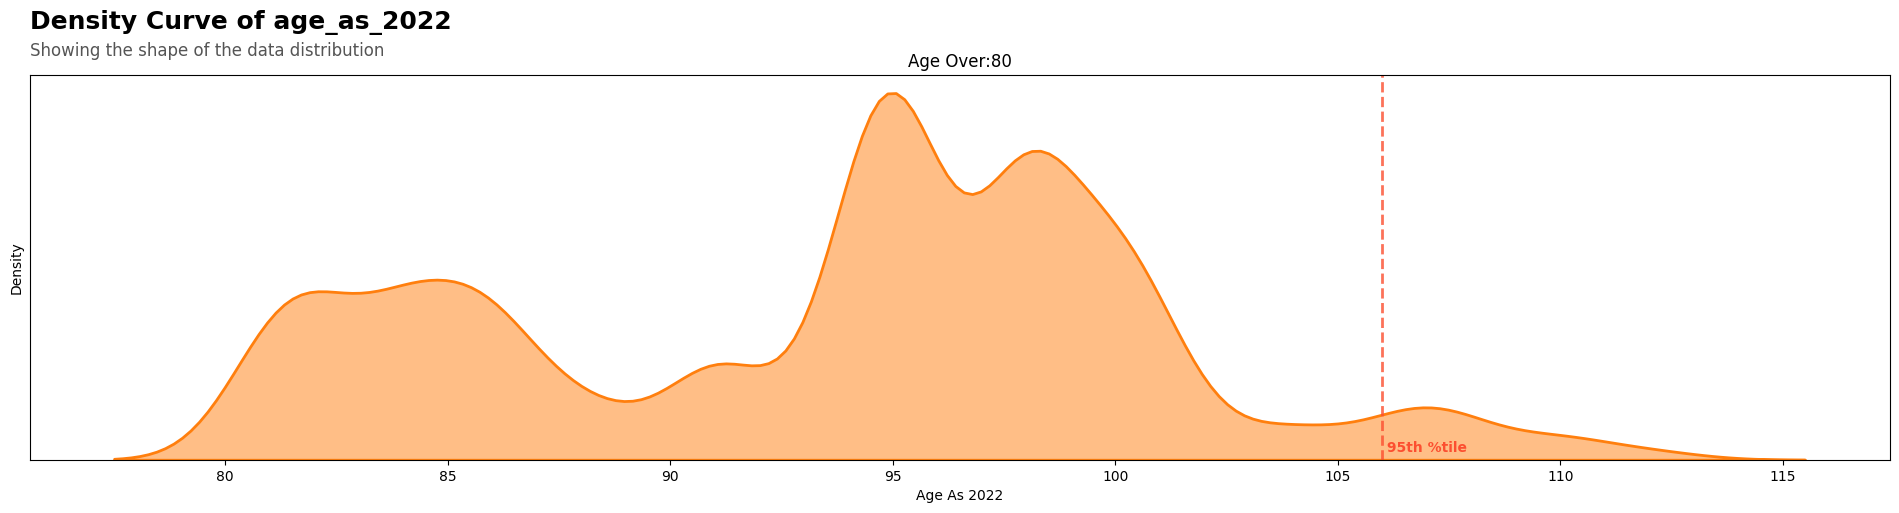

In [75]:
elders = data[data['age_as_2022']>80]
plt.figure(figsize=(24,5))
P.plot_kde('age_as_2022',elders)
plt.title('Age Over:80')
plt.show()

- ***Age column have `2 peaks`, one is around `60` and other one is around `100`, data is `slightly skewed towards left` - meaning a `relatively high` percentage of patients from `lower age group`*** 

**marital**

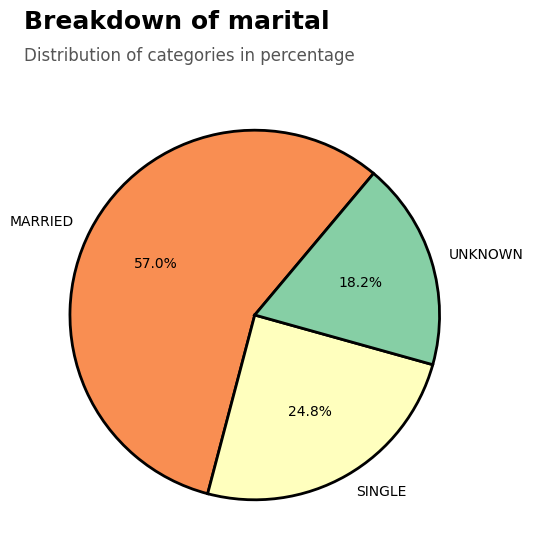

In [76]:
plt.figure(figsize=(6,6))
P.plot_pie('marital',data)

- ***Most of the values in marital column is `MARRIED`, `~57%`***

**race**

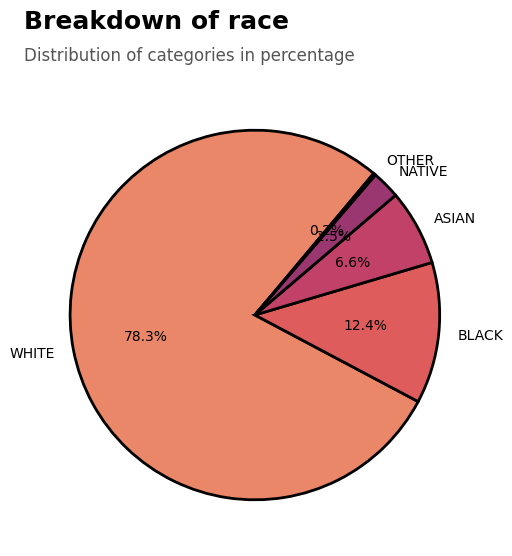

In [77]:
plt.figure(figsize=(6,6))
P.plot_pie('race',data)

- ***Most of the values in `race` is `WHITE`, `approx 79%`***

**ethnicity**

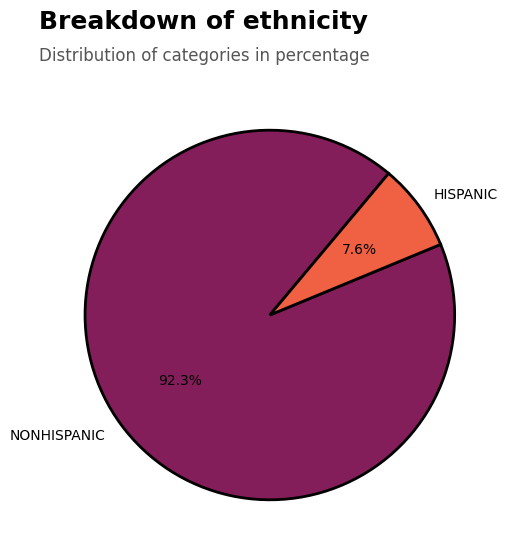

In [78]:
plt.figure(figsize=(6,6))
P.plot_pie('ethnicity',data)

- ***Most of the values in `ethnicity` column is `NONHISPANIC`, `~93%`***

**patient_gender**

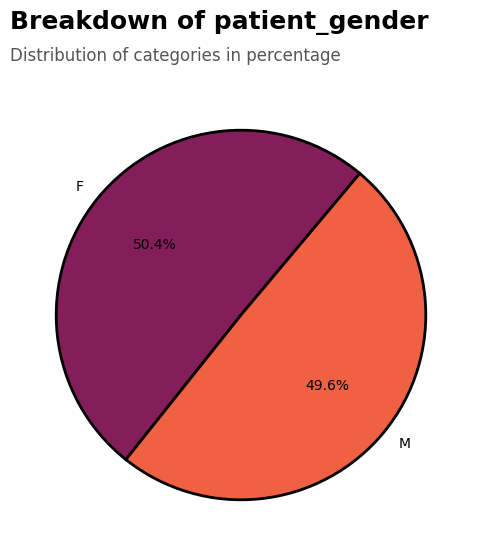

In [79]:
plt.figure(figsize=(6,6))
P.plot_pie('patient_gender',data)

- ***Patient gender is `almost equally distributed` into `M` and `F` class***

**provider_gender**

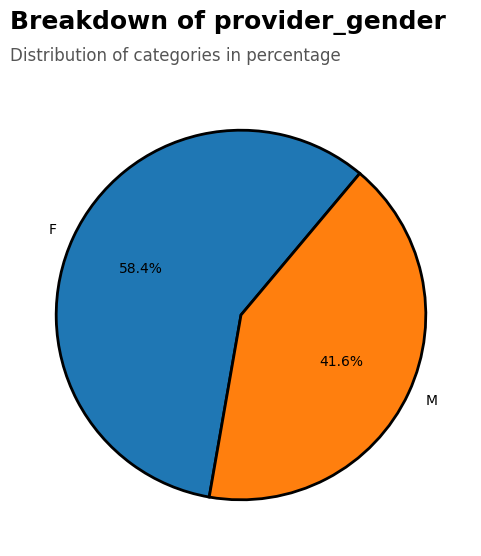

In [80]:
plt.figure(figsize=(6,6))
P.plot_pie('provider_gender',data)

- ***There are slighly more value of `F` class in `provider_gender` column, ap`prox 59%`***

**utilization**

In [81]:
data['utilization'].describe().round(2).reset_index()

index  utilization
0  count     53346.00
1   mean      1329.70
2    std      1427.73
3    min         1.00
4    25%        86.00
5    50%       821.00
6    75%      2159.00
7    max      4828.00

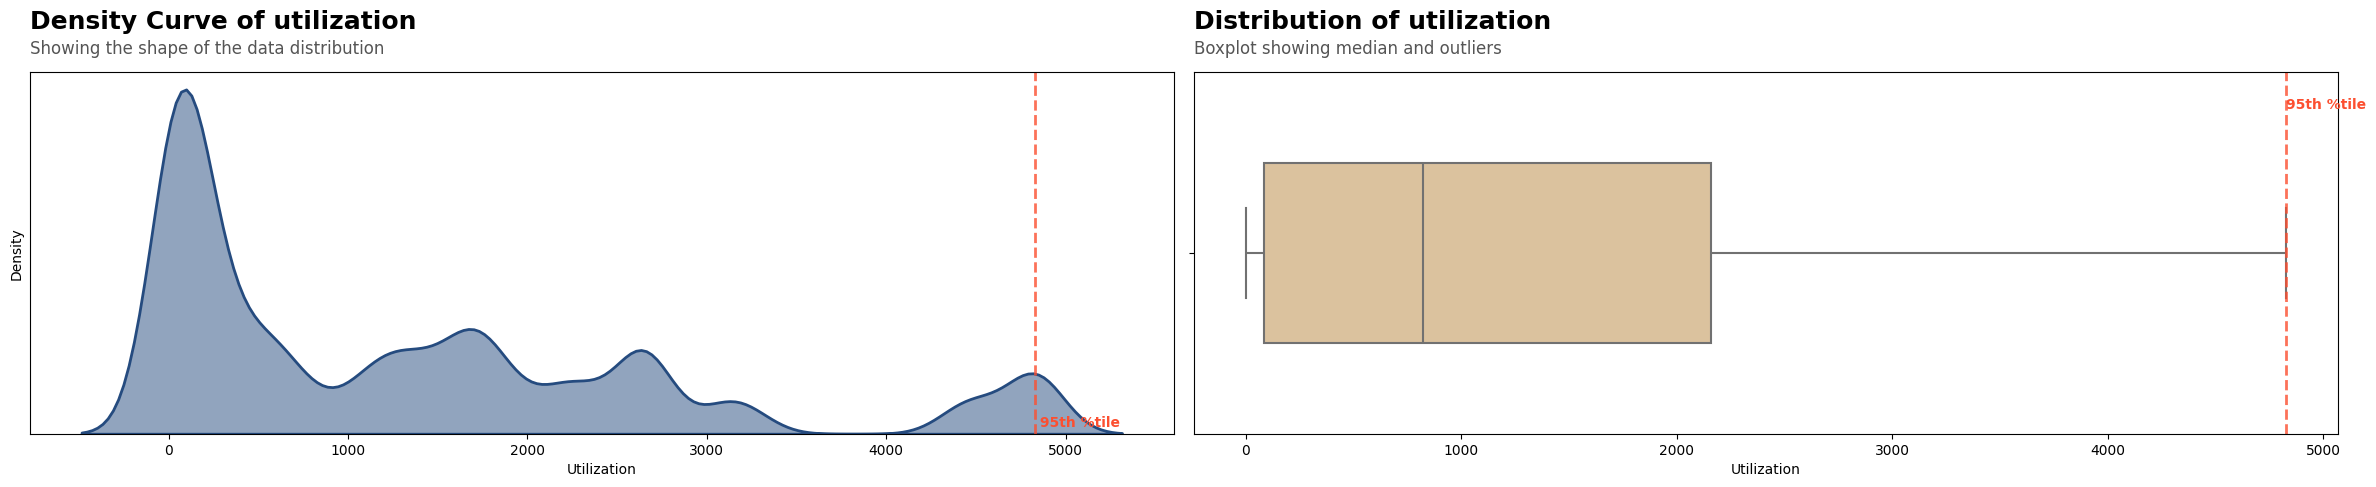

In [83]:
plt.figure(figsize=(24,5))
plt.subplot(1,2,1)
P.plot_kde('utilization',data)
plt.subplot(1,2,2)
P.plot_box('utilization',data)
plt.tight_layout()
plt.show()

In [84]:
data['utilization'].skew().round(2)

np.float64(1.1)

- ***`utilization` have no outlies - data is slighly `skewed` towards `right`, and `there is a rise after a sudden drop at 4000`***

**condition_duration**

In [85]:
data['condition_duration'].describe().round(2).reset_index()

index  condition_duration
0  count            53346.00
1   mean                7.54
2    std              156.39
3    min                0.00
4    25%                0.00
5    50%                0.00
6    75%                0.00
7    max            17947.00

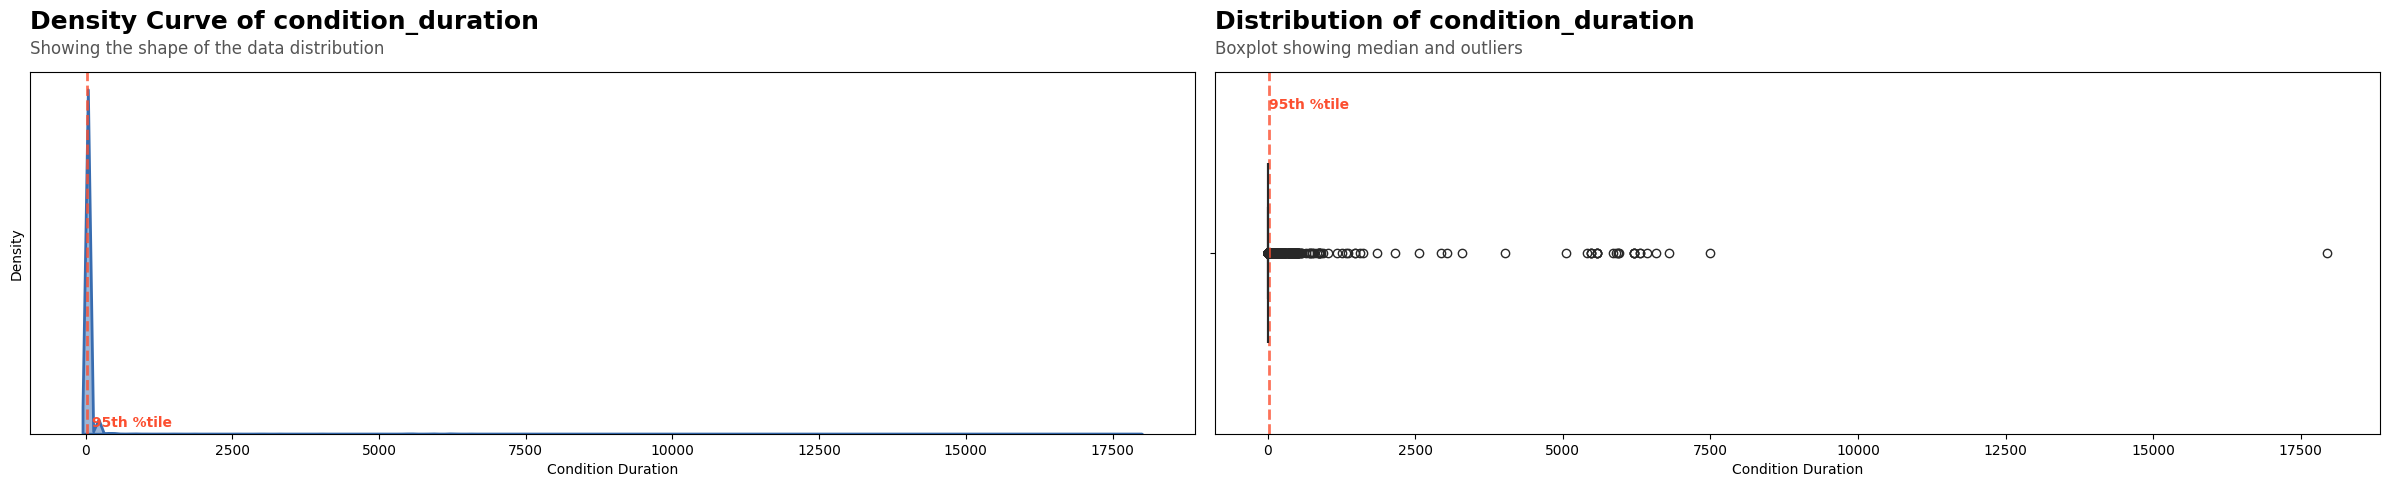

In [86]:
plt.figure(figsize=(24,5))
plt.subplot(1,2,1)
P.plot_kde('condition_duration',data)
plt.subplot(1,2,2)
P.plot_box('condition_duration',data)
plt.tight_layout()
plt.show()

In [87]:
data['condition_duration'].skew().round(2)

np.float64(55.06)

- ***`condition_duration` column is `skewed` towards `right` having `max` condition for `almost 19 years`***

**careplan_duration**

In [88]:
data['careplan_duration'].describe().round(2).reset_index()

index  careplan_duration
0  count           53346.00
1   mean               7.11
2    std             117.53
3    min               0.00
4    25%               0.00
5    50%               0.00
6    75%               0.00
7    max           10204.00

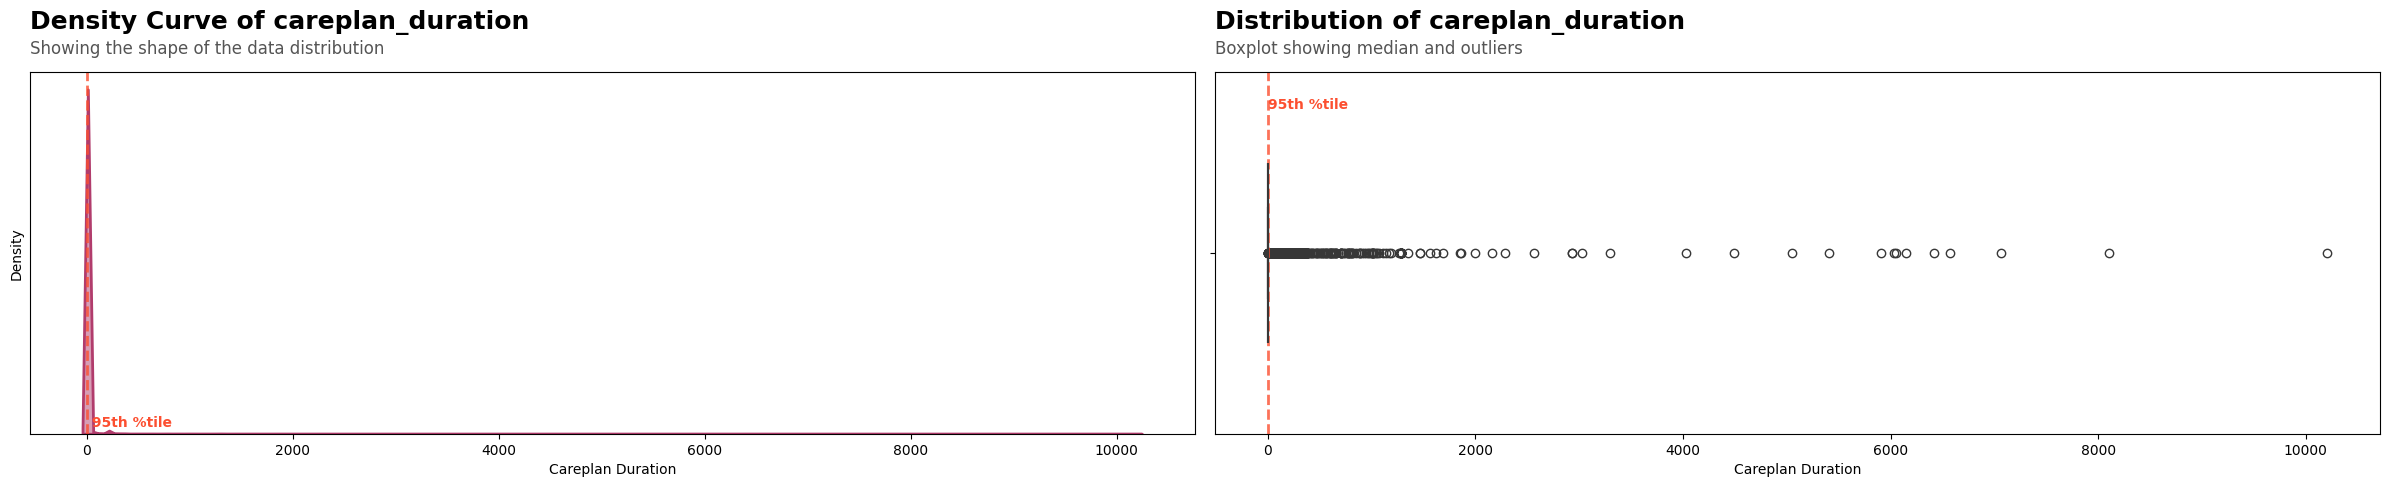

In [89]:
plt.figure(figsize=(24,5))
plt.subplot(1,2,1)
P.plot_kde('careplan_duration',data)
plt.subplot(1,2,2)
P.plot_box('careplan_duration',data)
plt.tight_layout()
plt.show()

In [90]:
data['careplan_duration'].skew().round(2)

np.float64(47.3)

- ***`careplan_duration` column is `skewed` towards `right` having `max` careplan for `almost 27 years`***

**visit_number**

In [91]:
data['visit_number'].describe().round(2).reset_index()

index  visit_number
0  count      53346.00
1   mean        127.88
2    std        300.86
3    min          1.00
4    25%         12.00
5    50%         30.00
6    75%         69.00
7    max       2006.00

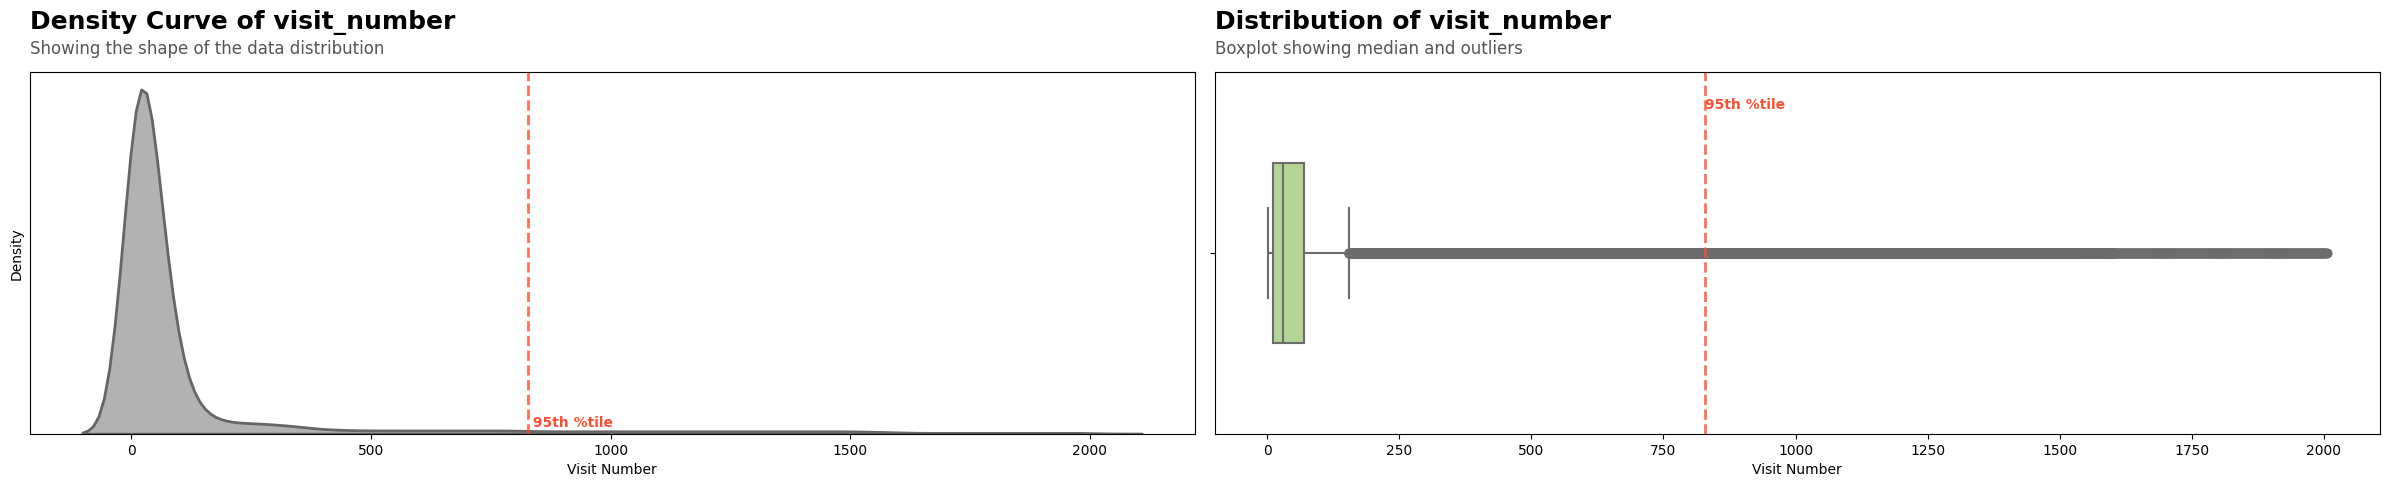

In [93]:
plt.figure(figsize=(24,5))
plt.subplot(1,2,1)
P.plot_kde('visit_number',data)
plt.subplot(1,2,2)
P.plot_box('visit_number',data)
plt.tight_layout()
plt.show()

In [94]:
bins = [0, 1, 10, 10000]
labels = ['NEW', 'RETURNING', 'FREQUENT']
    
data['visit_frequency'] = pd.cut(data['visit_number'], bins=bins, labels=labels)
data.drop(columns=['visit_number'],inplace=True)

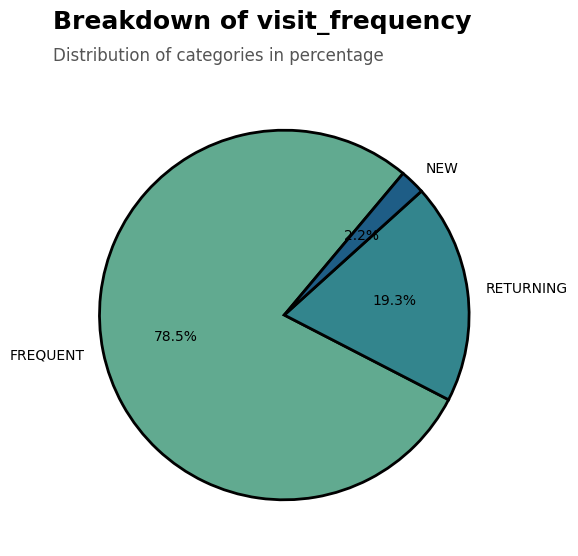

In [95]:
plt.figure(figsize=(6,6))
P.plot_pie('visit_frequency',data)

- ***Changed the column `visit_number` to `visit_frequency`, most of the values in this column are `FREQUENT` - `~79%`***

**coverage_ratio**

In [175]:
data['coverage_ratio'].describe().round(2).reset_index()

index  coverage_ratio
0  count        53346.00
1   mean            0.48
2    std            0.34
3    min            0.00
4    25%            0.23
5    50%            0.54
6    75%            0.69
7    max            1.00

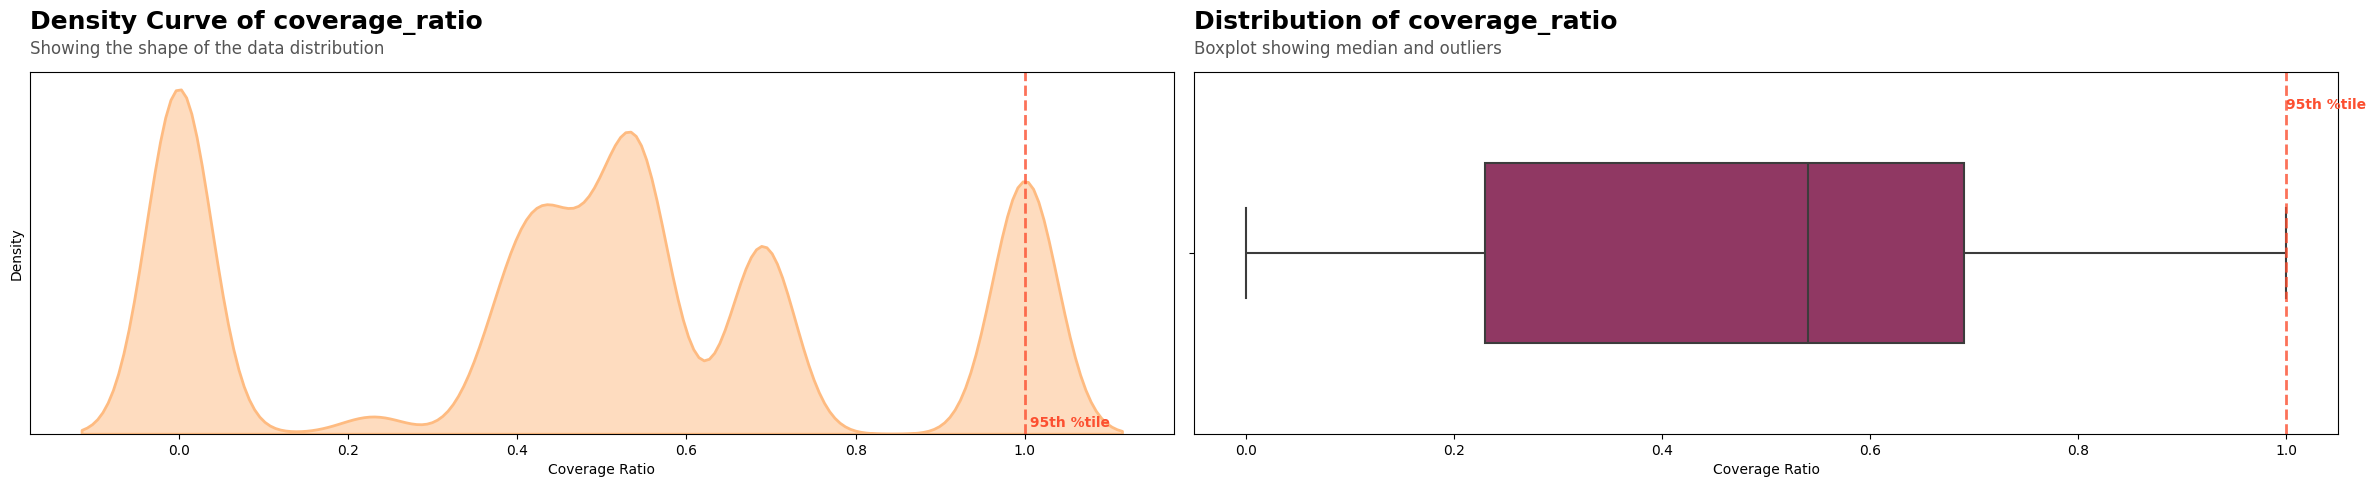

In [96]:
plt.figure(figsize=(24,5))
plt.subplot(1,2,1)
P.plot_kde('coverage_ratio',data)
plt.subplot(1,2,2)
P.plot_box('coverage_ratio',data)
plt.tight_layout()
plt.show()

- ***`coverage_ratio` have `3 peaks` - one is around `0`, one is around `1` and the other is `at the middle`***

**medication_duration**

In [97]:
data['medication_duration'].describe().round(2).reset_index()

index  medication_duration
0  count             53346.00
1   mean               122.99
2    std               443.13
3    min                 0.00
4    25%                 0.00
5    50%                 0.00
6    75%               361.00
7    max             24091.00

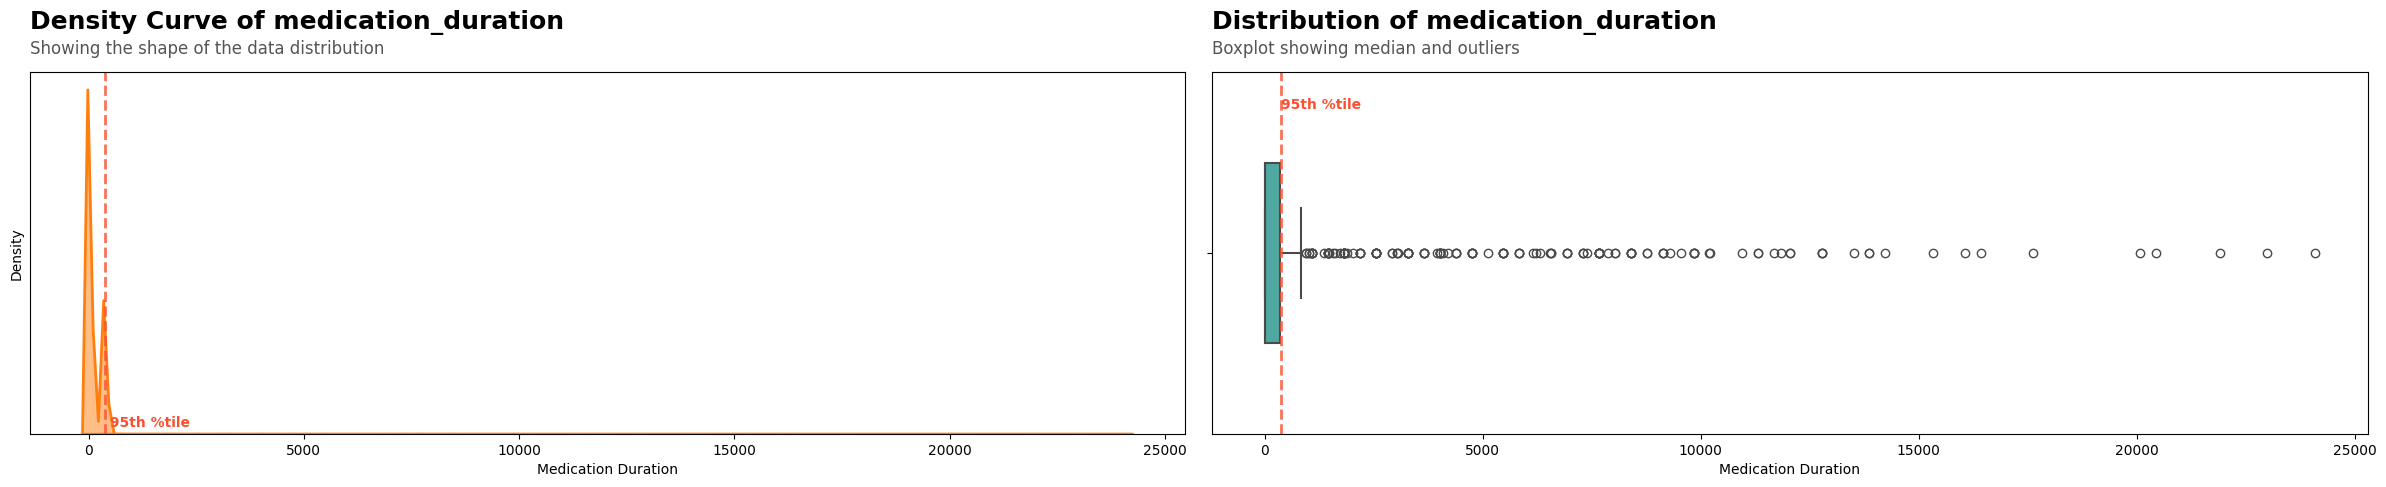

In [98]:
plt.figure(figsize=(24,5))
plt.subplot(1,2,1)
P.plot_kde('medication_duration',data)
plt.subplot(1,2,2)
P.plot_box('medication_duration',data)
plt.tight_layout()
plt.show()


In [99]:
data['medication_duration'].skew().round(2)

np.float64(26.37)

- ***`medication_duration` have `skewness` towards `right`***

**procedures_per_hour**

In [100]:
data['procedures_per_hour'].describe().round(2).reset_index()

index  procedures_per_hour
0  count             53346.00
1   mean                 0.45
2    std                 0.75
3    min                 0.00
4    25%                 0.00
5    50%                 0.00
6    75%                 1.00
7    max                 4.00

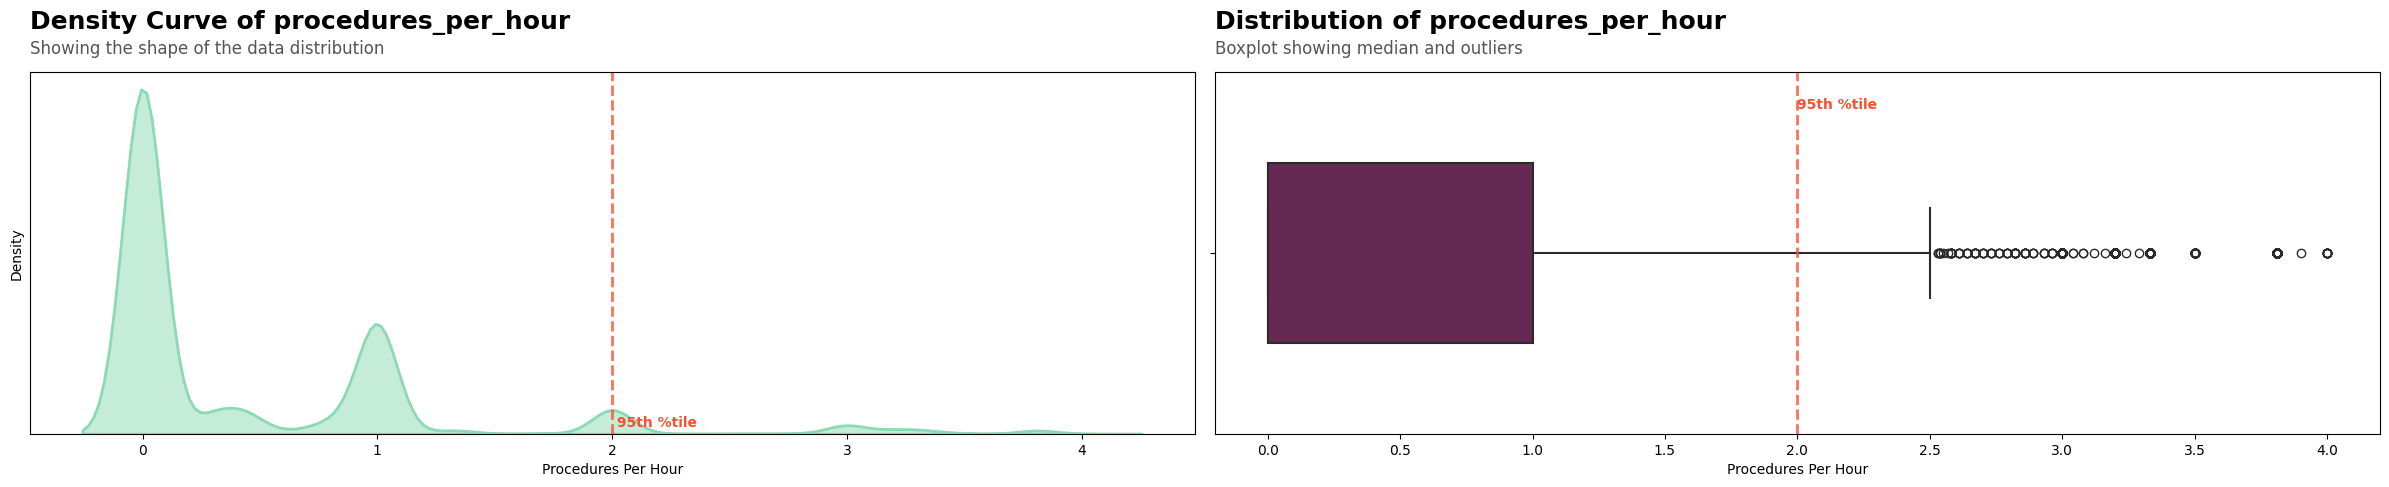

In [101]:
plt.figure(figsize=(24,5))
plt.subplot(1,2,1)
P.plot_kde('procedures_per_hour',data)
plt.subplot(1,2,2)
P.plot_box('procedures_per_hour',data)
plt.tight_layout()
plt.show()


In [102]:
data['procedures_per_hour'].value_counts().div(len(data)).mul(100).round(2).reset_index(name = 'percentage')

procedures_per_hour  percentage
0                   0.00       60.50
1                   1.00       19.04
2                   2.00        4.24
3                   0.44        3.11
4                   0.31        3.09
..                   ...         ...
168                 1.21        0.00
169                 0.56        0.00
170                 3.12        0.00
171                 1.69        0.00
172                 0.49        0.00

[173 rows x 2 columns]

In [103]:
bins = [-1, 0.1, 1.1, 100]
labels = ['LOW', 'MEDIUM', 'HIGH']
data['procedures_per_hour']=pd.DataFrame(pd.cut(data['procedures_per_hour'], bins=bins, labels=labels))
data.rename(columns={'procedures_per_hour':'procedure_intensity'},inplace=True)

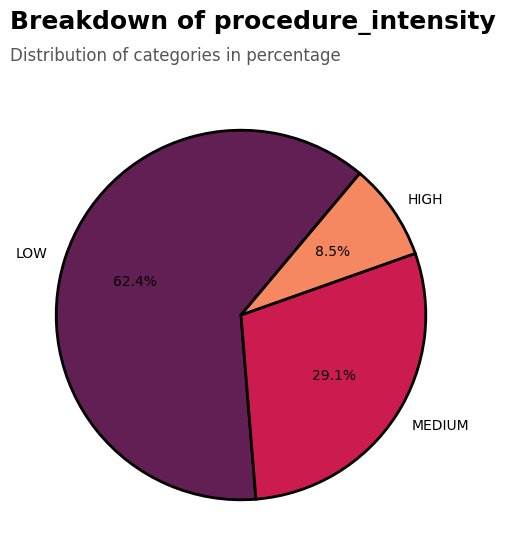

In [104]:
plt.figure(figsize=(6,6))
P.plot_pie('procedure_intensity',data)

- ***changed the `procedure_per_hour` column - most frequent value in new `procedure_intensity` column is `LOW`, `~62%`***

**caused_readmission**

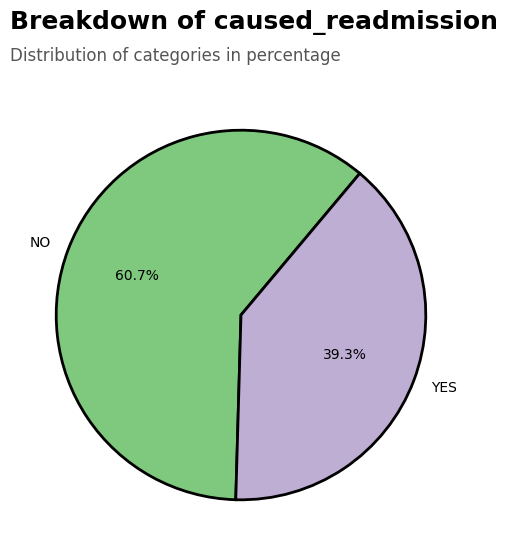

In [105]:
plt.figure(figsize=(6,6))
P.plot_pie('caused_readmission',data)

- ***`Approx 40% of encounters are reason for another readmission`***

### ***Bivariate Analysis***

In [106]:
cat_cols = data.select_dtypes(include='object').columns.values.tolist()

In [107]:
num_cols = data.select_dtypes(include='number').columns.values.tolist()

***CATEGORICAL COLUMNS WITH `caused_readmission` COLUMN***

**encounterclass**

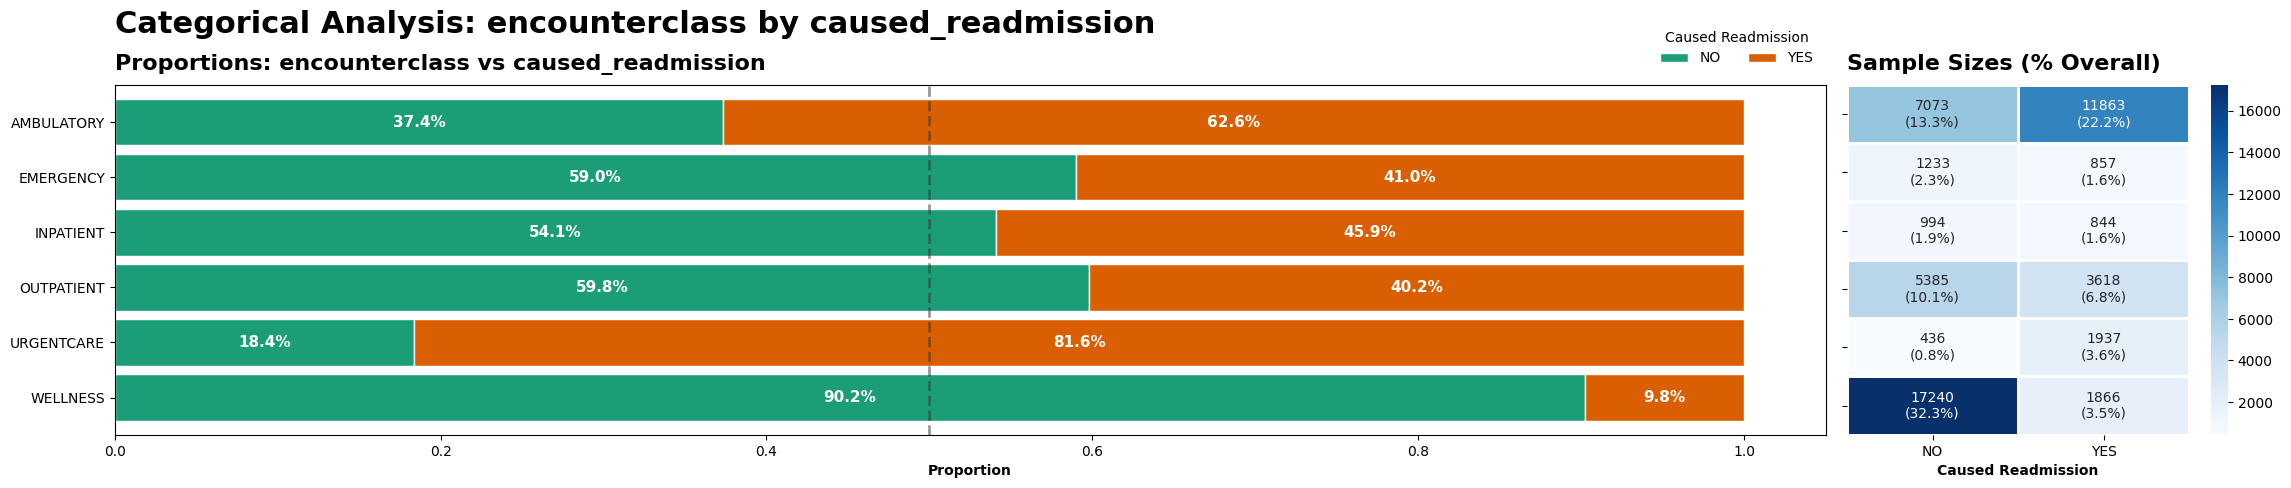

In [108]:
plt.figure(figsize=(24,5))
P.plot_categorical(data,'encounterclass','caused_readmission')

In [ ]:
temp = data[['encounterclass','caused_readmission']]
temp['encounterclass'] = data['encounterclass'].replace('URGENTCARE','CRIT').replace('AMBULATORY','CRIT')

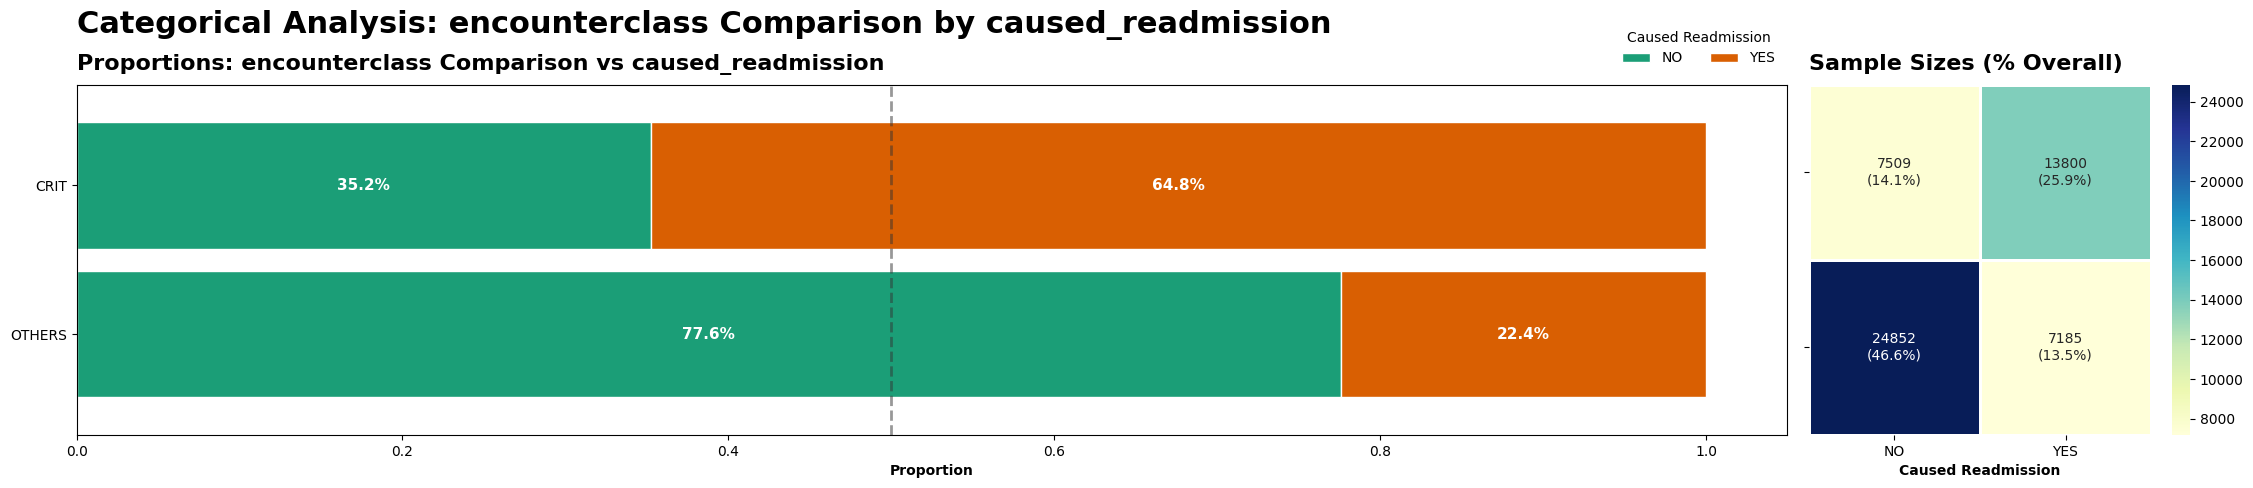

In [115]:
plt.figure(figsize=(24,5))
P.plot_masked_categorical(temp,'encounterclass','CRIT','caused_readmission')

In [116]:
urgent_care_mask = (data['encounterclass']=='URGENTCARE') | (data['encounterclass']=='AMBULATORY')
ct = pd.crosstab(urgent_care_mask,data['caused_readmission'])

S.test_association(ct)


--- Association Test: encounterclass vs caused_readmission ---
1. Verdict:    ✅ SIGNIFICANT Association (p=0.00000)
2. Strength:   Strong (Cramer's V = 0.424)
3. Balance:    Robust (High N)
------------------------------------------------------------


---
---
- ***By visuals we saw that `urgentcare and ambulatory encounter class showed a higher number in causing readmission` - by statistical test we can support this observation with strong strength, and large sample size makes it a reliable find***
---
---

**is_ongoing_condition**

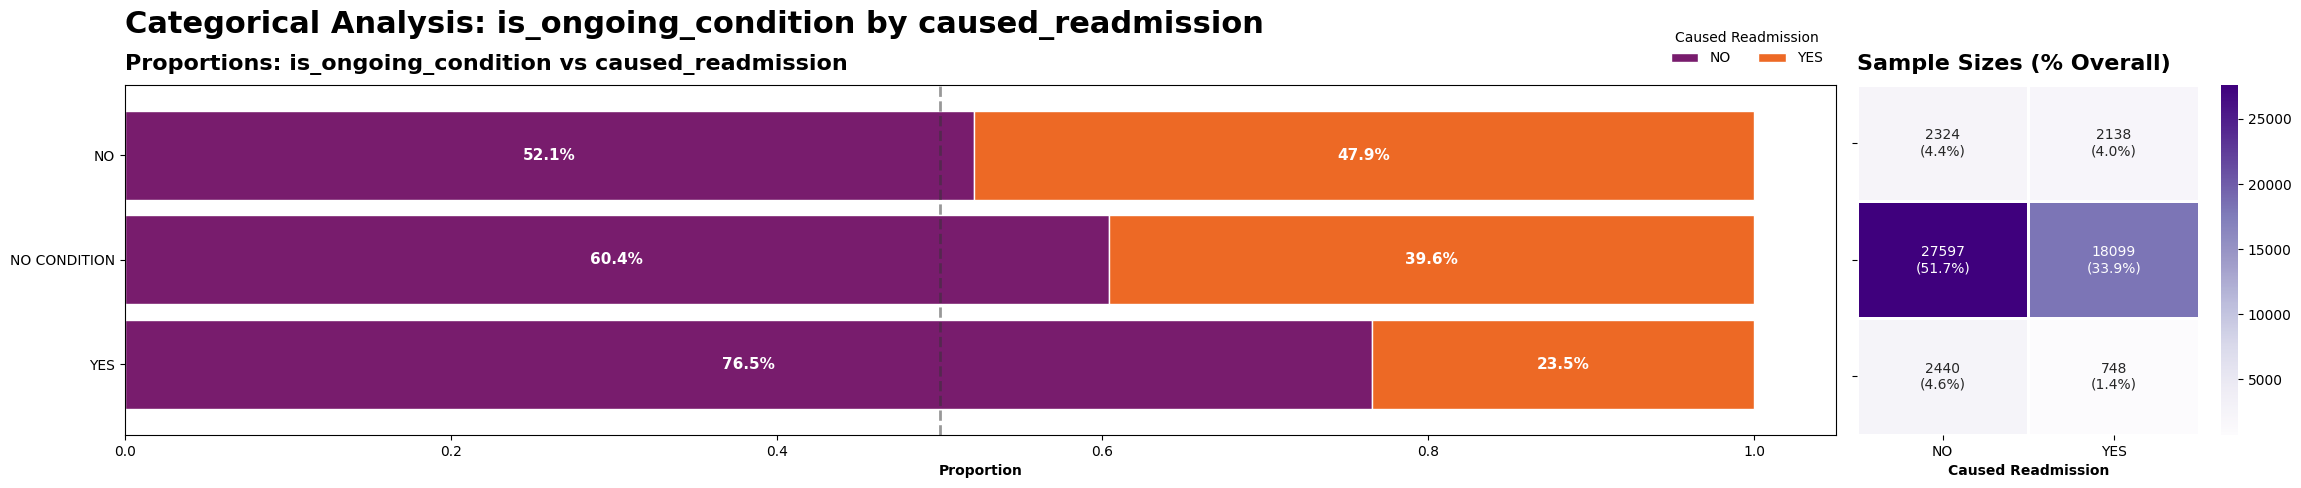

In [117]:
plt.figure(figsize=(24,5))
P.plot_categorical(data,'is_ongoing_condition','caused_readmission')

In [119]:
temp = data[['is_ongoing_condition','caused_readmission']]
temp['is_ongoing_condition'] = data['is_ongoing_condition'].replace('NO CONDITION','CRIT').replace('NO','CRIT')

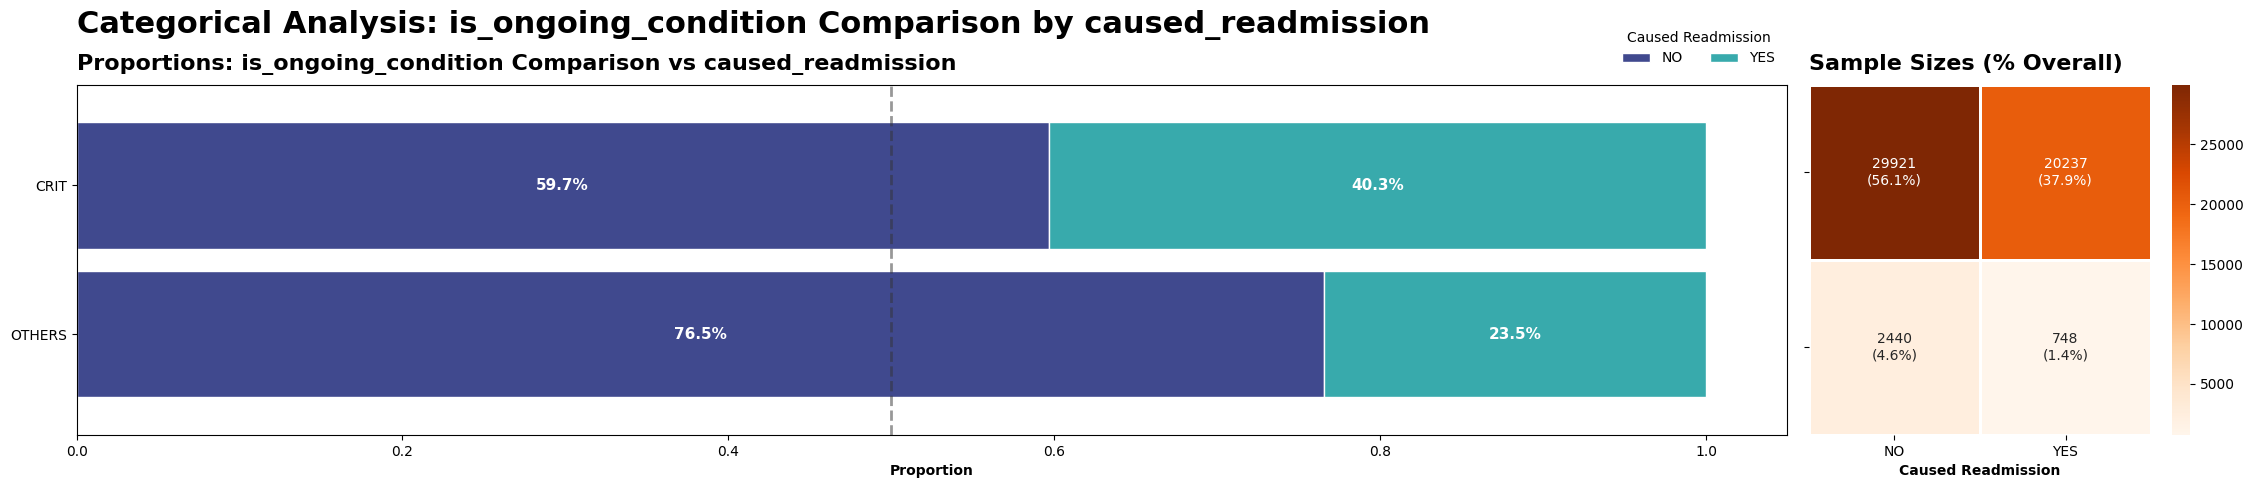

In [120]:
plt.figure(figsize=(24,5))
P.plot_masked_categorical(temp,'is_ongoing_condition','CRIT','caused_readmission')

In [121]:
is_ongoing_condition_mask = data['is_ongoing_condition'] == 'YES'
ct = pd.crosstab(is_ongoing_condition_mask,data['caused_readmission'])
S.test_association(ct)


--- Association Test: is_ongoing_condition vs caused_readmission ---
1. Verdict:    ✅ SIGNIFICANT Association (p=0.00000)
2. Strength:   Weak (Cramer's V = 0.082)
3. Balance:    Robust (High N)
------------------------------------------------------------


In [122]:
ct = pd.crosstab(data['is_ongoing_condition'],data['caused_readmission'])
S.test_association(ct)


--- Association Test: is_ongoing_condition vs caused_readmission ---
1. Verdict:    ✅ SIGNIFICANT Association (p=0.00000)
2. Strength:   Weak (Cramer's V = 0.094)
3. Balance:    Robust (High N)
------------------------------------------------------------


---
---
- ***By visuals we saw that `when there is no condition ongoing, then there is less chance of causing readmission` - by statistical test we can support this observation with weak strength, but large sample size makes it a reliable find***
---
---

**is_ongoin_careplan**

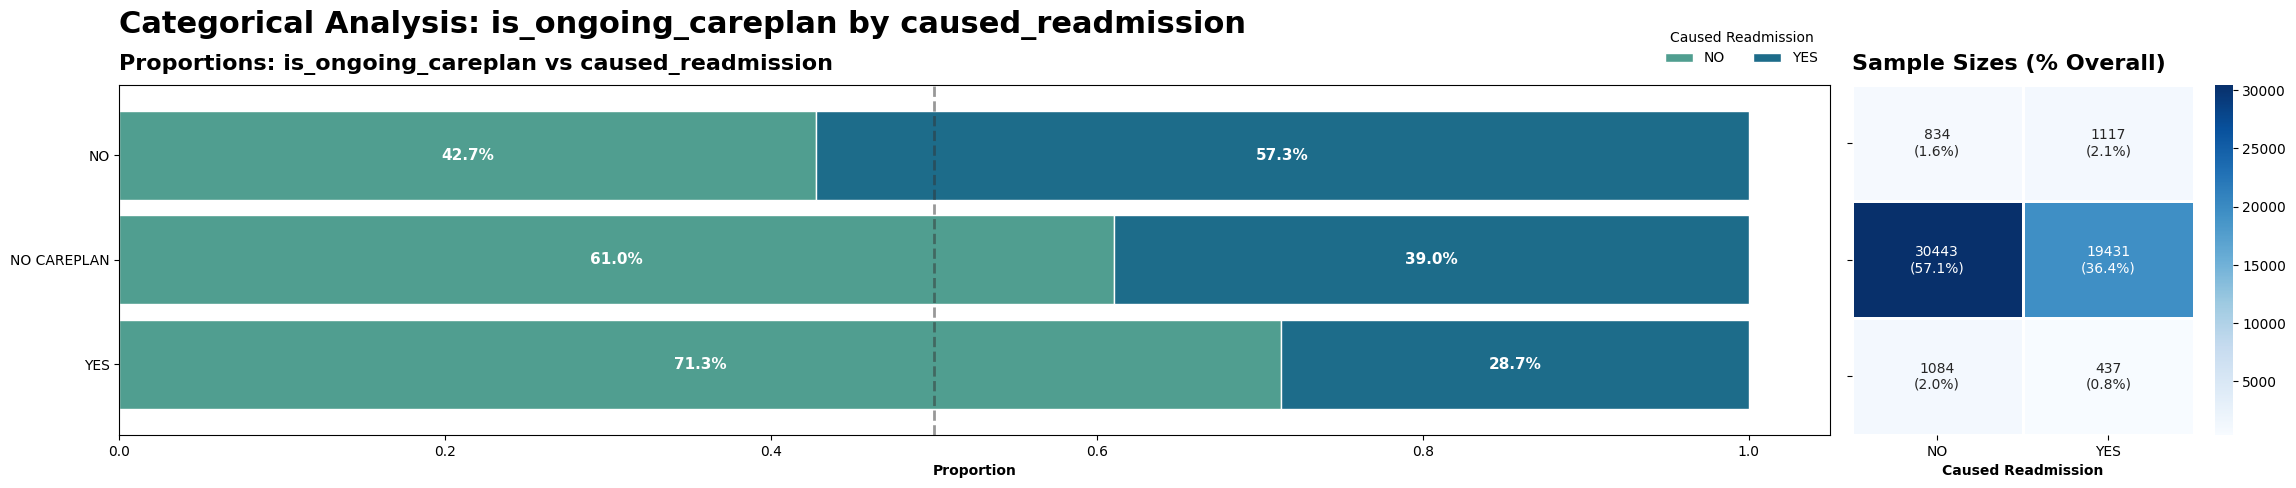

In [123]:
plt.figure(figsize=(24,5))
P.plot_categorical(data,'is_ongoing_careplan','caused_readmission')

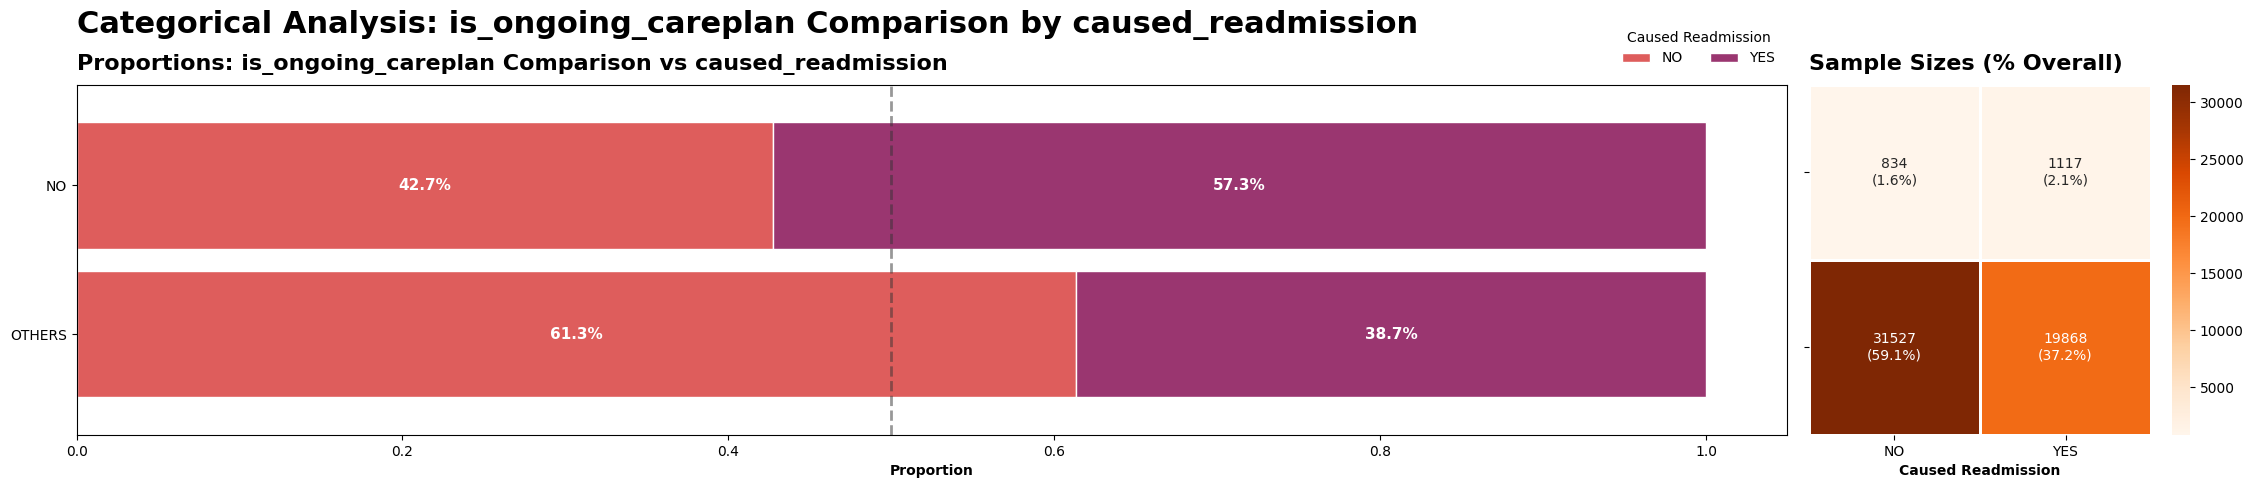

In [126]:
plt.figure(figsize=(24,5))
P.plot_masked_categorical(data,'is_ongoing_careplan','NO','caused_readmission')

In [127]:
is_ongoing_condition_mask = (data['is_ongoing_careplan']=='NO')
ct = pd.crosstab(is_ongoing_condition_mask,data['caused_readmission'])
S.test_association(ct)


--- Association Test: is_ongoing_careplan vs caused_readmission ---
1. Verdict:    ✅ SIGNIFICANT Association (p=0.00000)
2. Strength:   Weak (Cramer's V = 0.071)
3. Balance:    Robust (High N)
------------------------------------------------------------


In [128]:
ct = pd.crosstab(is_ongoing_condition_mask,data['caused_readmission'])
S.test_association(ct)


--- Association Test: is_ongoing_careplan vs caused_readmission ---
1. Verdict:    ✅ SIGNIFICANT Association (p=0.00000)
2. Strength:   Weak (Cramer's V = 0.071)
3. Balance:    Robust (High N)
------------------------------------------------------------


---
---
- ***By visuals we saw that `when there is no ongoing careplan, then there is more encounters in caused readmission` - by statistical test we can support this observation with weak strength, but large sample size makes it a reliable find***
---
---

**was_careplan**

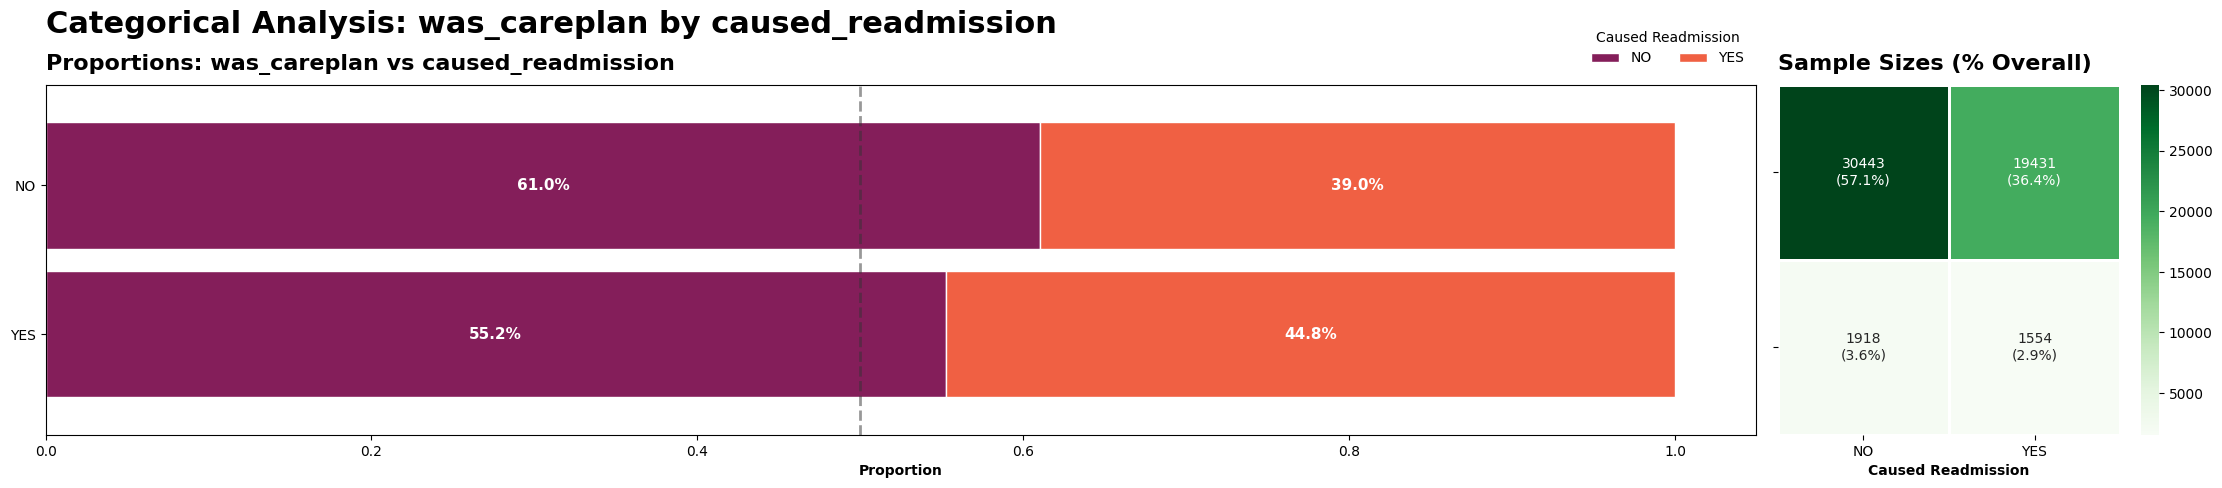

In [129]:
plt.figure(figsize=(24,5))
P.plot_categorical(data,'was_careplan','caused_readmission')

In [130]:
ct = pd.crosstab(data['was_careplan'],data['caused_readmission'])
S.test_association(ct)


--- Association Test: was_careplan vs caused_readmission ---
1. Verdict:    ✅ SIGNIFICANT Association (p=0.00000)
2. Strength:   Weak (Cramer's V = 0.029)
3. Balance:    Robust (High N)
------------------------------------------------------------


---
---
- ***By visuals we saw that `when there was any careplan, then there is a slightly more chance of not causing readmission` - by statistical test we can support this observation with weak strength, but large sample size makes it a reliable find***
---
---

**marital**

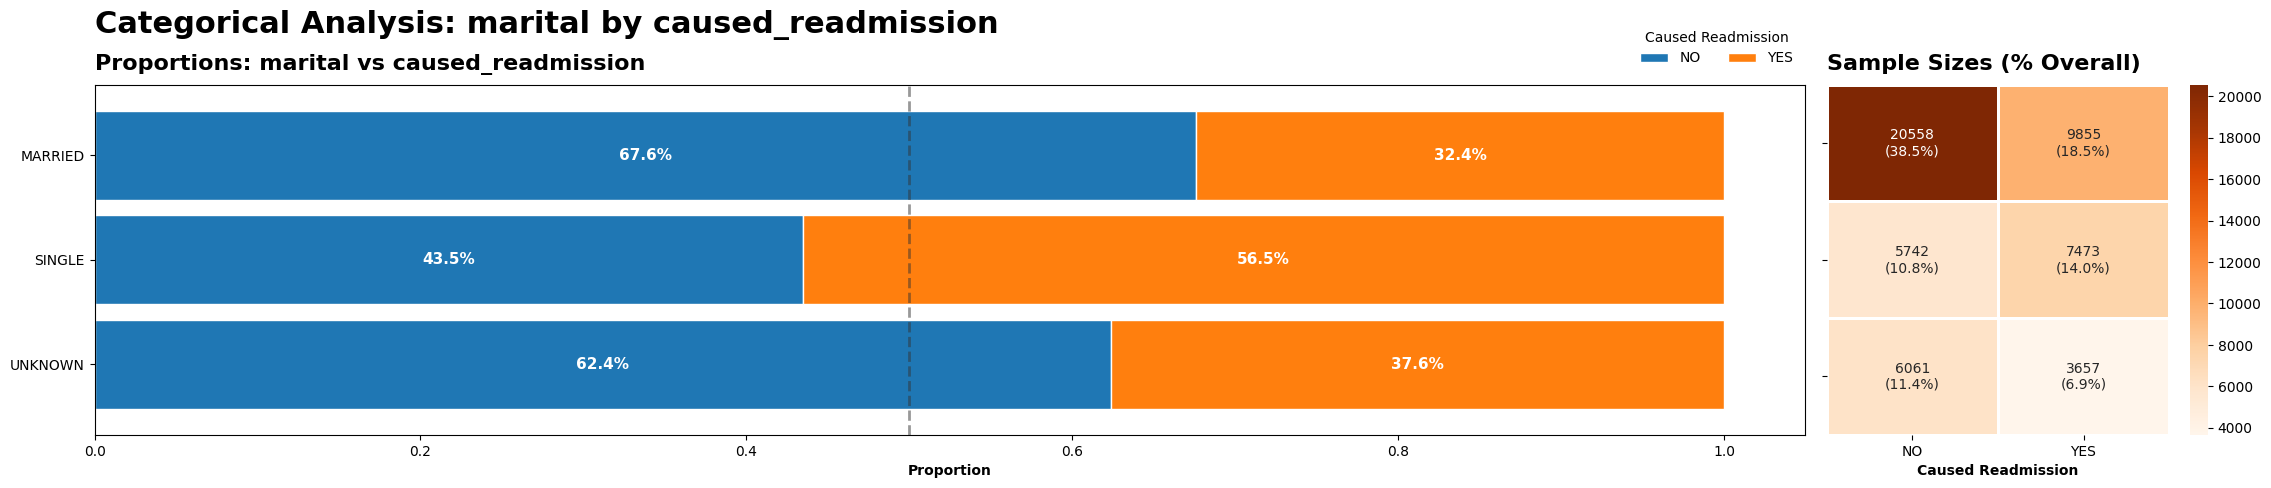

In [131]:
plt.figure(figsize=(24,5))
P.plot_categorical(data,'marital','caused_readmission')

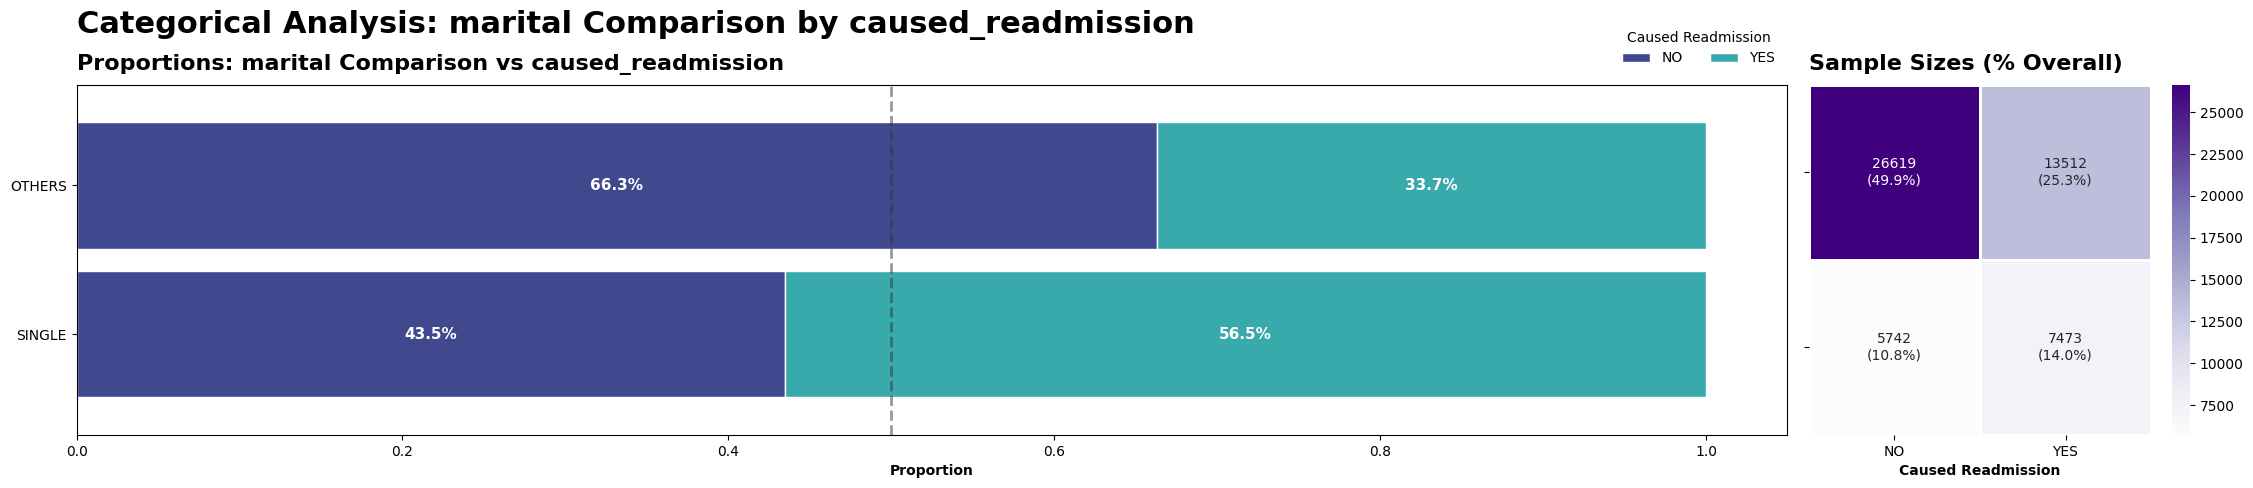

In [132]:
plt.figure(figsize=(24,5))
P.plot_masked_categorical(data,'marital','SINGLE','caused_readmission')

In [135]:
marital_mask = data['marital'] == 'SINGLE'
ct = pd.crosstab(marital_mask,data['caused_readmission'])
S.test_association(ct)


--- Association Test: marital vs caused_readmission ---
1. Verdict:    ✅ SIGNIFICANT Association (p=0.00000)
2. Strength:   Moderate (Cramer's V = 0.202)
3. Balance:    Robust (High N)
------------------------------------------------------------


---
---
- ***By visuals we saw that `single marital status have a more causing readmission percentage compared to other marital types` - by statistical test we can support this observation with moderate strength, but large sample size makes it a reliable find***
---
---

**race**

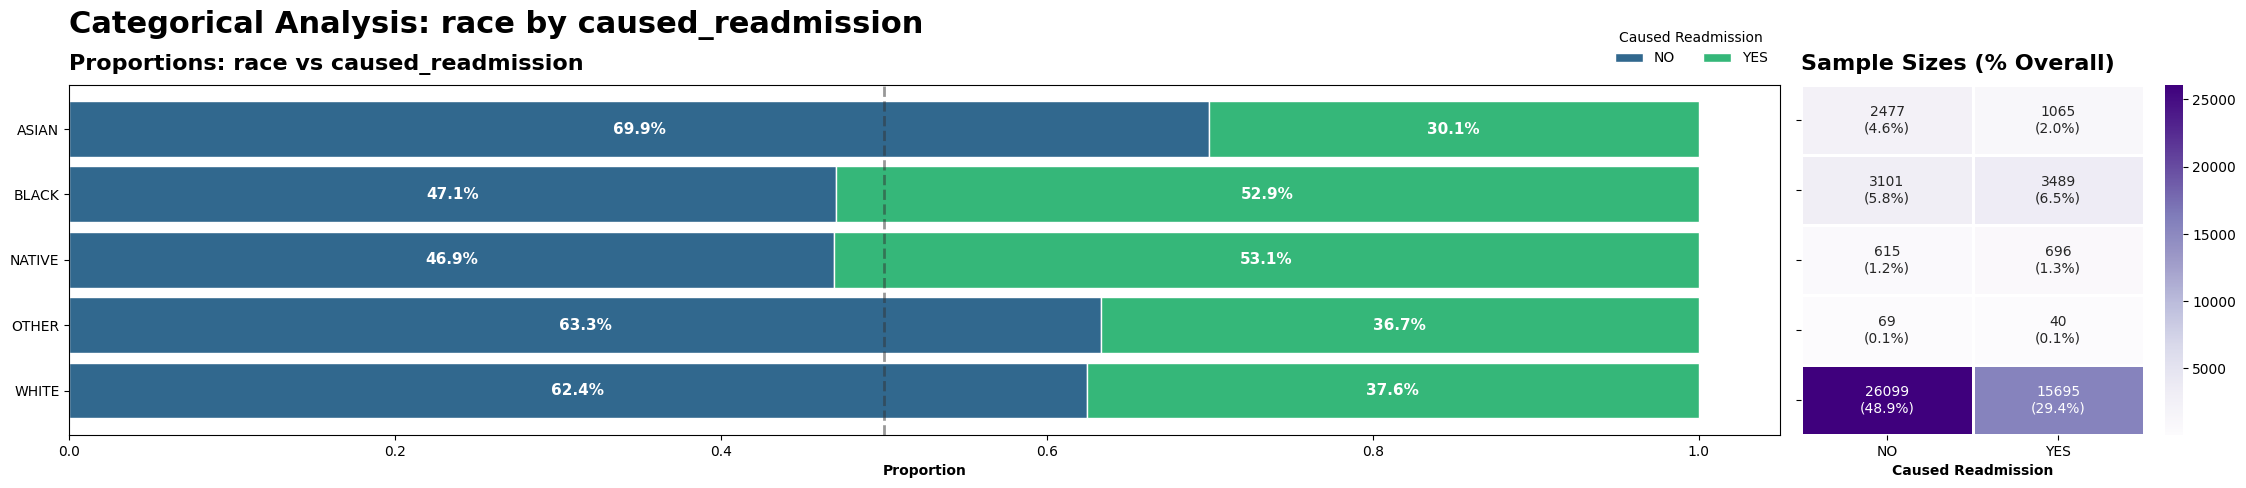

In [136]:
plt.figure(figsize=(24,5))
P.plot_categorical(data,'race','caused_readmission')

In [141]:
temp = data[['race','caused_readmission']]
temp['race'] = data['race'].replace('BLACK','CRIT').replace('NATIVE','CRIT')

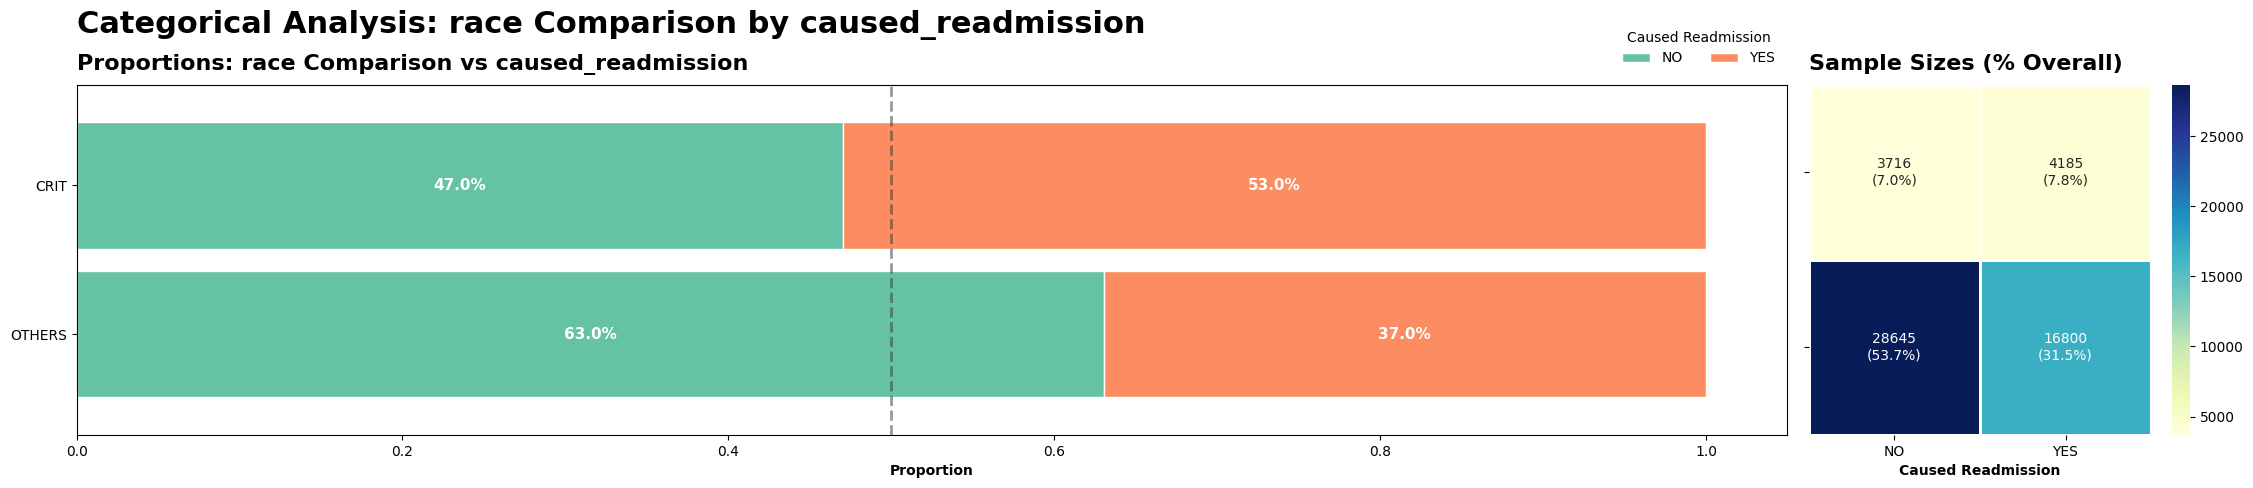

In [145]:
plt.figure(figsize=(24,5))
P.plot_masked_categorical(temp,'race','CRIT','caused_readmission')

In [146]:
race_mask = (data['race']=='BLACK')| (data['race']=='NATIVE')
ct = pd.crosstab(race_mask,data['caused_readmission'])
S.test_association(ct)


--- Association Test: race vs caused_readmission ---
1. Verdict:    ✅ SIGNIFICANT Association (p=0.00000)
2. Strength:   Moderate (Cramer's V = 0.116)
3. Balance:    Robust (High N)
------------------------------------------------------------


---
---
- ***By visuals we saw that `black and native race have a high percentage of causing readmission compared to other races` - by statistical test we can support this observation with moderate strength, but large sample size makes it a reliable find***
---
---

**ethnicity**

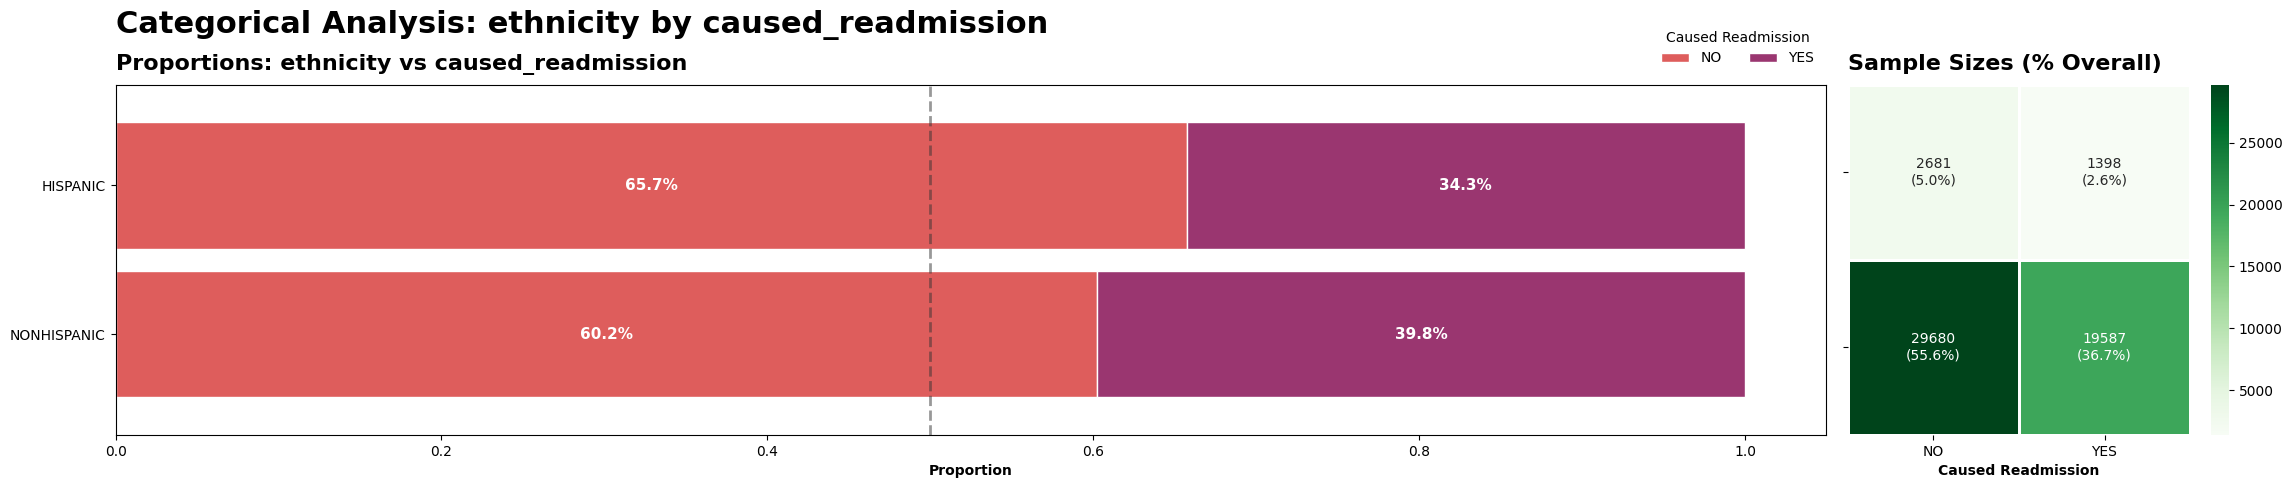

In [147]:
plt.figure(figsize=(24,5))
P.plot_categorical(data,'ethnicity','caused_readmission')

In [149]:
ct = pd.crosstab(data['ethnicity'],data['caused_readmission'])
S.test_association(ct)


--- Association Test: ethnicity vs caused_readmission ---
1. Verdict:    ✅ SIGNIFICANT Association (p=0.00000)
2. Strength:   Weak (Cramer's V = 0.030)
3. Balance:    Robust (High N)
------------------------------------------------------------


---
---
- ***By visuals we saw that `non hispanic ethnicity is showing a slighly high percentage in causing readmission` - by statistical test we can support this observation with weak strength, but large sample size makes it a reliable find***
---
---

**patient_gender**

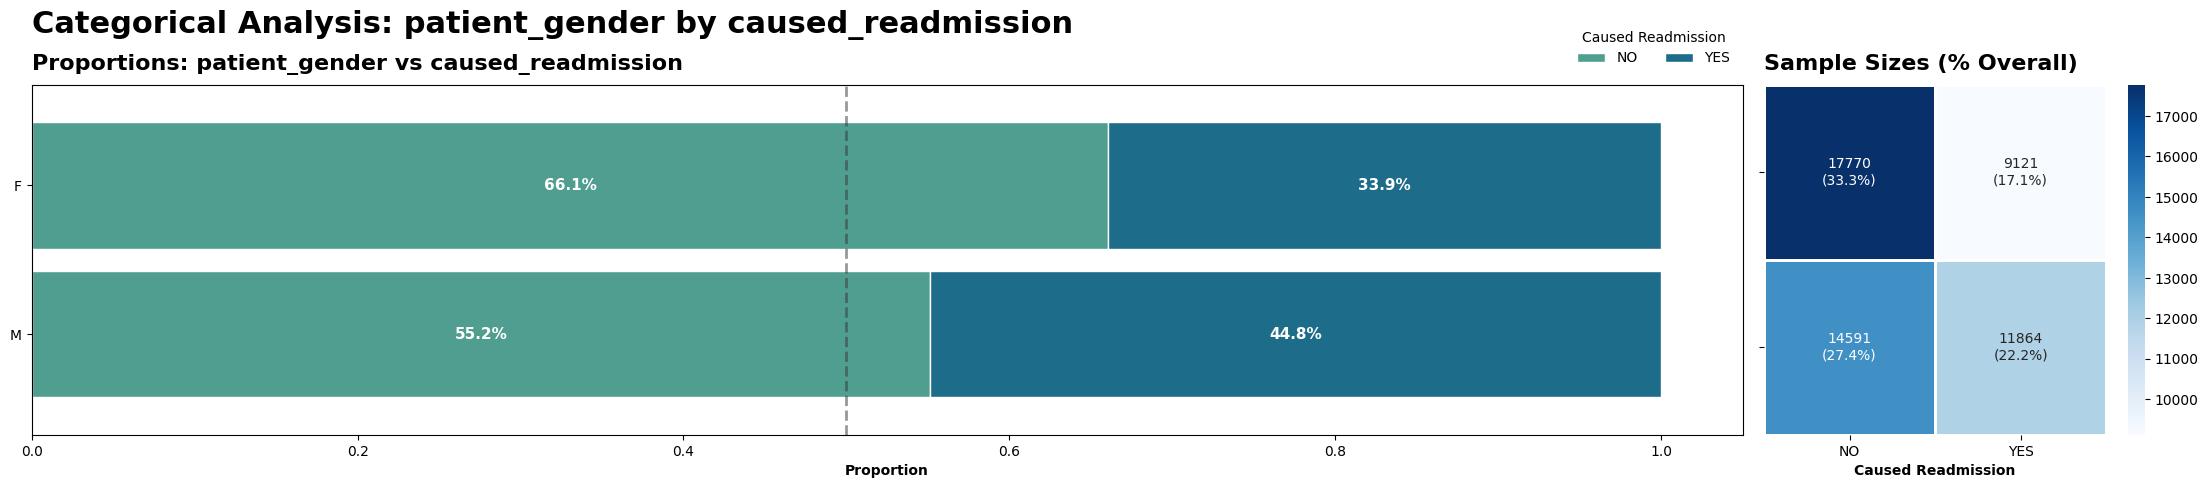

In [150]:
plt.figure(figsize=(24,5))
P.plot_categorical(data,'patient_gender','caused_readmission')

In [151]:
ct = pd.crosstab(data['patient_gender'],data['caused_readmission'])
S.test_association(ct)


--- Association Test: patient_gender vs caused_readmission ---
1. Verdict:    ✅ SIGNIFICANT Association (p=0.00000)
2. Strength:   Moderate (Cramer's V = 0.112)
3. Balance:    Robust (High N)
------------------------------------------------------------


---
---
- ***By visuals we saw that `male patient gender have slighly more percentage in causing readmission` - by statistical test we can support this observation with moderate strength, but large sample size makes it a reliable find***
---
---

**provider_gender**

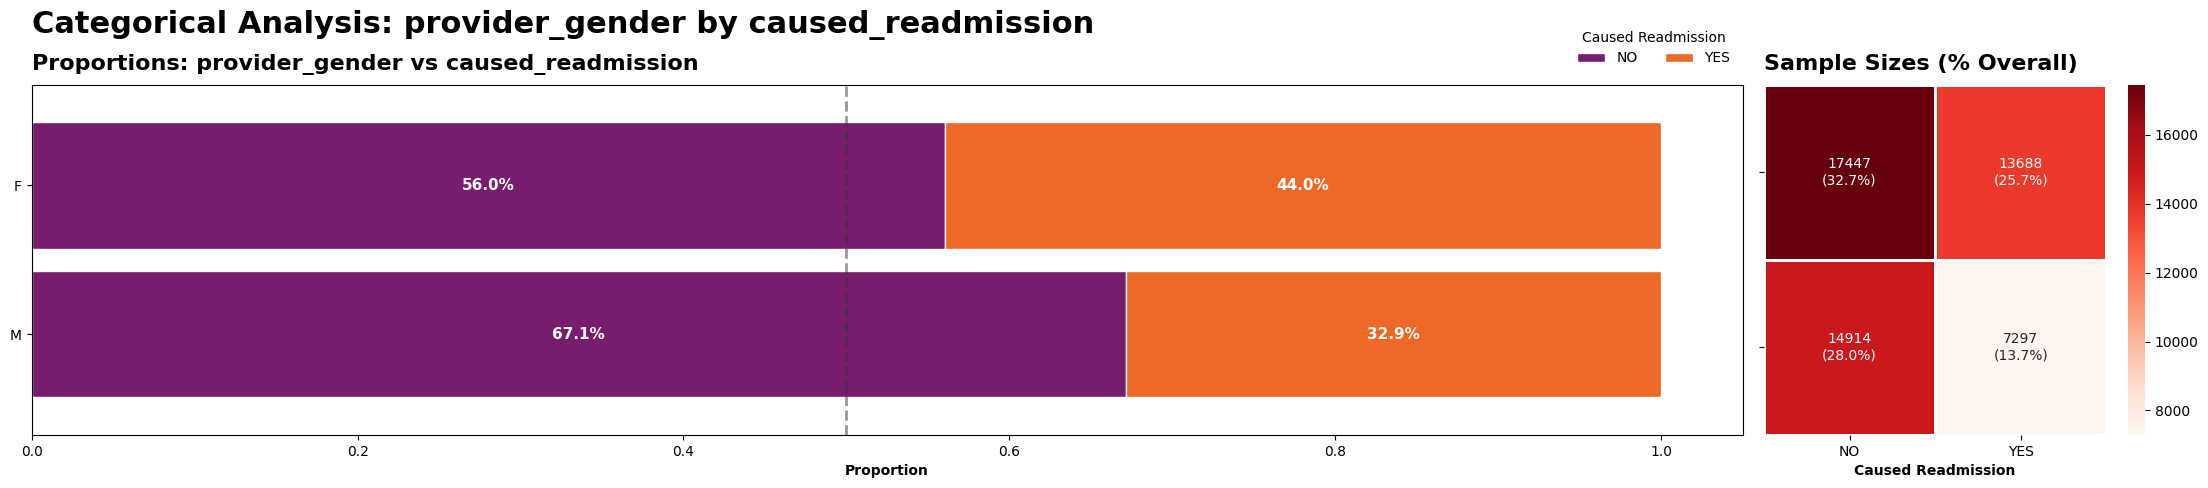

In [152]:
plt.figure(figsize=(24,5))
P.plot_categorical(data,'provider_gender','caused_readmission')

In [153]:
ct = pd.crosstab(data['provider_gender'],data['caused_readmission'])
S.test_association(ct)


--- Association Test: provider_gender vs caused_readmission ---
1. Verdict:    ✅ SIGNIFICANT Association (p=0.00000)
2. Strength:   Moderate (Cramer's V = 0.112)
3. Balance:    Robust (High N)
------------------------------------------------------------


---
---
- ***By visuals we saw that `female provider gender have slightly more percentage in causing readmission` - by statistical test we can support this observation with moderate strength, but large sample size makes it a reliable find***
---
---

***NUMERICAL COLUMNS WITH `caused_readmission COLUMN***

**encounter_duration**

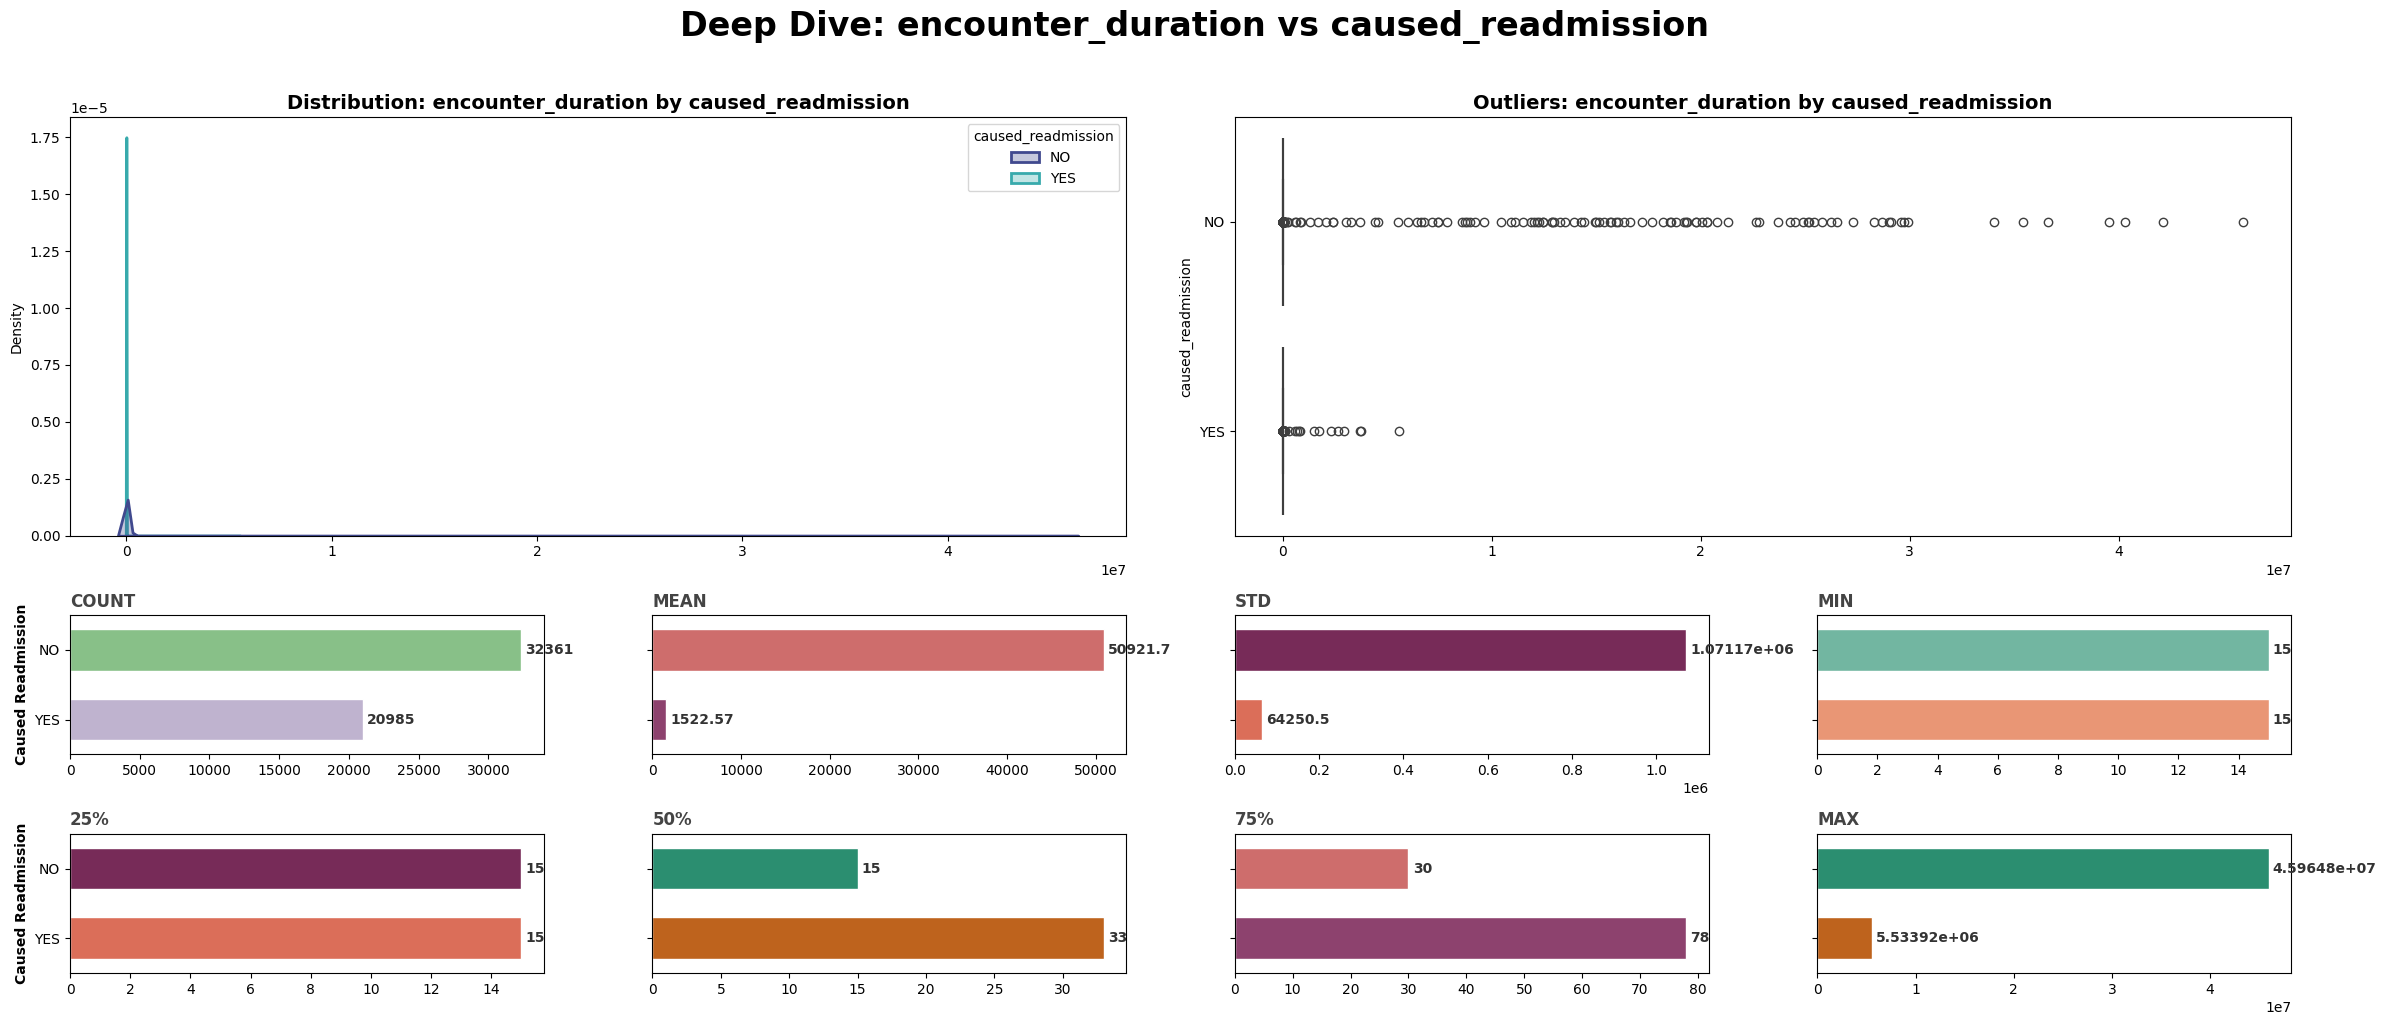

In [154]:
plt.figure(figsize=(24,10))
P.plot_numeric(data,'encounter_duration','caused_readmission')

In [155]:
S.compare_means(data,'caused_readmission','encounter_duration','YES')


--- Comparing 'encounter_duration' by 'caused_readmission' (YES vs Others) ---
1. Verdict:    ✅ SIGNIFICANT difference (p=0.00000)
2. Strength:   Negligible (Cohen's d = -0.059)
3. Balance:    Robust (High N) (n=20985 vs n=32361)
------------------------------------------------------------


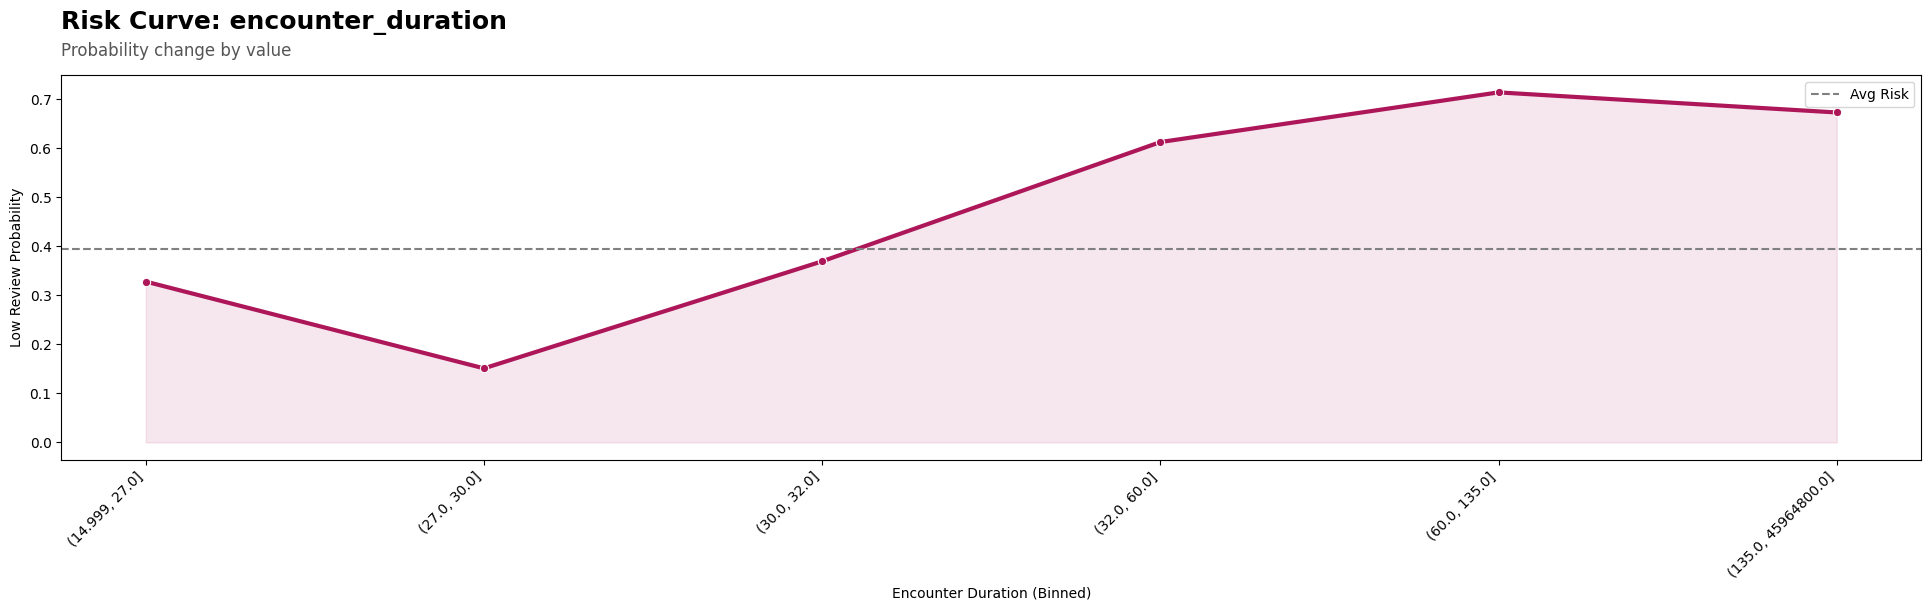

In [156]:
plt.figure(figsize=(24,5))
P.plot_risk_by_bins(data,'encounter_duration','caused_readmission',bins = 10)

In [162]:
duration_groups = pd.cut(data['encounter_duration'], 
                         bins=[-1, 27, 32, float('inf')], 
                         labels=['Short', 'Ideal', 'Long'])

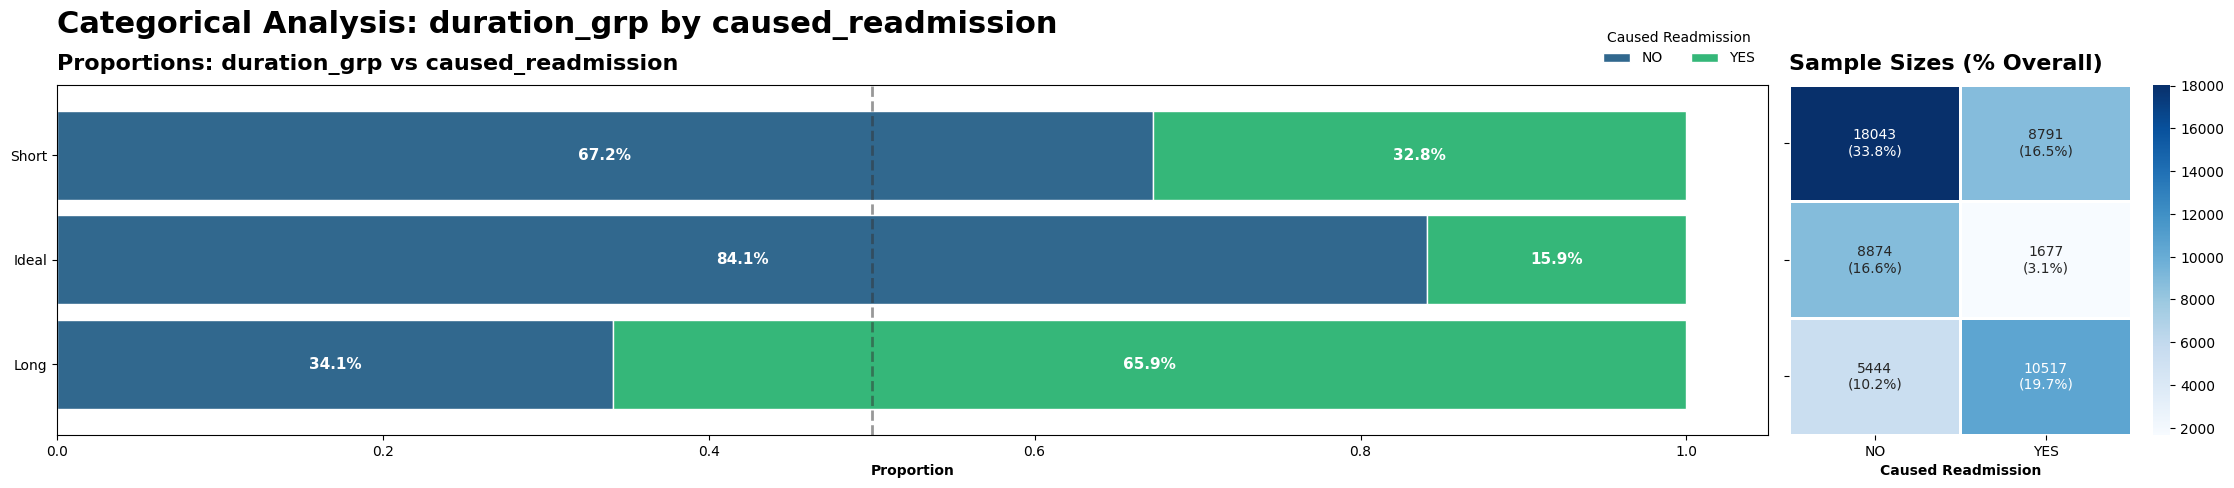

In [163]:
plt.figure(figsize=(24,5))
P.plot_categorical(data.assign(duration_grp = duration_groups),'duration_grp','caused_readmission')

In [166]:
ct = pd.crosstab(duration_groups,data['caused_readmission'])
S.test_association(ct)


--- Association Test: encounter_duration vs caused_readmission ---
1. Verdict:    ✅ SIGNIFICANT Association (p=0.00000)
2. Strength:   Strong (Cramer's V = 0.378)
3. Balance:    Robust (High N)
------------------------------------------------------------


---
---
- ***By visuals we saw that `long encounter duration(>32) have highest percentage of causing readmission` - by statistical test we can support this observation with strong strength, and large sample size makes it a reliable find***
---
---

***avg_procedure_cost***

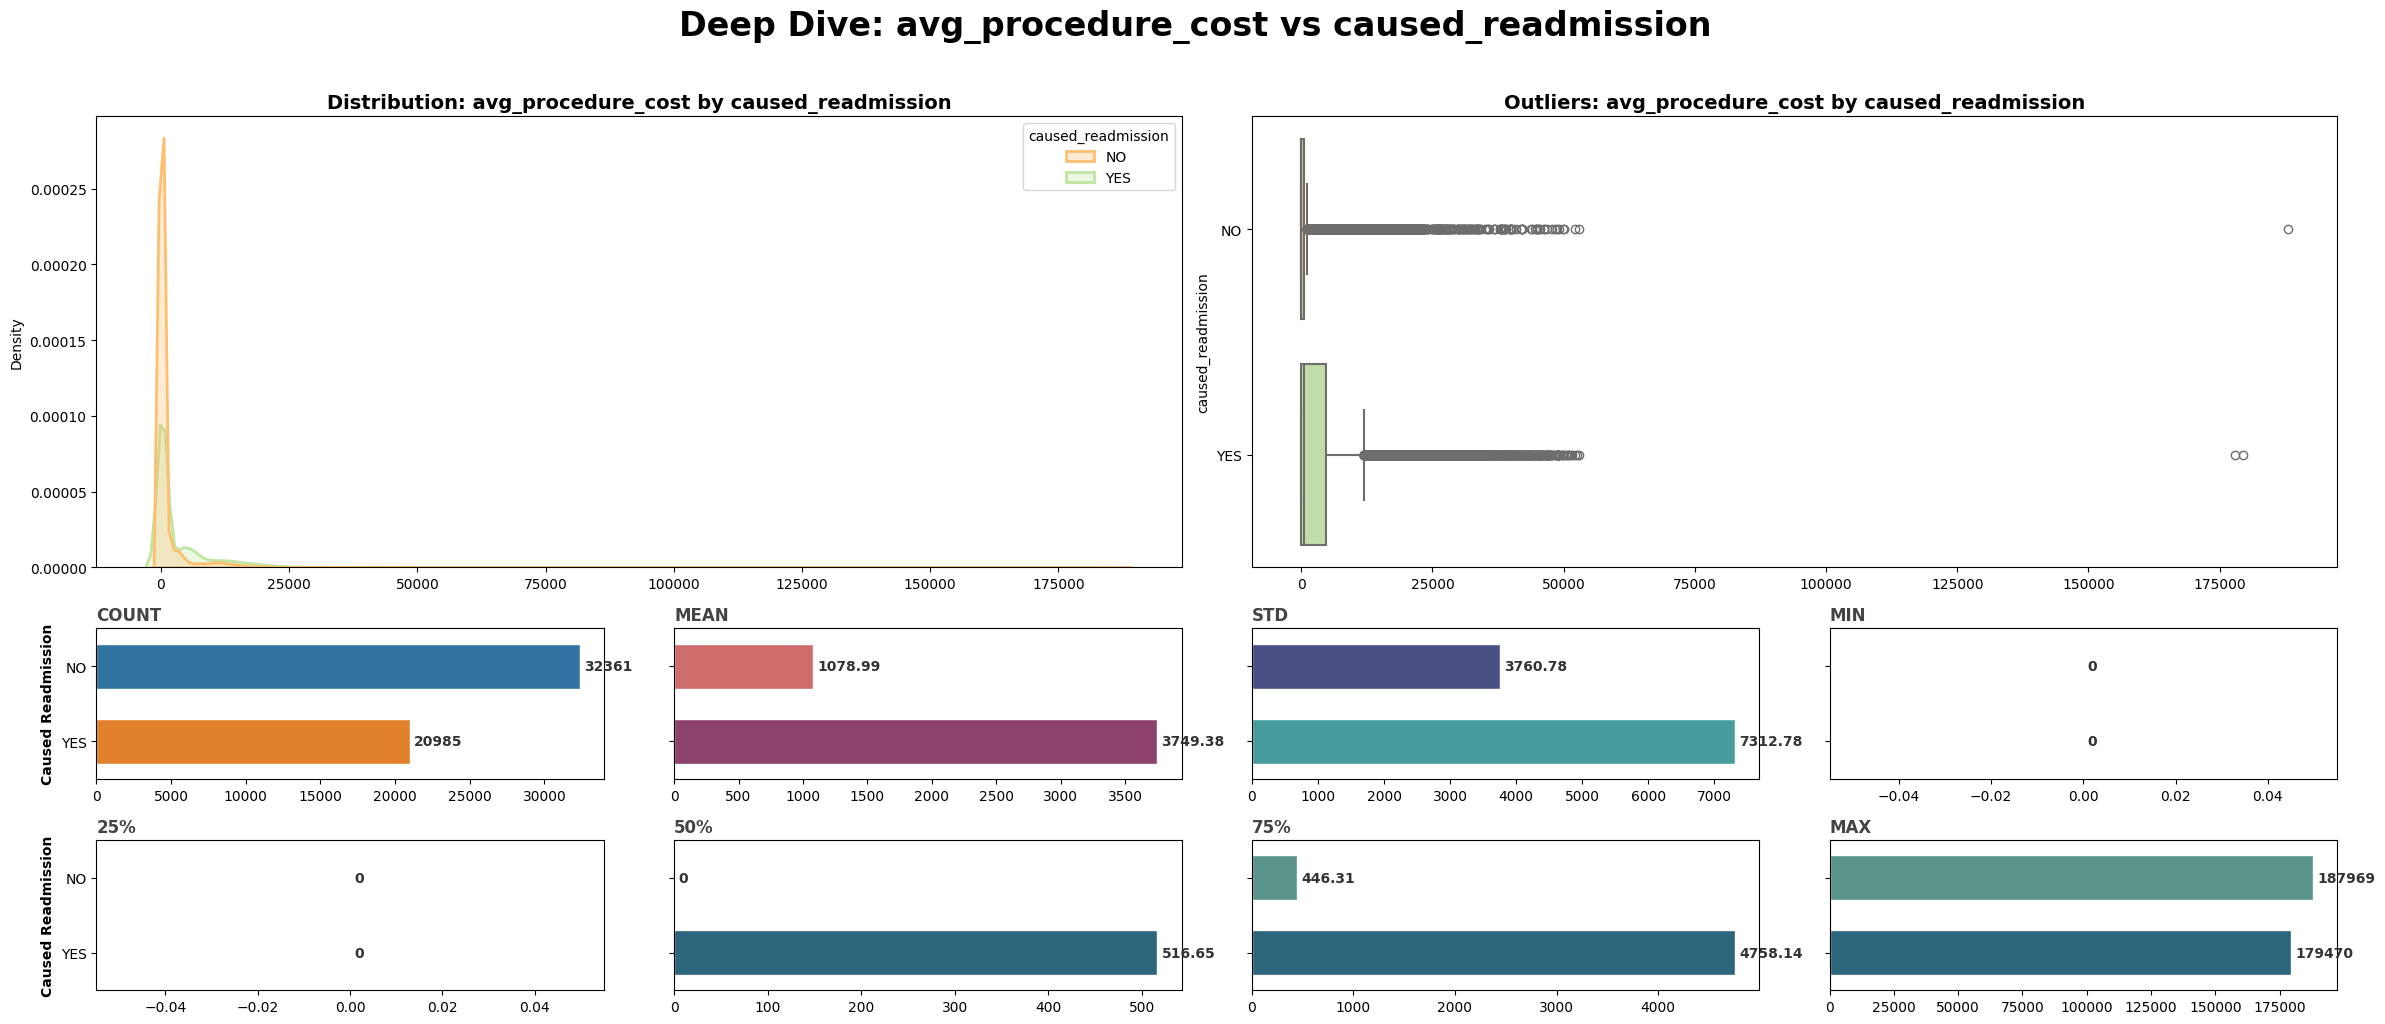

In [167]:
plt.figure(figsize=(24,10))
P.plot_numeric(data,'avg_procedure_cost','caused_readmission')

In [168]:
S.compare_means(data,'caused_readmission','avg_procedure_cost','YES')


--- Comparing 'avg_procedure_cost' by 'caused_readmission' (YES vs Others) ---
1. Verdict:    ✅ SIGNIFICANT difference (p=0.00000)
2. Strength:   Small/Weak (Cohen's d = 0.491)
3. Balance:    Robust (High N) (n=20985 vs n=32361)
------------------------------------------------------------


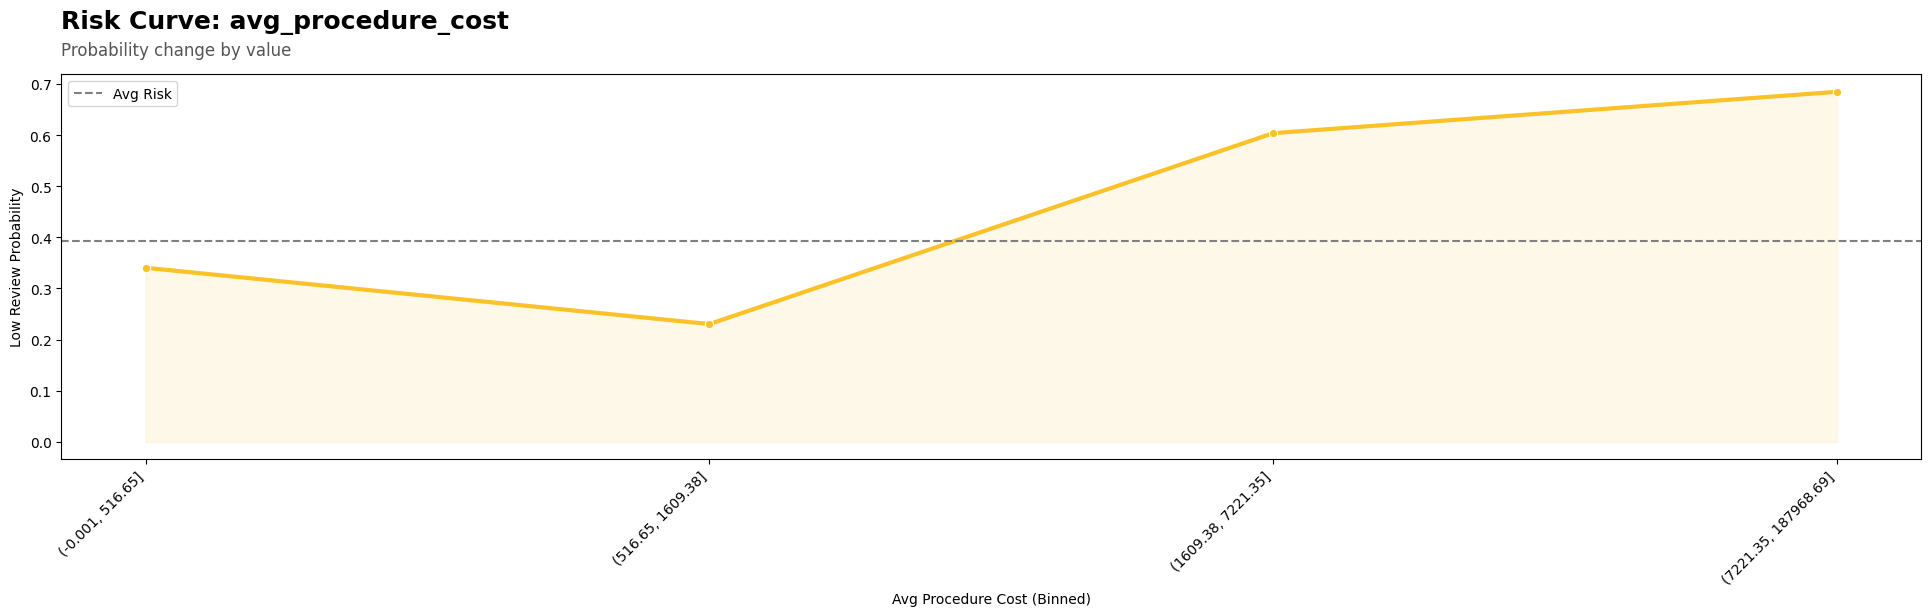

In [169]:
plt.figure(figsize=(24,5))
P.plot_risk_by_bins(data,'avg_procedure_cost','caused_readmission',bins = 10)

In [172]:
avg_procedure_cost_groups = pd.cut(data['avg_procedure_cost'], 
                         bins=[-1, 1610, float('inf')], 
                         labels=['Low', 'High'])

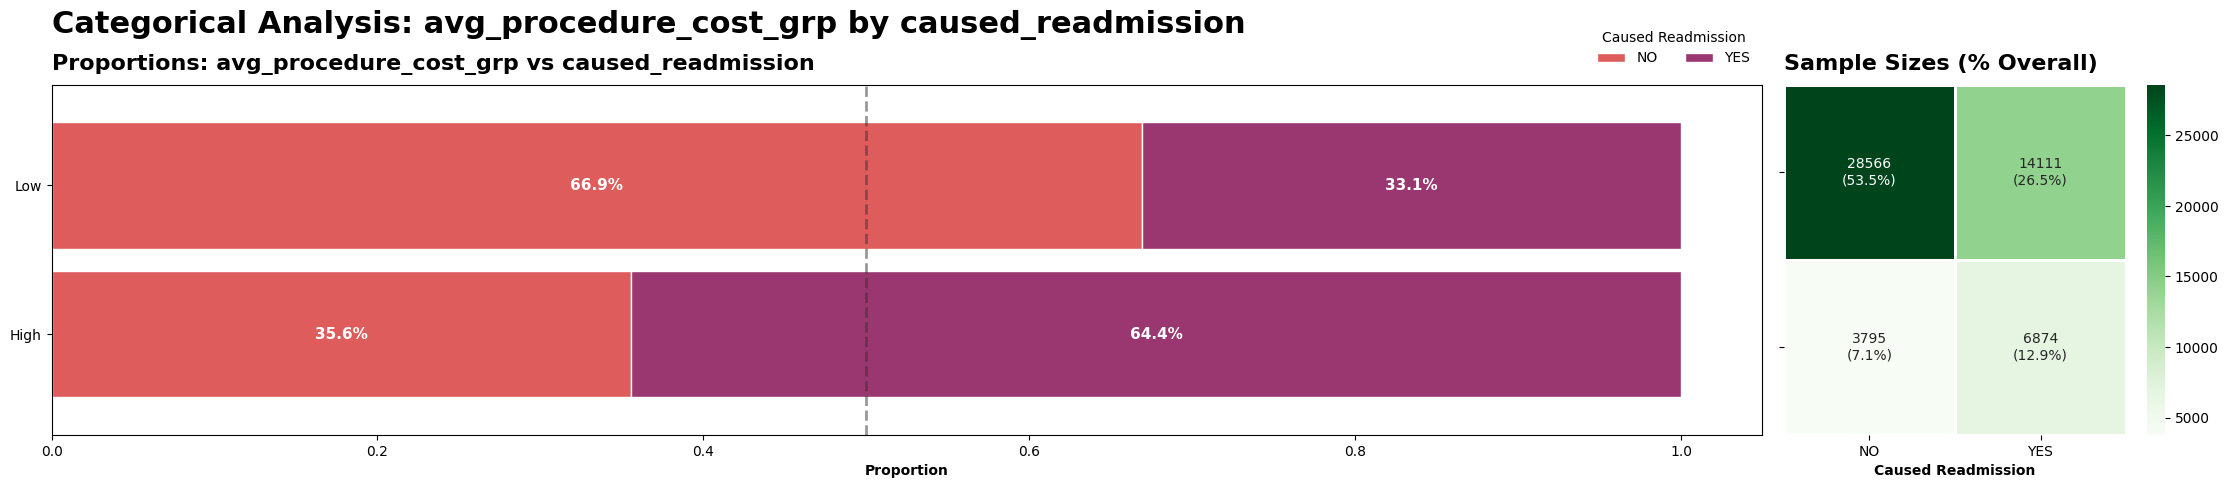

In [174]:
plt.figure(figsize=(24,5))
P.plot_categorical(data.assign(avg_procedure_cost_grp = avg_procedure_cost_groups),'avg_procedure_cost_grp','caused_readmission')

In [175]:
ct = pd.crosstab(avg_procedure_cost_groups,data['caused_readmission'])
S.test_association(ct)


--- Association Test: avg_procedure_cost vs caused_readmission ---
1. Verdict:    ✅ SIGNIFICANT Association (p=0.00000)
2. Strength:   Moderate (Cramer's V = 0.257)
3. Balance:    Robust (High N)
------------------------------------------------------------


---
---
- ***By visuals we saw that `avg procedure cost below 1610, have more chance in not causing readmission compared to price more than that` - by statistical test we can support this observation with moderate strength, but large sample size makes it a reliable find***
---
---

**avg_base_medicine_cost**

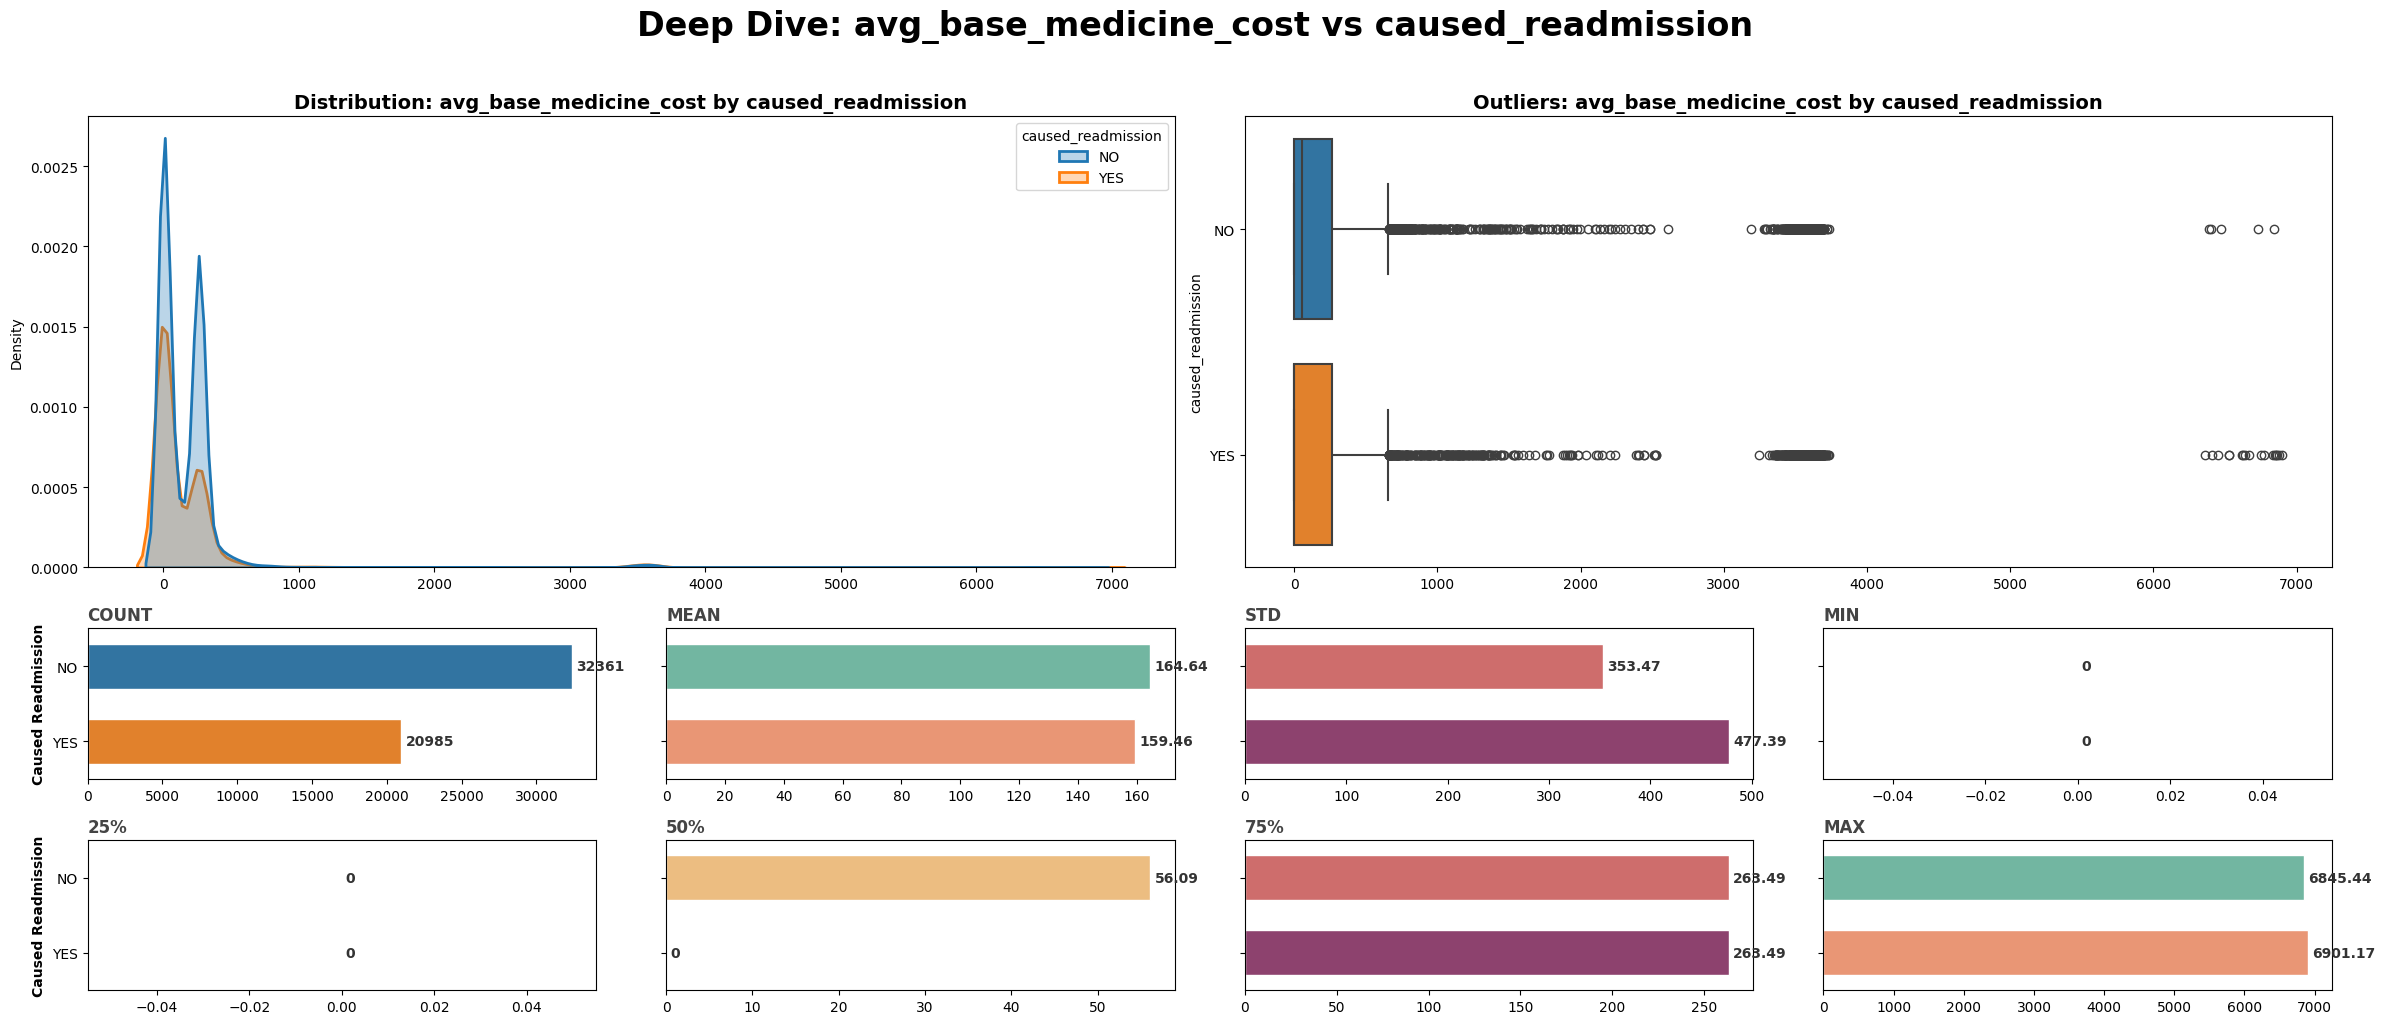

In [176]:
plt.figure(figsize=(24,10))
P.plot_numeric(data,'avg_base_medicine_cost','caused_readmission')

In [177]:
S.compare_means(data,'caused_readmission','avg_base_medicine_cost','YES')


--- Comparing 'avg_base_medicine_cost' by 'caused_readmission' (YES vs Others) ---
1. Verdict:    ❌ NOT Significant (p=0.15052)
2. Strength:   Negligible (Cohen's d = -0.013)
3. Balance:    Robust (High N) (n=20985 vs n=32361)
------------------------------------------------------------


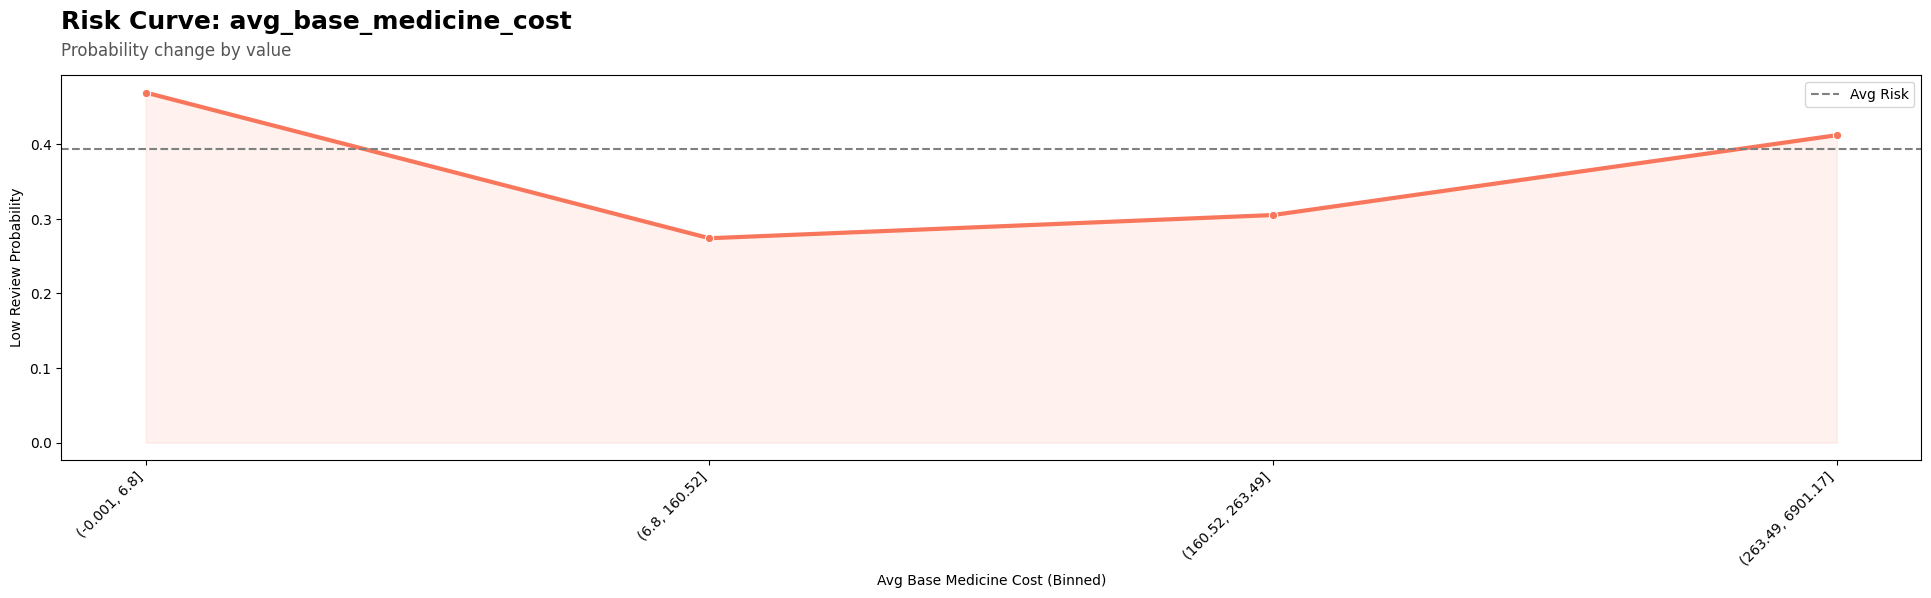

In [179]:
plt.figure(figsize=(24,5))
P.plot_risk_by_bins(data,'avg_base_medicine_cost','caused_readmission',bins = 10)

In [183]:
base_medicine_cost_groups = pd.cut(data['avg_base_medicine_cost'], 
                         bins=[-1, 7,264,float('inf')], 
                         labels=['Low','Standard','High'])
base_medicine_cost_groups = base_medicine_cost_groups.replace({
    'Low': 'Extreme', 
    'High': 'Extreme'
})

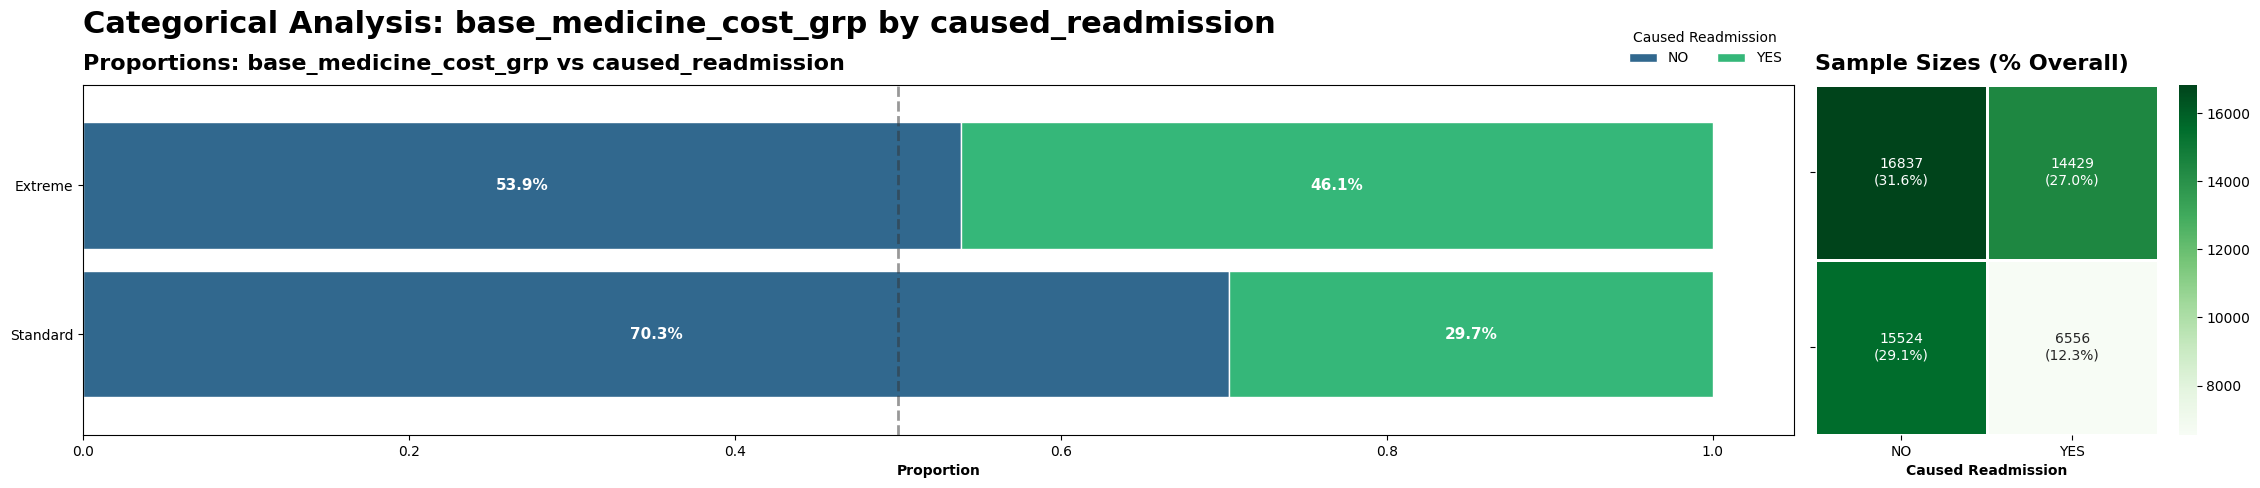

In [184]:
plt.figure(figsize=(24,5))
P.plot_categorical(data.assign(base_medicine_cost_grp = base_medicine_cost_groups),'base_medicine_cost_grp','caused_readmission')

In [186]:
ct = pd.crosstab(base_medicine_cost_groups,data['caused_readmission'])
S.test_association(ct)


--- Association Test: avg_base_medicine_cost vs caused_readmission ---
1. Verdict:    ✅ SIGNIFICANT Association (p=0.00000)
2. Strength:   Moderate (Cramer's V = 0.166)
3. Balance:    Robust (High N)
------------------------------------------------------------


---
---
- ***By visuals we saw that `base medicine cost have crit range, lower base cost(<7) and higher base cost(>264) have higher chance of causing readmission compared to standard base cost` - by statistical test we can support this observation with moderate strength, but large sample size makes it a reliable find***
---
---

**avg_total_medicine_cost**

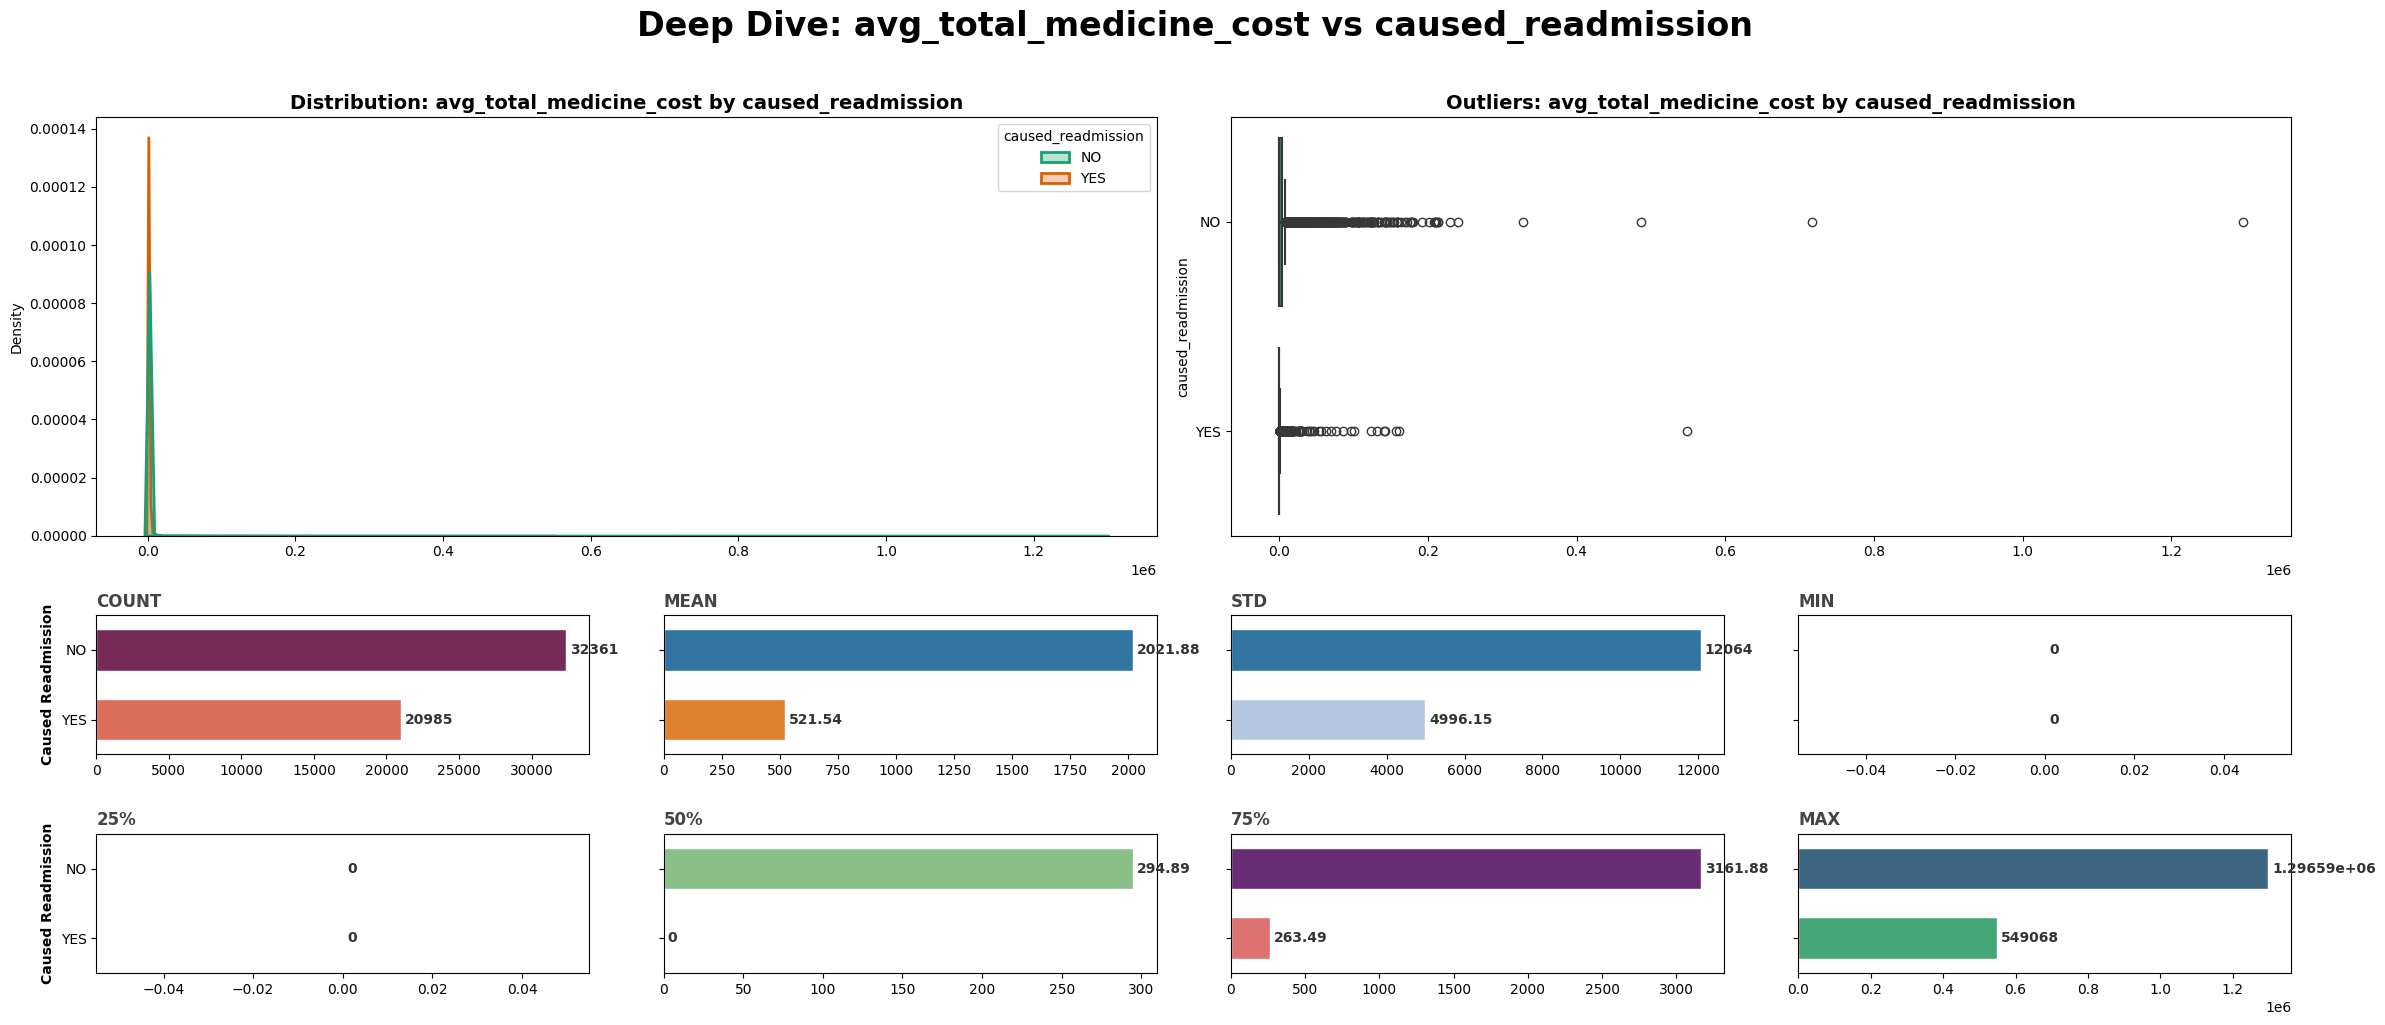

In [187]:
plt.figure(figsize=(24,10))
P.plot_numeric(data,'avg_total_medicine_cost','caused_readmission')

In [188]:
S.compare_means(data,'caused_readmission','avg_total_medicine_cost','YES')


--- Comparing 'avg_total_medicine_cost' by 'caused_readmission' (YES vs Others) ---
1. Verdict:    ✅ SIGNIFICANT difference (p=0.00000)
2. Strength:   Small/Weak (Cohen's d = -0.151)
3. Balance:    Robust (High N) (n=20985 vs n=32361)
------------------------------------------------------------


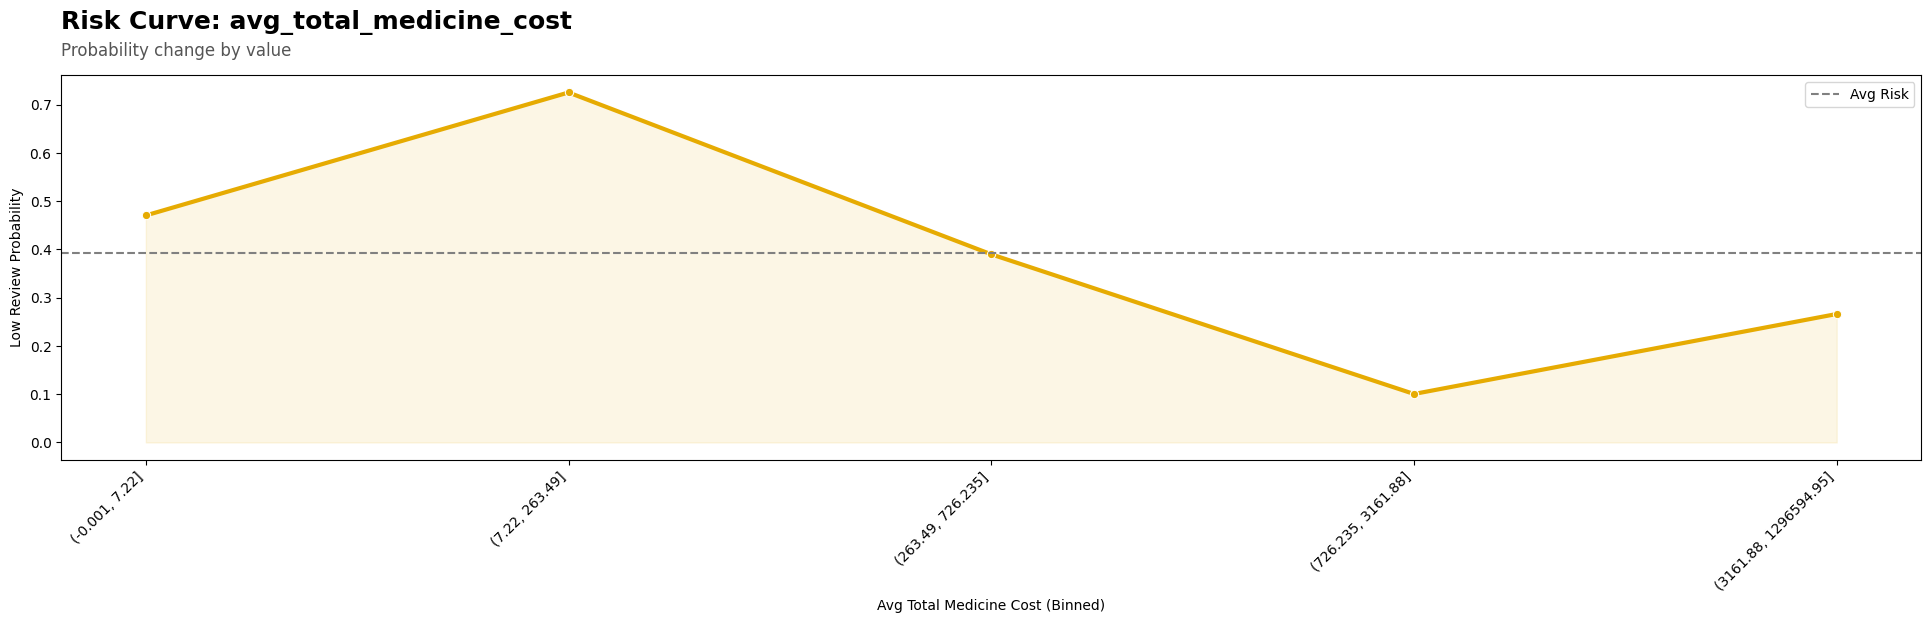

In [189]:
plt.figure(figsize=(24,5))
P.plot_risk_by_bins(data,'avg_total_medicine_cost','caused_readmission',bins = 10)

In [193]:
avg_total_medicine_cost_groups = pd.cut(data['avg_total_medicine_cost'], 
                         bins=[-1,727,float('inf')], 
                         labels=['Low','High'])

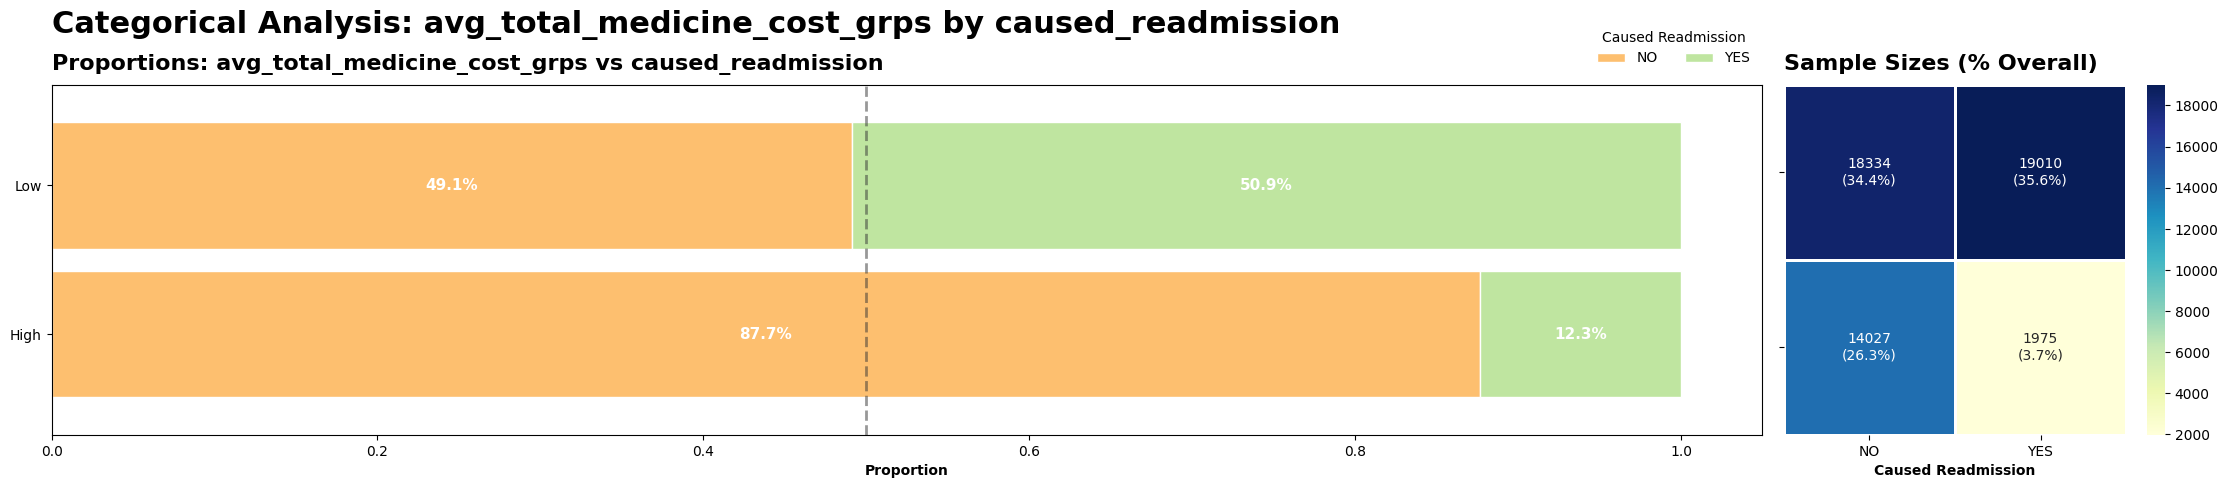

In [194]:
plt.figure(figsize=(24,5))
P.plot_categorical(data.assign(avg_total_medicine_cost_grps = avg_total_medicine_cost_groups),'avg_total_medicine_cost_grps','caused_readmission')

In [195]:
ct = pd.crosstab(avg_total_medicine_cost_groups,data['caused_readmission'])
S.test_association(ct)


--- Association Test: avg_total_medicine_cost vs caused_readmission ---
1. Verdict:    ✅ SIGNIFICANT Association (p=0.00000)
2. Strength:   Strong (Cramer's V = 0.362)
3. Balance:    Robust (High N)
------------------------------------------------------------


---
---
- ***By visuals we saw that `high total medicine cost(>727) have more than 85% chance for not causing readmission` - by statistical test we can support this observation with strong strength, but large sample size makes it a reliable find***
---
---

**age_as_2022**

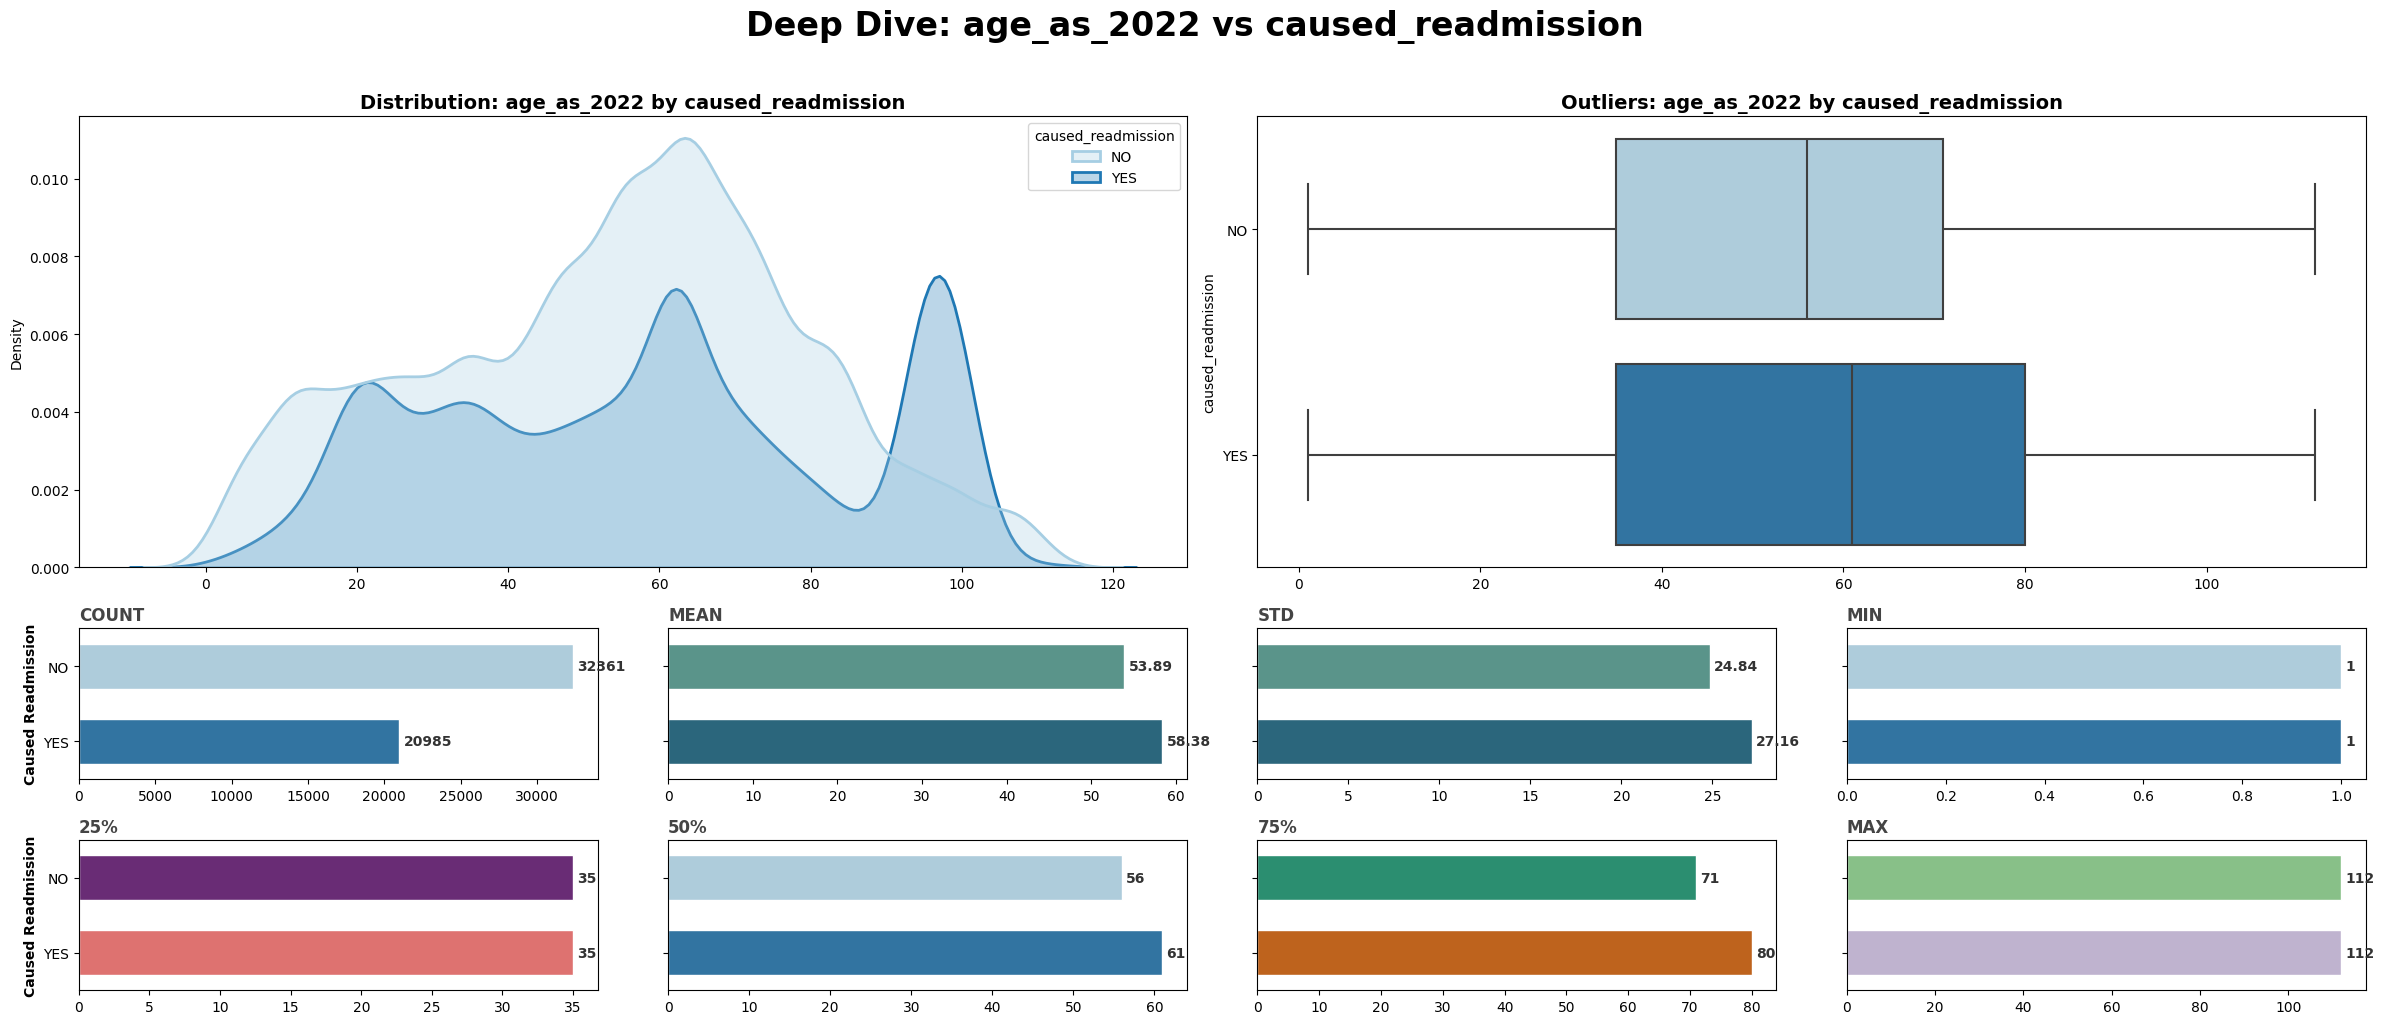

In [196]:
plt.figure(figsize=(24,10))
P.plot_numeric(data,'age_as_2022','caused_readmission')

In [197]:
S.compare_means(data,'caused_readmission','age_as_2022','YES')


--- Comparing 'age_as_2022' by 'caused_readmission' (YES vs Others) ---
1. Verdict:    ✅ SIGNIFICANT difference (p=0.00000)
2. Strength:   Small/Weak (Cohen's d = 0.174)
3. Balance:    Robust (High N) (n=20985 vs n=32361)
------------------------------------------------------------


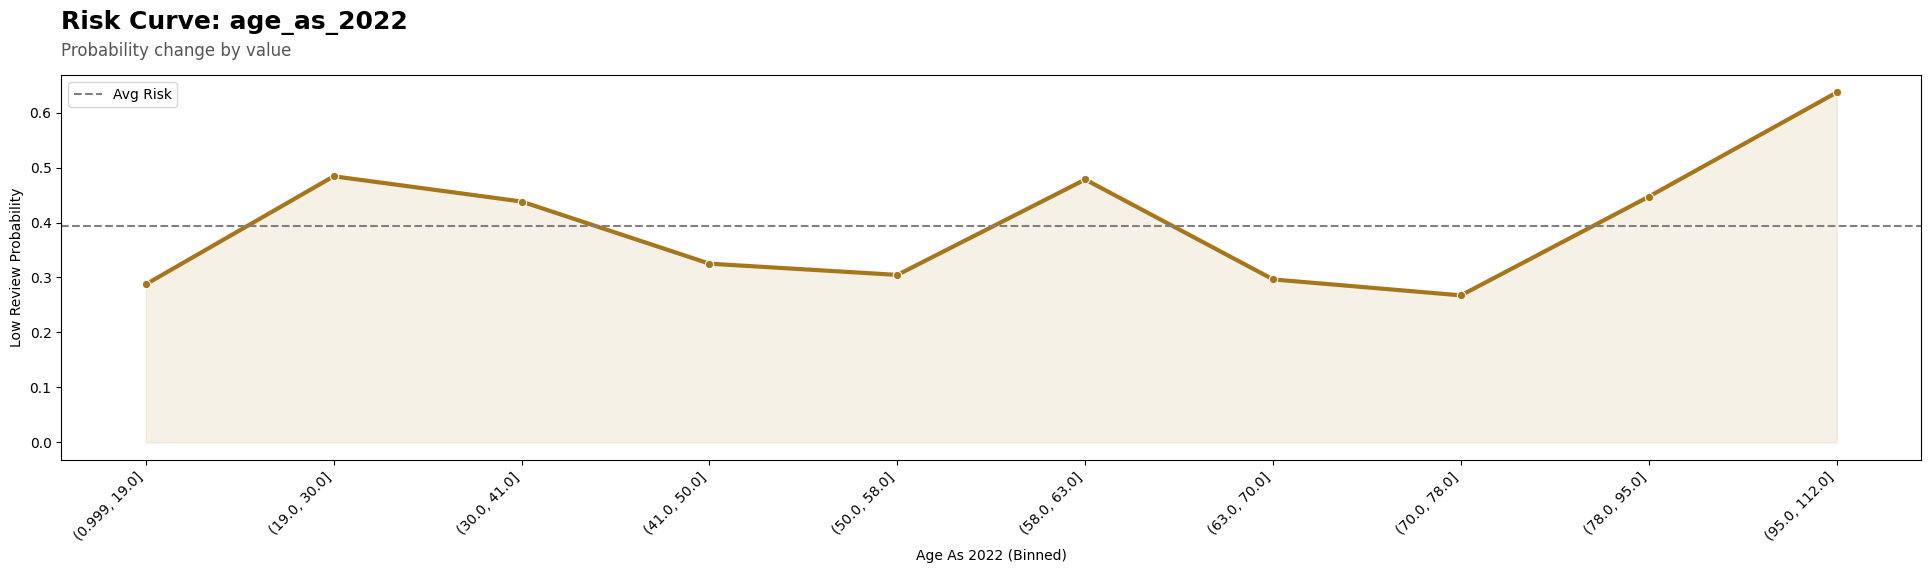

In [198]:
plt.figure(figsize=(24,5))
P.plot_risk_by_bins(data,'age_as_2022','caused_readmission',bins = 10)

In [204]:
age_groups = pd.cut(data['age_as_2022'], 
                         bins=[-1, 18, 50, 59, 65, 80, float('inf')], 
                         labels=['0-18', '19-50', '50-59', '59-65', '66-80', '80+'])

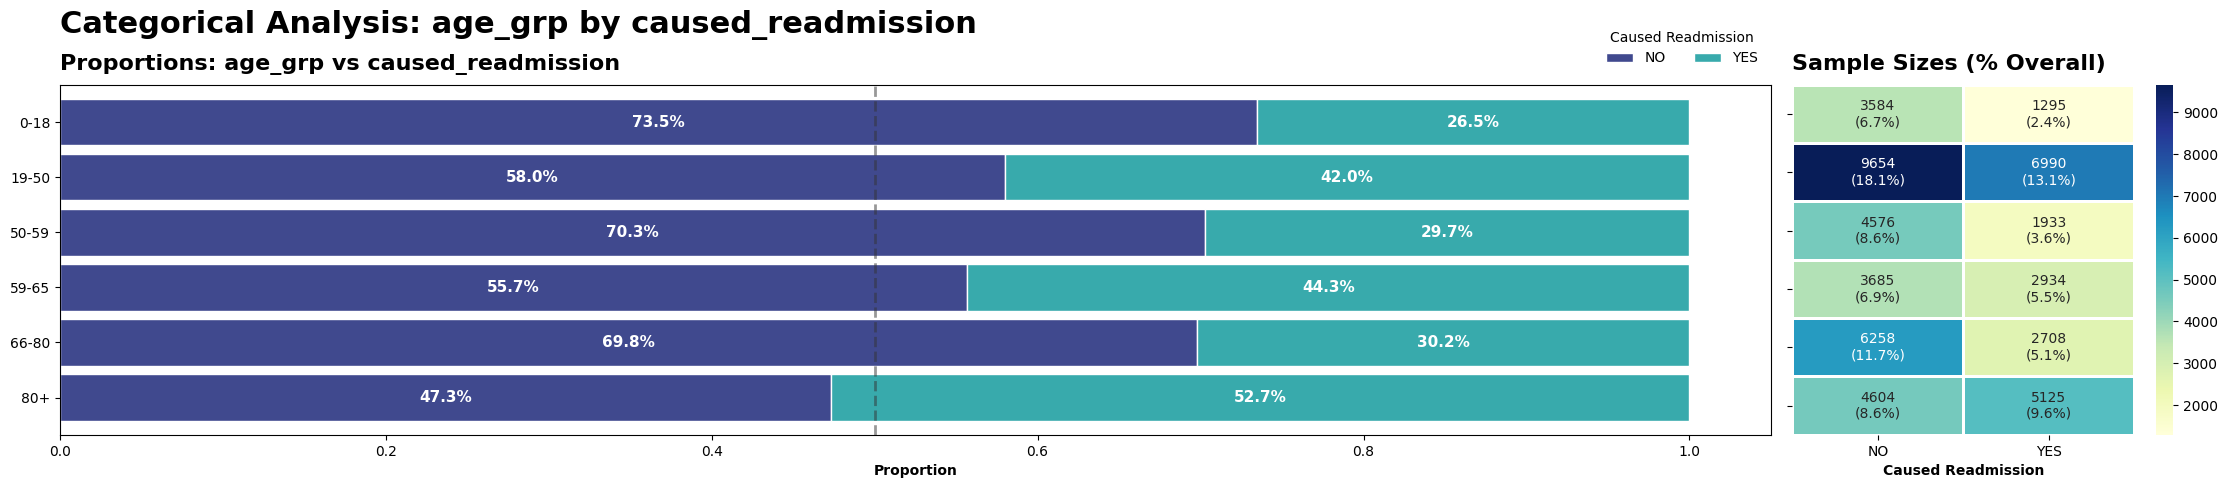

In [205]:
plt.figure(figsize=(24,5))
P.plot_categorical(data.assign(age_grp = age_groups),'age_grp','caused_readmission')

In [206]:
age_groups=age_groups.replace({
    '0-18':'Standard',
    '19-50':'Crit Zone',
    '50-59':'Standard',
    '59-65':'Crit Zone',
    '66-80':'Standard',
    '80+':'Crit Zone'
})

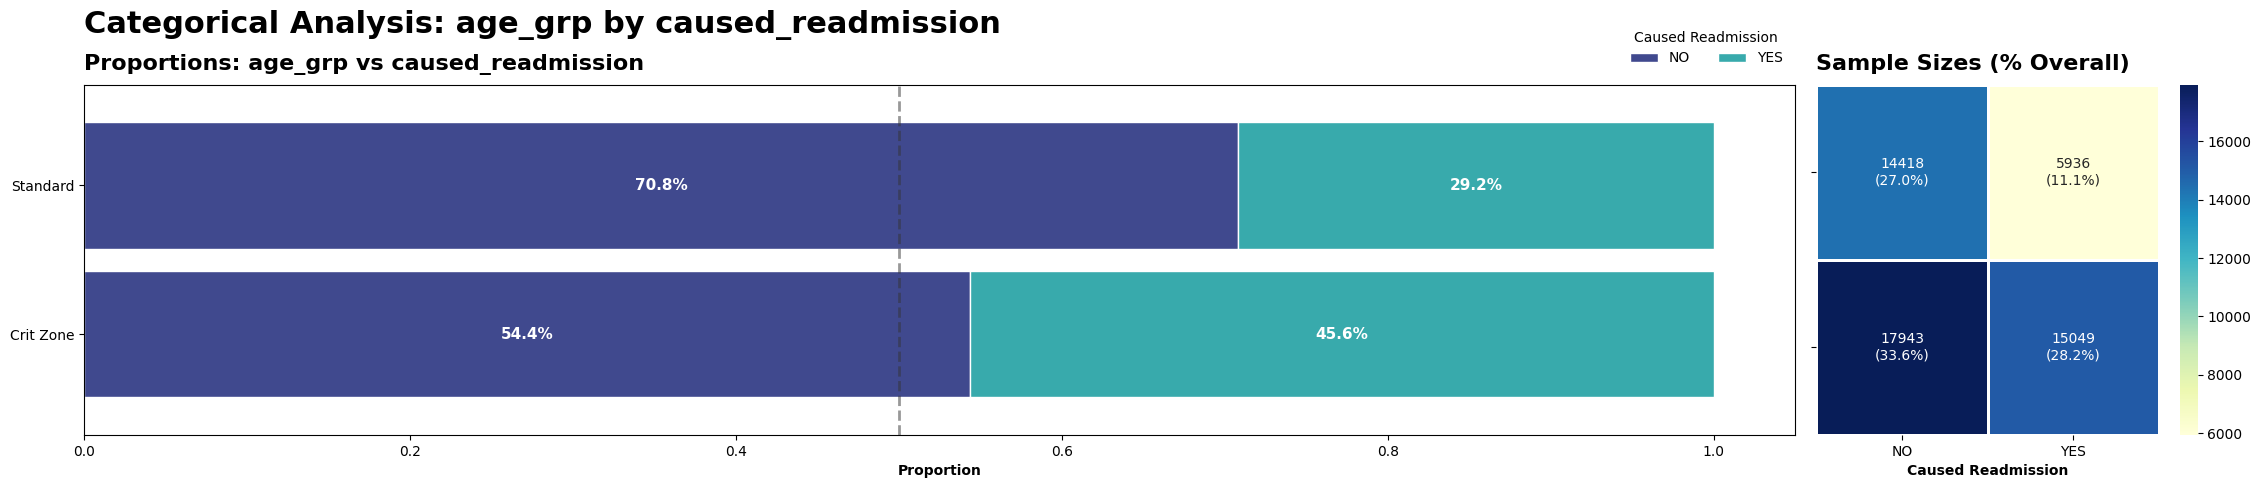

In [207]:
plt.figure(figsize=(24,5))
P.plot_categorical(data.assign(age_grp = age_groups),'age_grp','caused_readmission')

In [208]:
ct = pd.crosstab(age_groups,data['caused_readmission'])
S.test_association(ct)


--- Association Test: age_as_2022 vs caused_readmission ---
1. Verdict:    ✅ SIGNIFICANT Association (p=0.00000)
2. Strength:   Moderate (Cramer's V = 0.164)
3. Balance:    Robust (High N)
------------------------------------------------------------


---
---
- ***By visuals we saw that `there is crit zones in age, groups are 19-50,59-65 and 80+ - in this crit zones, there is more than 50% chance of causing readmission` - by statistical test we can support this observation with moderate strength, but large sample size makes it a reliable find***
---
---

**utilization**

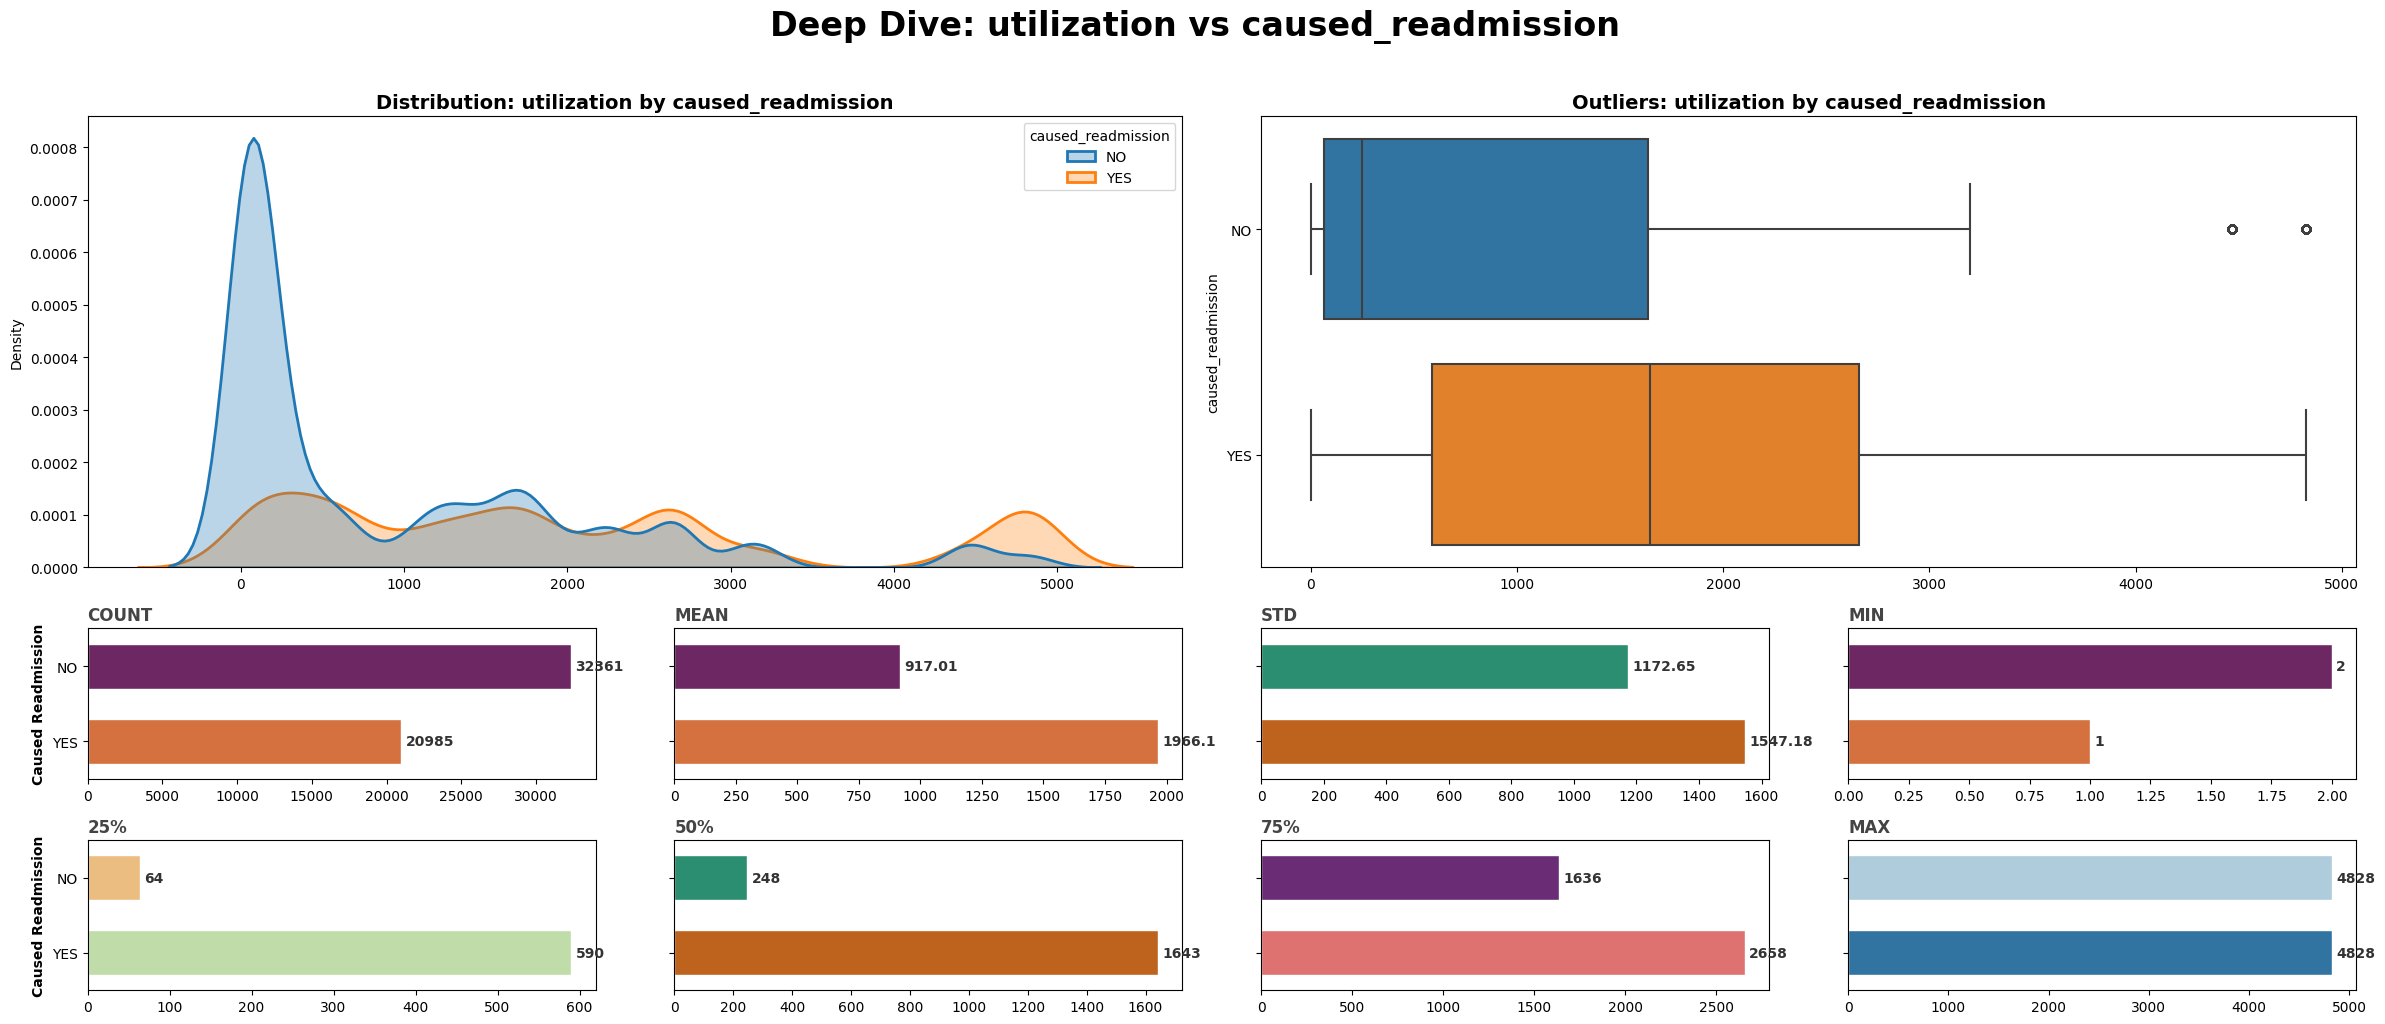

In [209]:
plt.figure(figsize=(24,10))
P.plot_numeric(data,'utilization','caused_readmission')

In [210]:
S.compare_means(data,'caused_readmission','utilization','YES')


--- Comparing 'utilization' by 'caused_readmission' (YES vs Others) ---
1. Verdict:    ✅ SIGNIFICANT difference (p=0.00000)
2. Strength:   Moderate (Cohen's d = 0.787)
3. Balance:    Robust (High N) (n=20985 vs n=32361)
------------------------------------------------------------


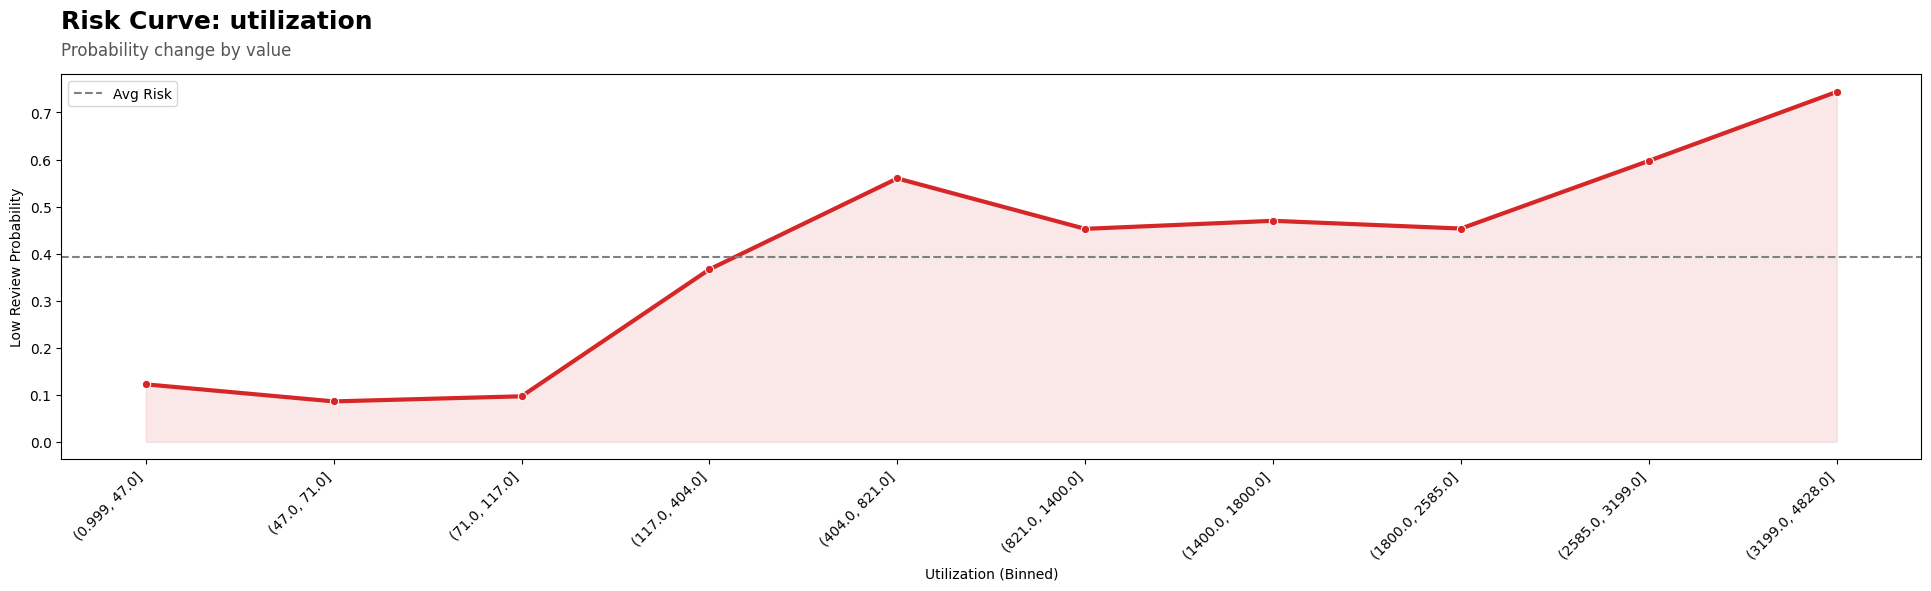

In [211]:
plt.figure(figsize=(24,5))
P.plot_risk_by_bins(data,'utilization','caused_readmission',bins = 10)

In [215]:
utilization_groups = pd.cut(data['utilization'], 
                         bins=[-1, 365,2555,float('inf')], 
                         labels=['1 Year', '<7 Years','7+ years'])

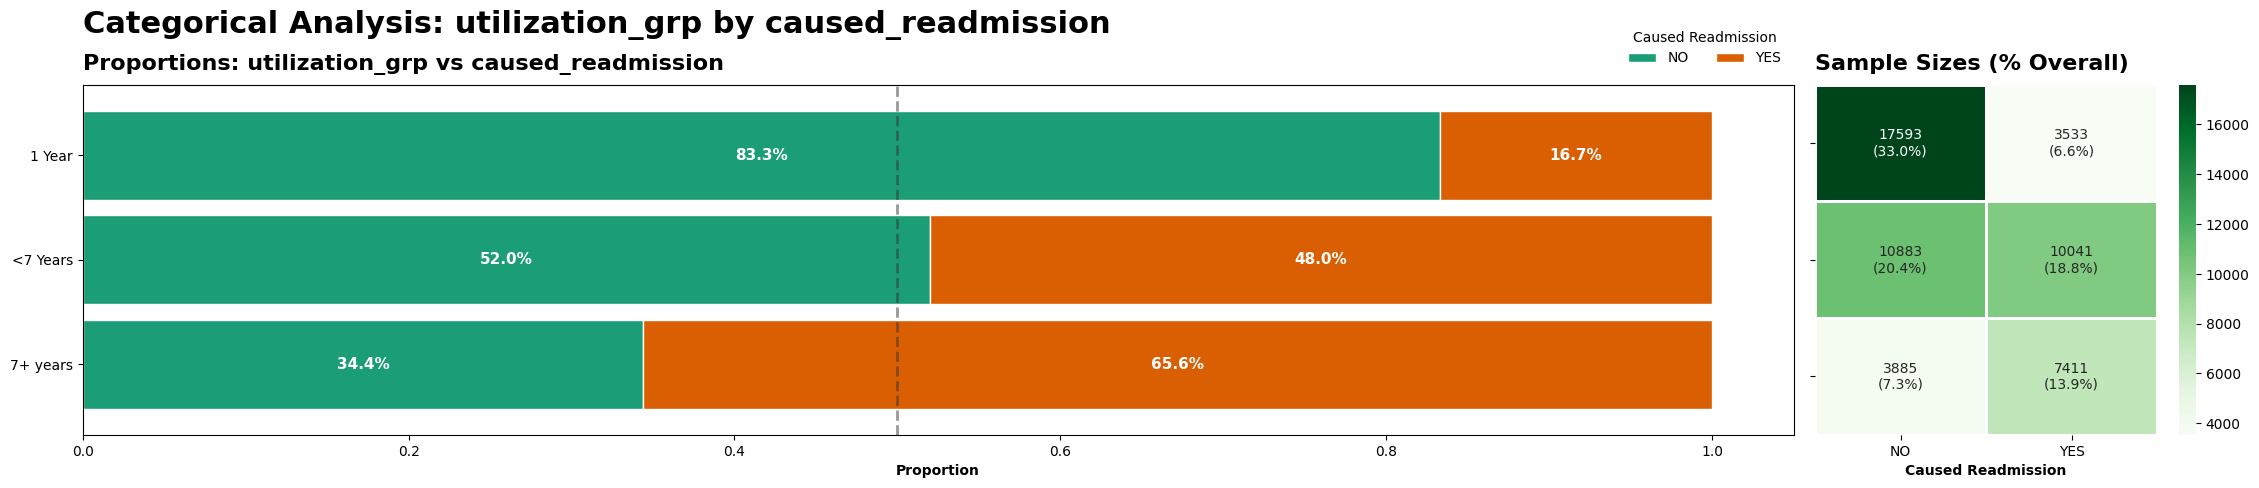

In [217]:
plt.figure(figsize=(24,5))
P.plot_categorical(data.assign(utilization_grp = utilization_groups),'utilization_grp','caused_readmission')

In [218]:
ct = pd.crosstab(utilization_groups,data['caused_readmission'])
S.test_association(ct)


--- Association Test: utilization vs caused_readmission ---
1. Verdict:    ✅ SIGNIFICANT Association (p=0.00000)
2. Strength:   Strong (Cramer's V = 0.398)
3. Balance:    Robust (High N)
------------------------------------------------------------


---
---
- ***By visuals we saw that `utilization can be grouped into 3 sub categories (1 year, <7 year, 7+ years) among them 7+ years have the highest chance of causing readmission - approx 65%, after that <7 years have less caused readmission(~48%), and lowest for the 1 year utilizatoin(~15%)` - by statistical test we can support this observation with strong strength, and large sample size makes it a reliable find***
---
---

**condition_duration**

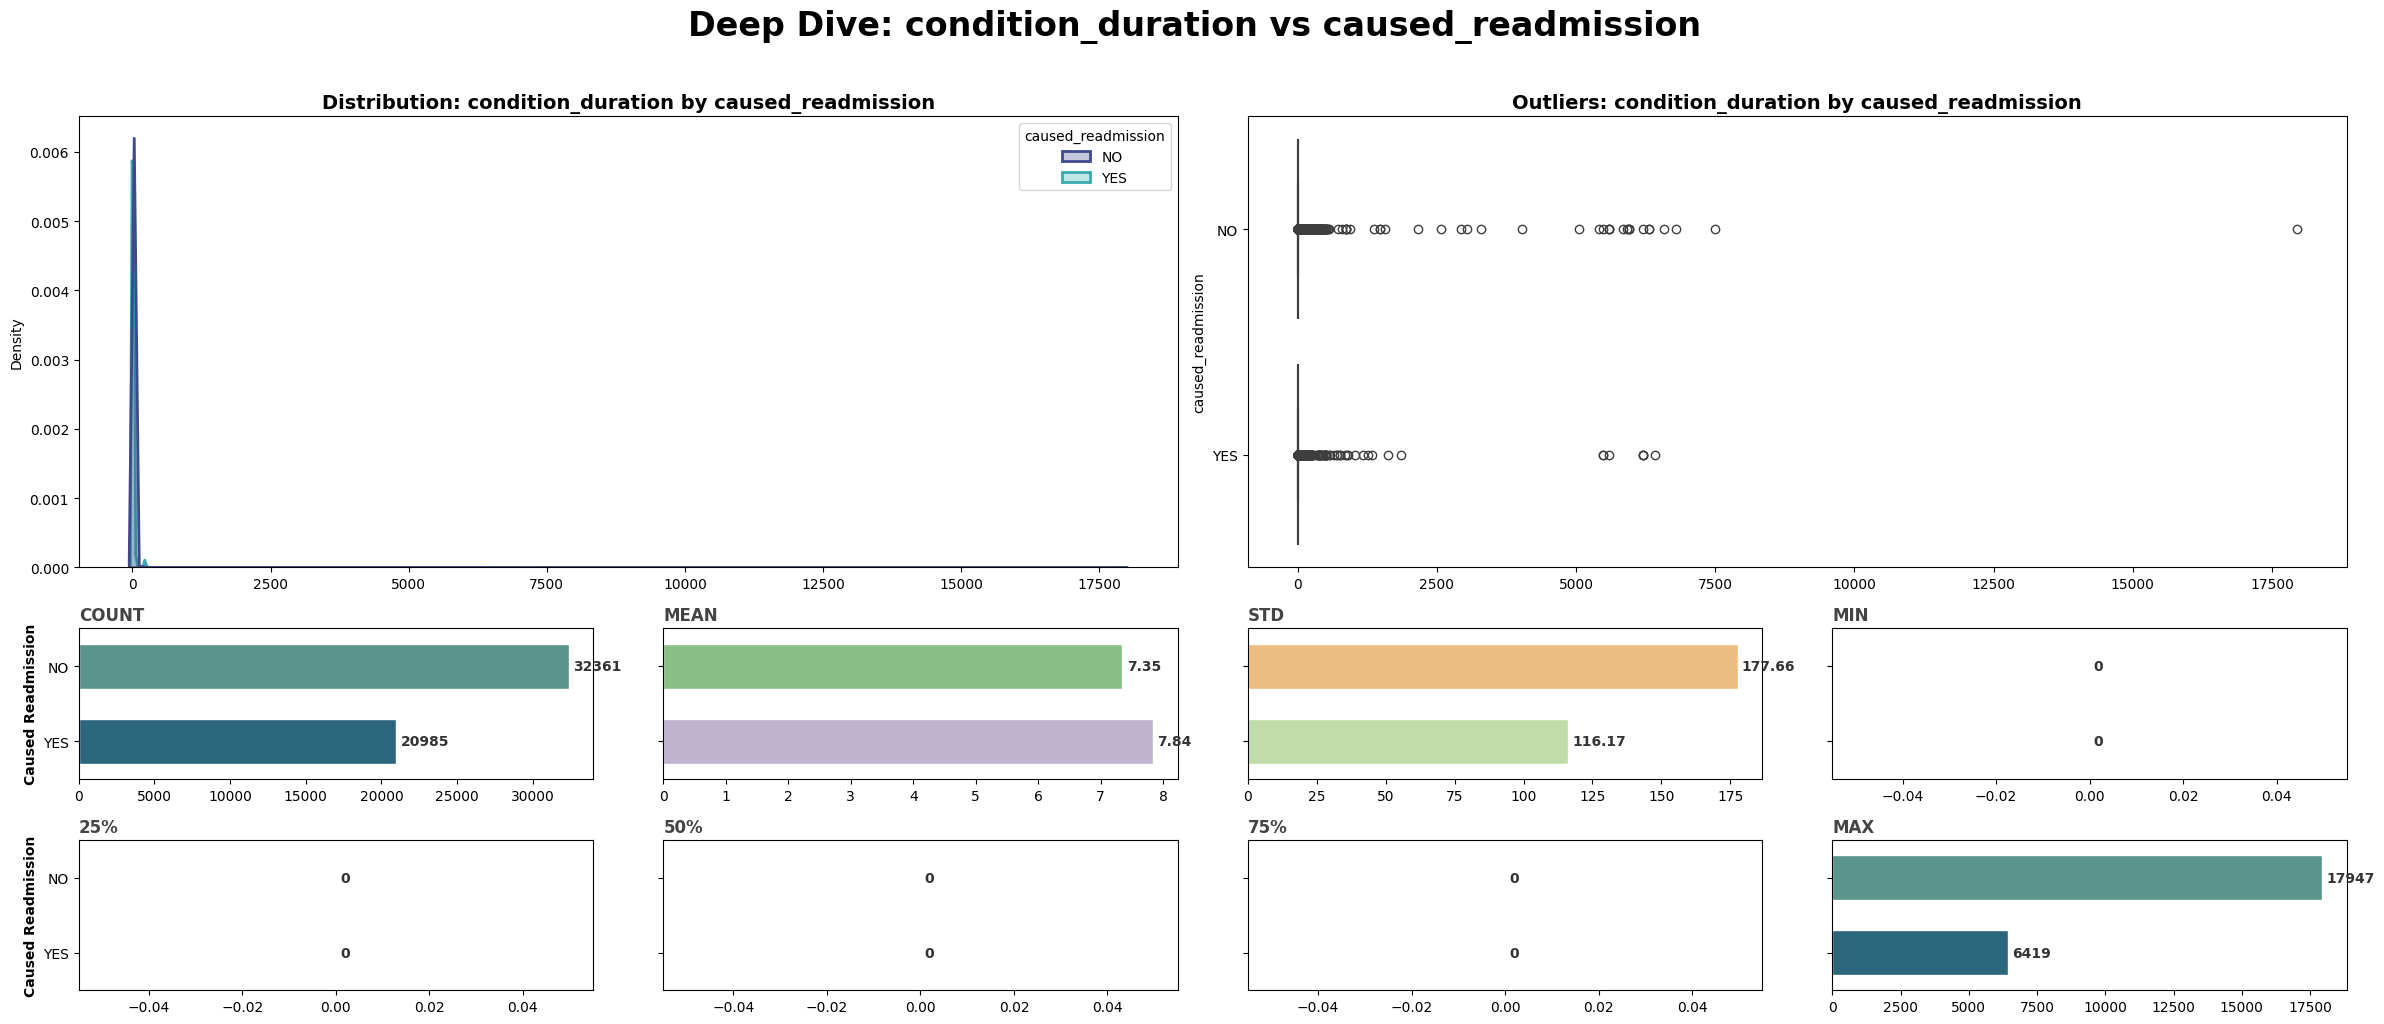

In [219]:
plt.figure(figsize=(24,10))
P.plot_numeric(data,'condition_duration','caused_readmission')

In [220]:
S.compare_means(data,'caused_readmission','condition_duration','YES')


--- Comparing 'condition_duration' by 'caused_readmission' (YES vs Others) ---
1. Verdict:    ❌ NOT Significant (p=0.72407)
2. Strength:   Negligible (Cohen's d = 0.003)
3. Balance:    Robust (High N) (n=20985 vs n=32361)
------------------------------------------------------------


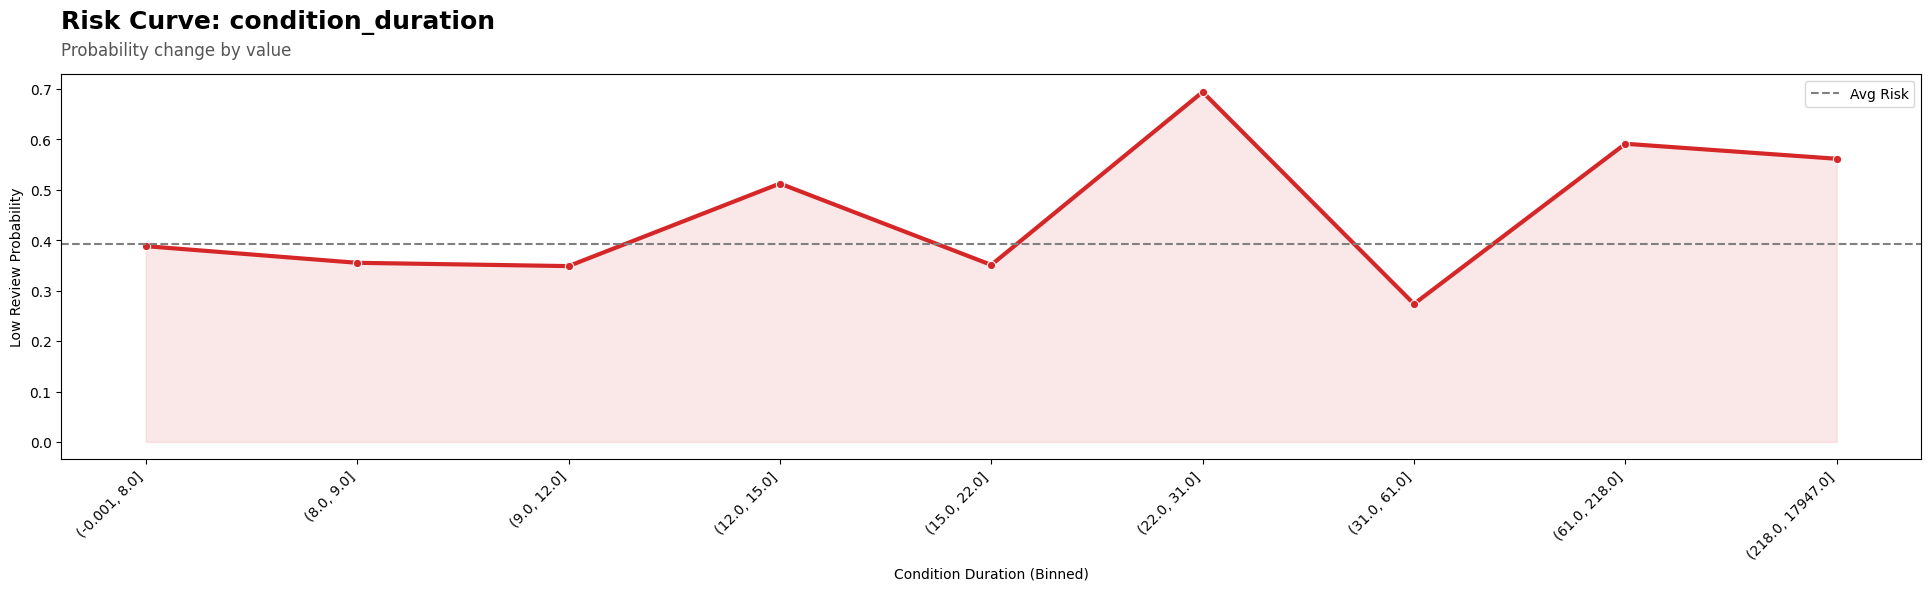

In [224]:
plt.figure(figsize=(24,5))
P.plot_risk_by_bins(data,'condition_duration','caused_readmission',bins = 150)

In [226]:
condition_duration_groups = pd.cut(data['condition_duration'], 
                         bins=[-1, 7, 14,float('inf')], 
                         labels=['1 Week', '2 Week', '2 Week+'])

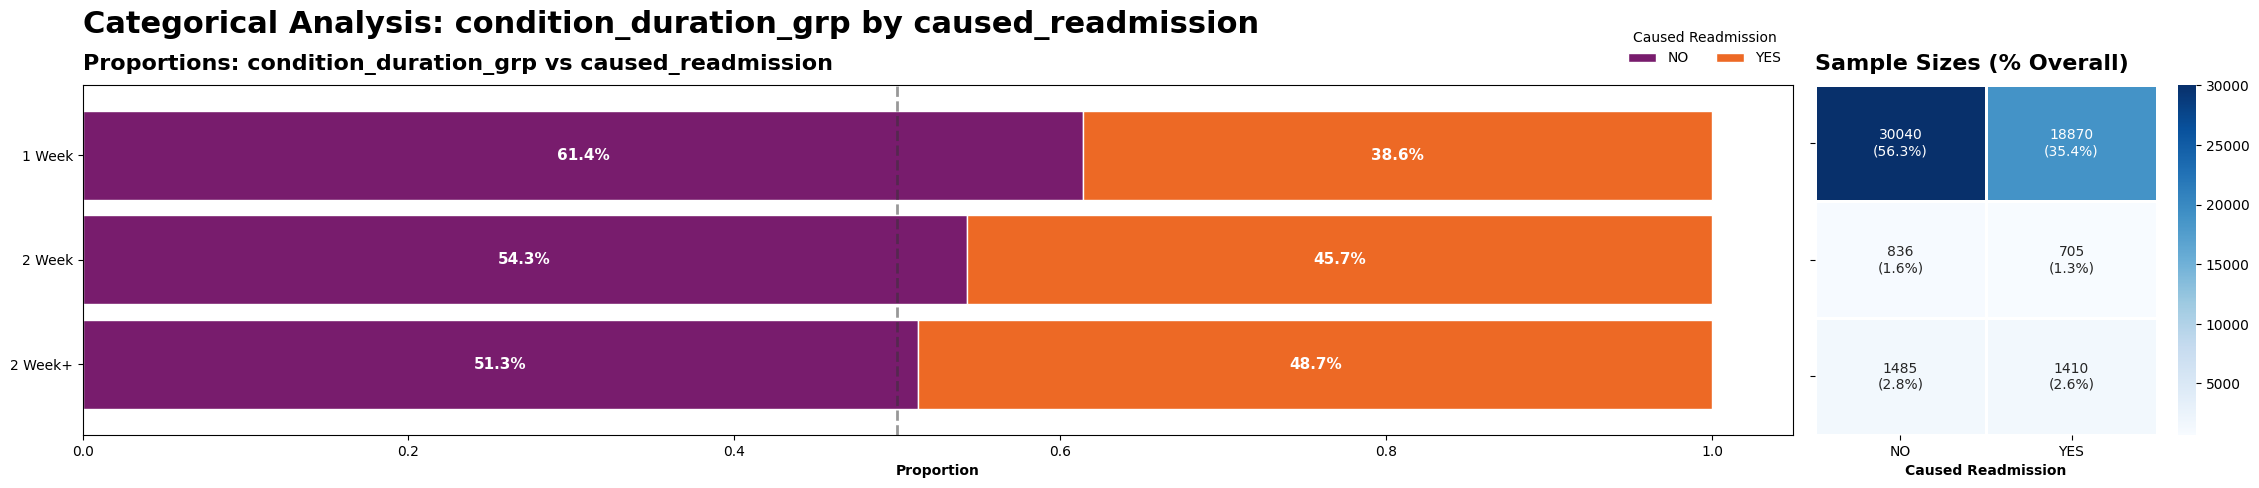

In [227]:
plt.figure(figsize=(24,5))
P.plot_categorical(data.assign(condition_duration_grp = condition_duration_groups),'condition_duration_grp','caused_readmission')

In [228]:
ct = pd.crosstab(condition_duration_groups,data['caused_readmission'])
S.test_association(ct)


--- Association Test: condition_duration vs caused_readmission ---
1. Verdict:    ✅ SIGNIFICANT Association (p=0.00000)
2. Strength:   Weak (Cramer's V = 0.052)
3. Balance:    Robust (High N)
------------------------------------------------------------


---
---
- ***By visuals we saw that `condition duration more than 2 week have more chance in causing readmission(~48%), compared to other less than 2 weeks` - by statistical test we can support this observation with weak strength, but large sample size makes it a reliable find***
---
---

**careplan_duration**

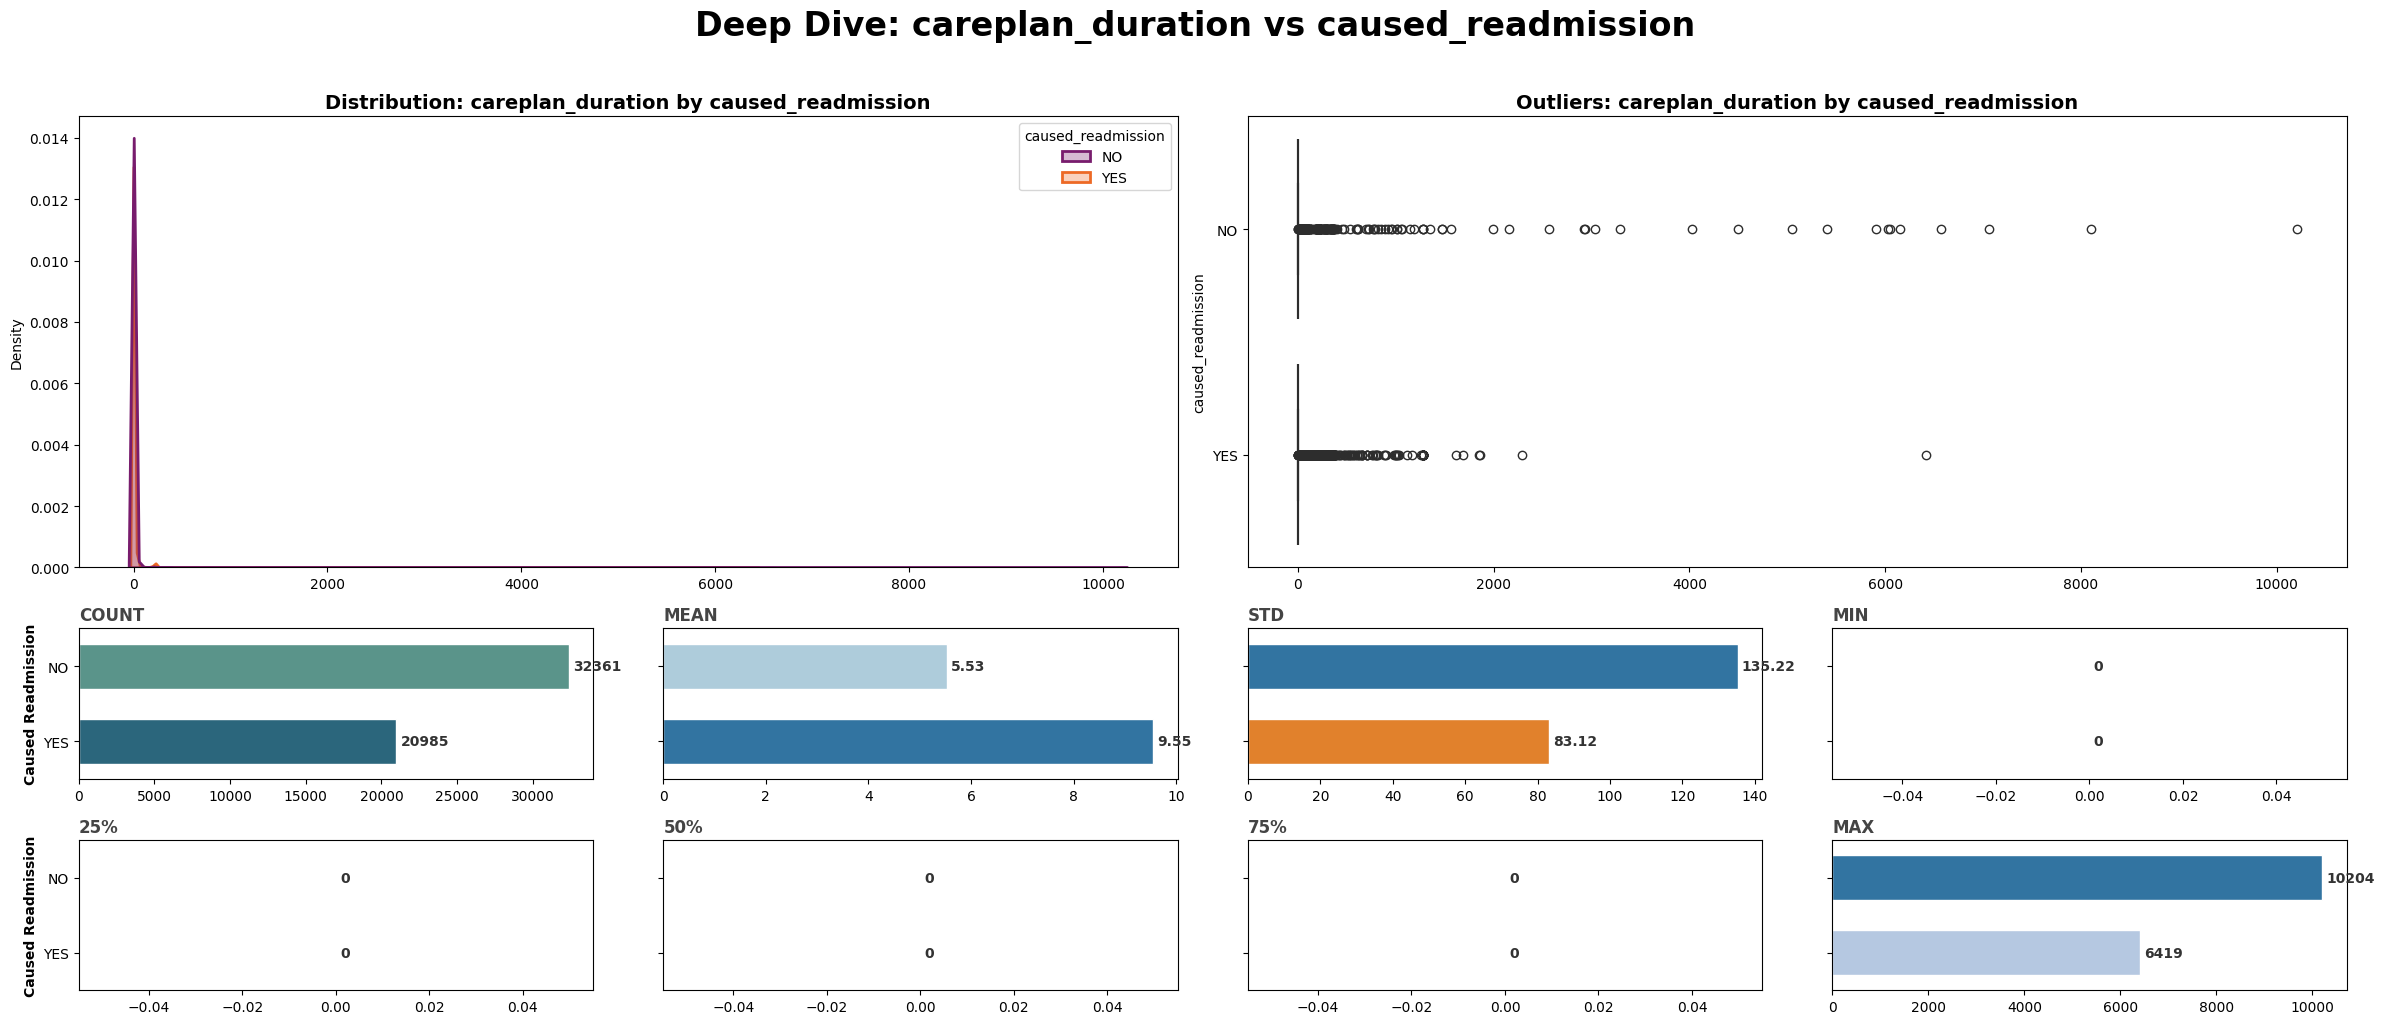

In [229]:
plt.figure(figsize=(24,10))
P.plot_numeric(data,'careplan_duration','caused_readmission')

In [230]:
S.compare_means(data,'caused_readmission','careplan_duration','YES')


--- Comparing 'careplan_duration' by 'caused_readmission' (YES vs Others) ---
1. Verdict:    ✅ SIGNIFICANT difference (p=0.00002)
2. Strength:   Negligible (Cohen's d = 0.034)
3. Balance:    Robust (High N) (n=20985 vs n=32361)
------------------------------------------------------------


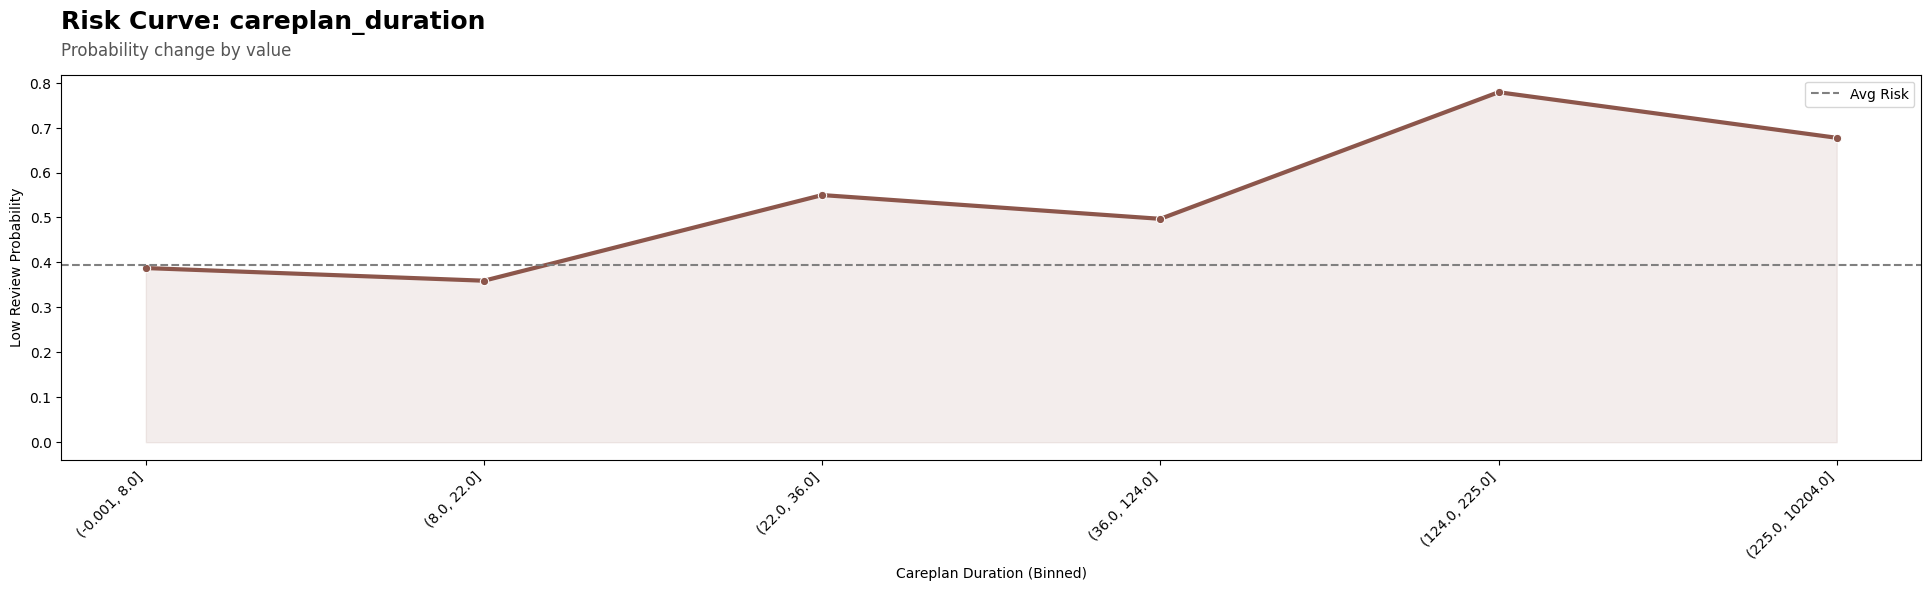

In [232]:
plt.figure(figsize=(24,5))
P.plot_risk_by_bins(data,'careplan_duration','caused_readmission',bins = 150)

In [234]:
careplan_duration_groups = pd.cut(data['careplan_duration'], 
                         bins=[-1, 21, 120,float('inf')], 
                         labels=['3 Weeks', '4 Months','4 Months+'])

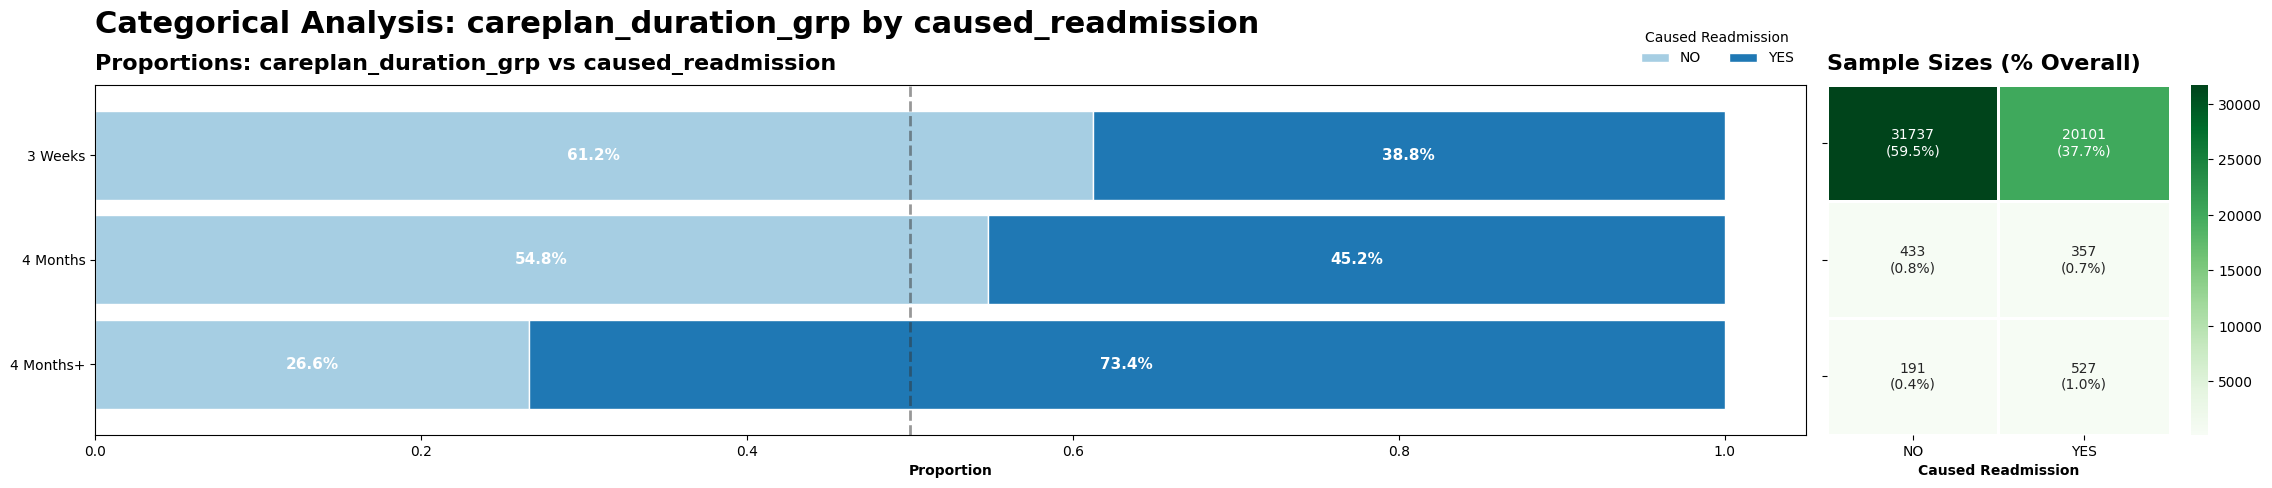

In [235]:
plt.figure(figsize=(24,5))
P.plot_categorical(data.assign(careplan_duration_grp = careplan_duration_groups),'careplan_duration_grp','caused_readmission')

In [236]:
ct = pd.crosstab(careplan_duration_groups,data['caused_readmission'])
S.test_association(ct)


--- Association Test: careplan_duration vs caused_readmission ---
1. Verdict:    ✅ SIGNIFICANT Association (p=0.00000)
2. Strength:   Weak (Cramer's V = 0.083)
3. Balance:    High Imbalance (Caution)
------------------------------------------------------------


---
---
- ***By visuals we saw that `careplan duration more than 4 months is showing high percentage in causing readmission` - by statistical test we can support this observation with weak strength, but we have to be cautious because of high imbalance in class(less than 1.5% in 4+ category)***
---
---

**coverage_ratio**

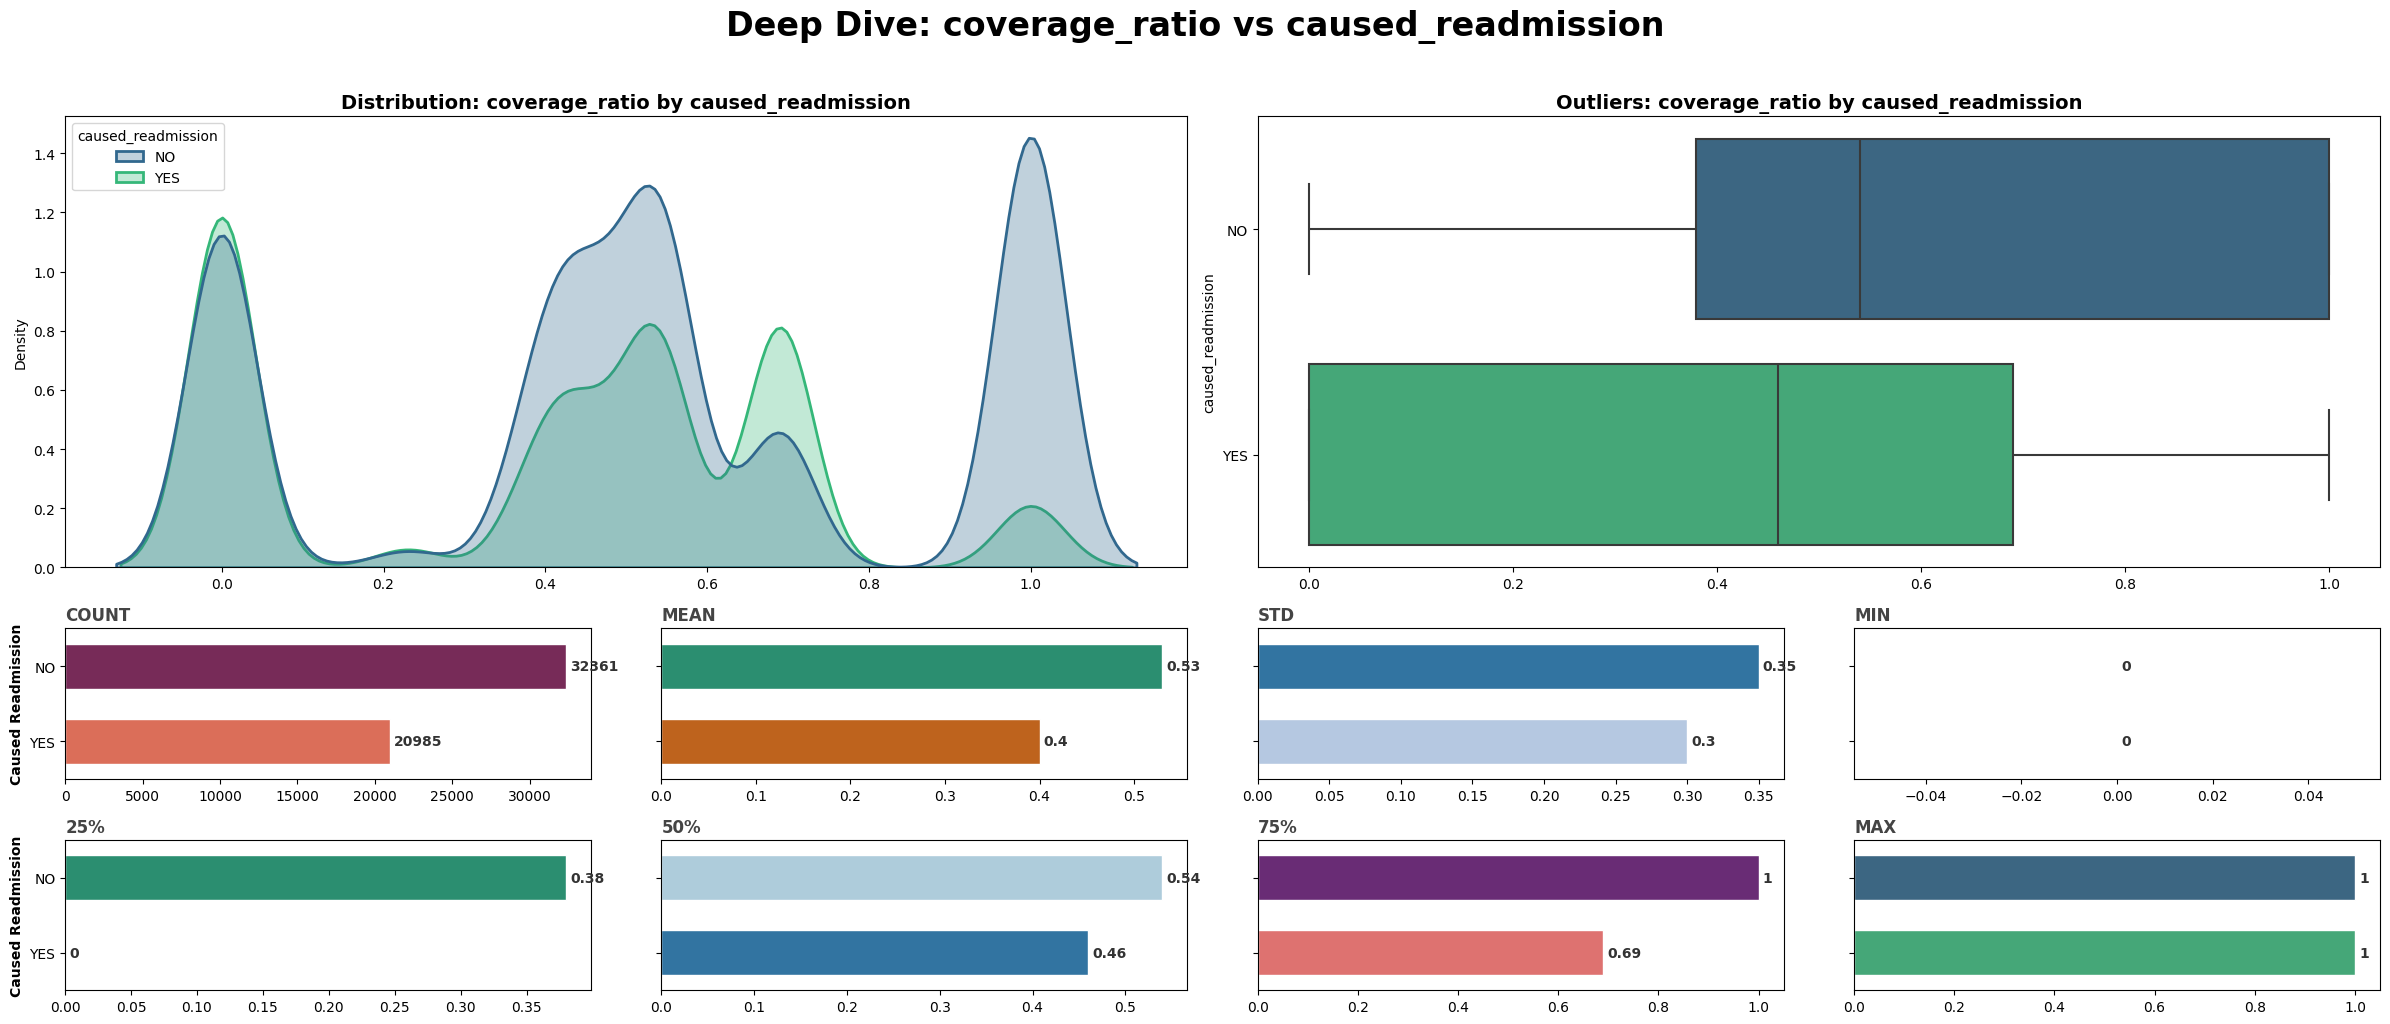

In [237]:
plt.figure(figsize=(24,10))
P.plot_numeric(data,'coverage_ratio','caused_readmission')

In [238]:
S.compare_means(data,'caused_readmission','coverage_ratio','YES')


--- Comparing 'coverage_ratio' by 'caused_readmission' (YES vs Others) ---
1. Verdict:    ✅ SIGNIFICANT difference (p=0.00000)
2. Strength:   Small/Weak (Cohen's d = -0.405)
3. Balance:    Robust (High N) (n=20985 vs n=32361)
------------------------------------------------------------


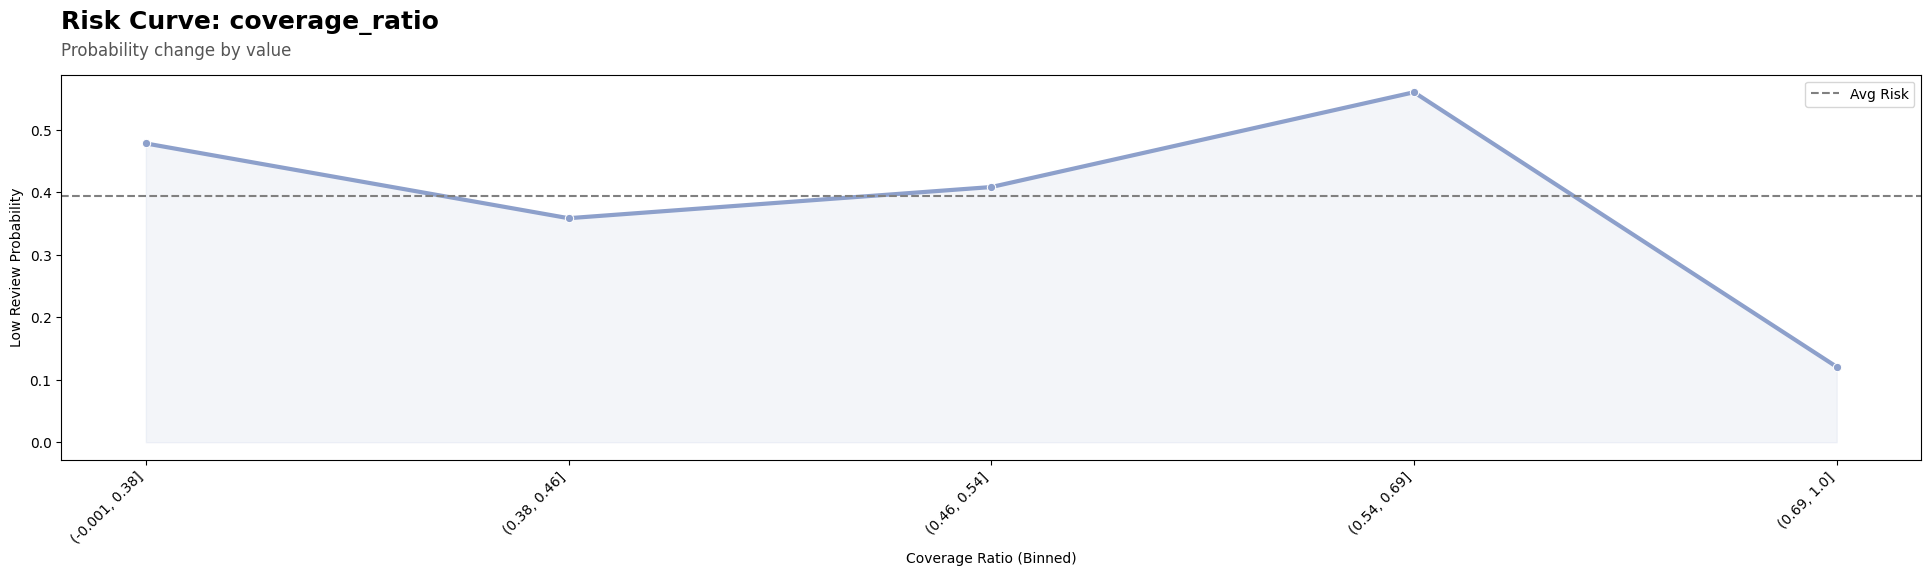

In [239]:
plt.figure(figsize=(24,5))
P.plot_risk_by_bins(data,'coverage_ratio','caused_readmission',bins = 10)

In [240]:
ratio_groups = pd.cut(data['coverage_ratio'], 
                         bins=[-1,.7,1], 
                         labels=['Below 70%','Above 70%'])

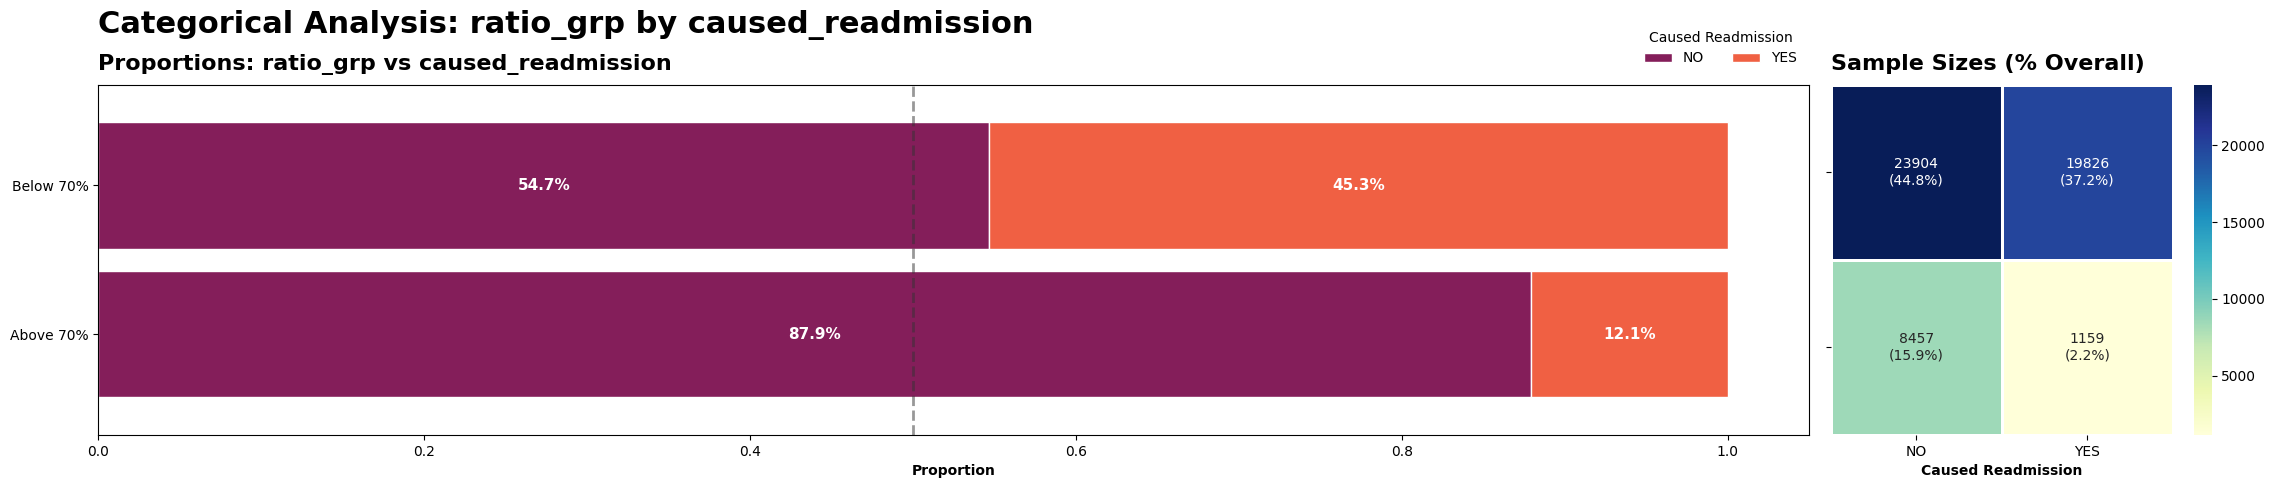

In [241]:
plt.figure(figsize=(24,5))
P.plot_categorical(data.assign(ratio_grp = ratio_groups),'ratio_grp','caused_readmission')

In [242]:
ct = pd.crosstab(ratio_groups,data['caused_readmission'])
S.test_association(ct)


--- Association Test: coverage_ratio vs caused_readmission ---
1. Verdict:    ✅ SIGNIFICANT Association (p=0.00000)
2. Strength:   Moderate (Cramer's V = 0.262)
3. Balance:    Robust (High N)
------------------------------------------------------------


---
---
- ***By visuals we saw that `payer coverage more than 70% very low chance of causing readmission(~12%) compared to coverage less than 70%` - by statistical test we can support this observation with moderate strength, but large sample size makes it a reliable find***
---
---

**medication_duration**

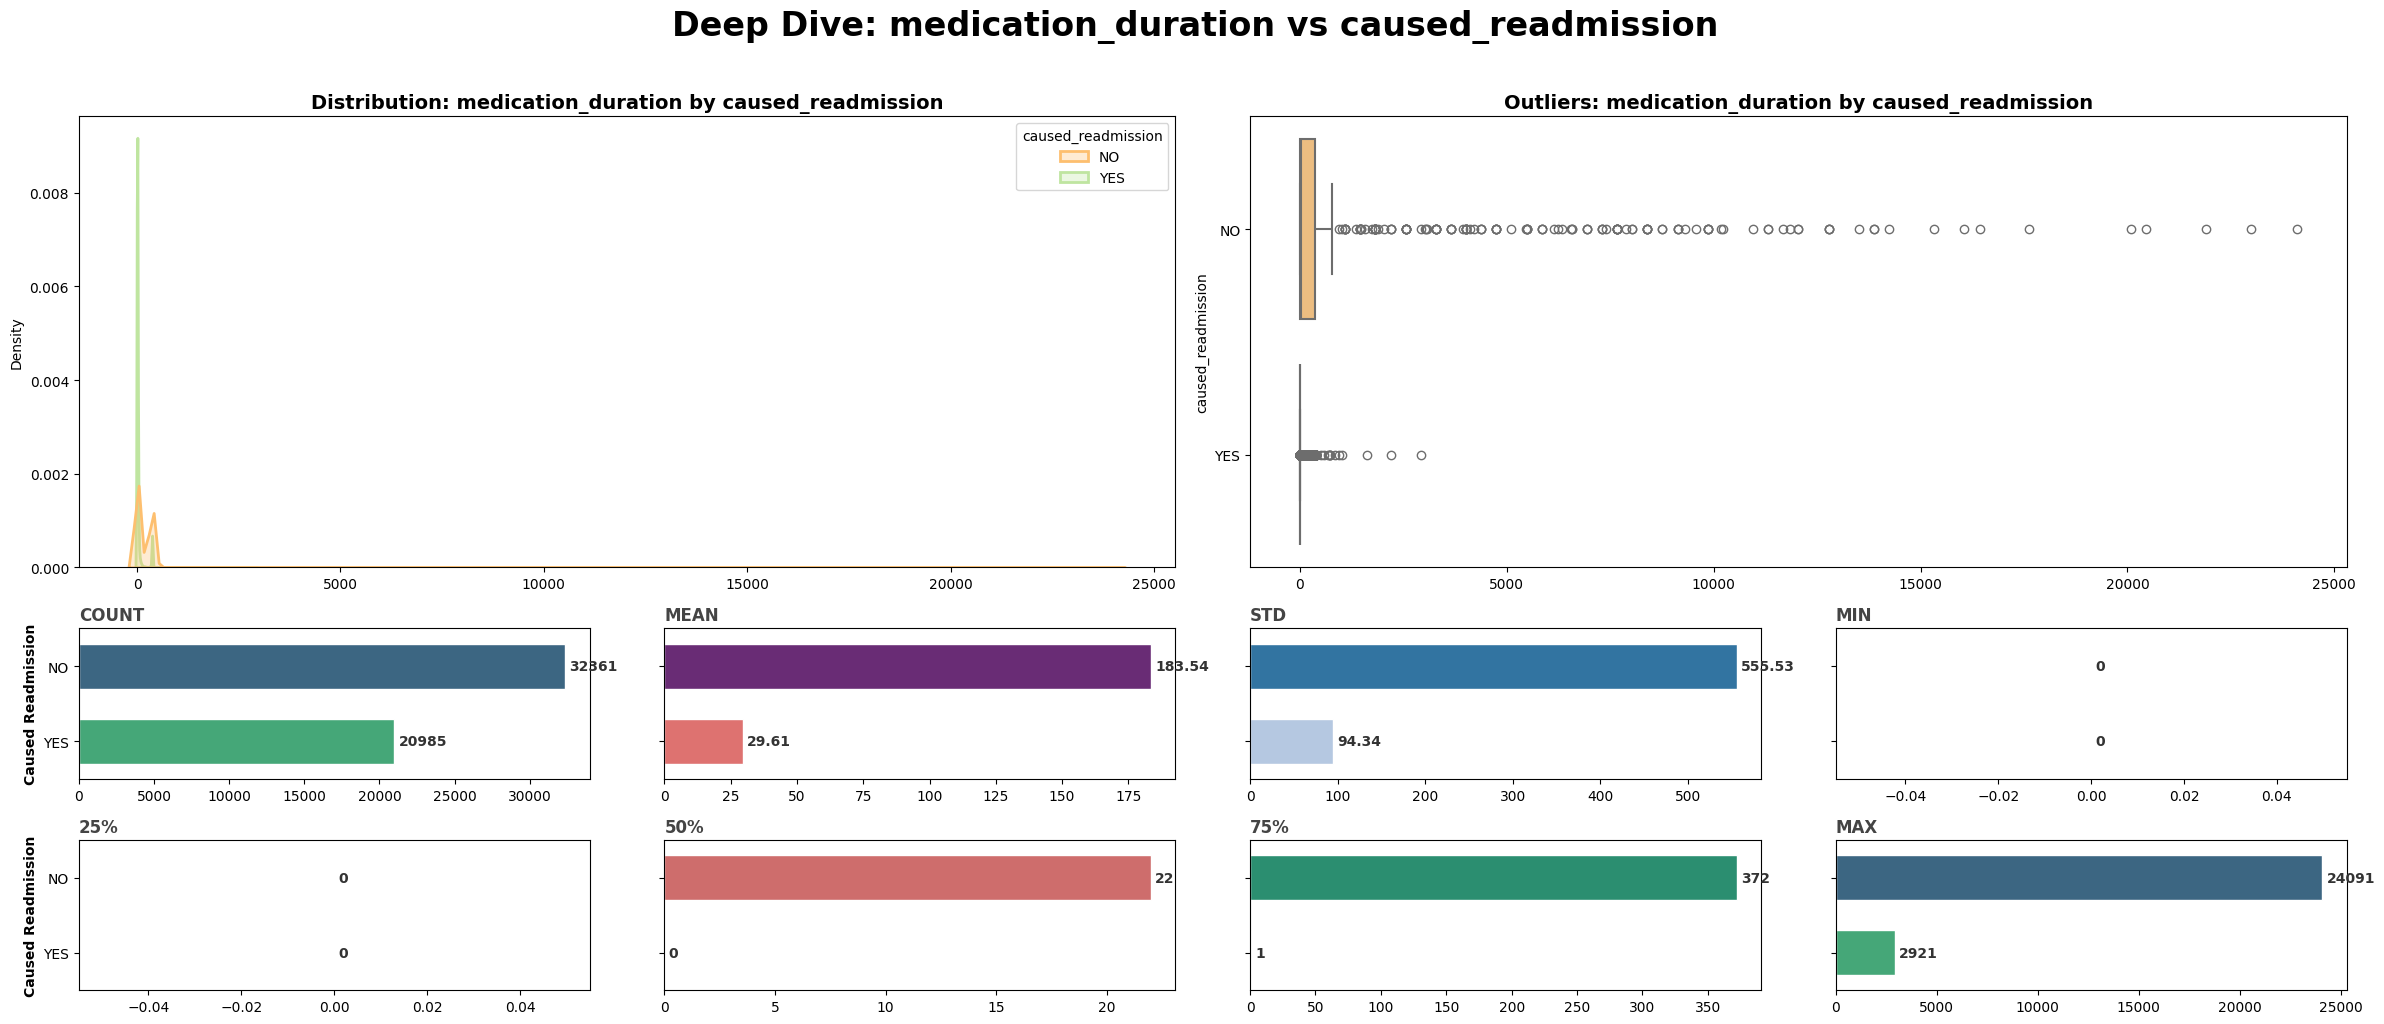

In [243]:
plt.figure(figsize=(24,10))
P.plot_numeric(data,'medication_duration','caused_readmission')

In [244]:
S.compare_means(data,'caused_readmission','medication_duration','YES')


--- Comparing 'medication_duration' by 'caused_readmission' (YES vs Others) ---
1. Verdict:    ✅ SIGNIFICANT difference (p=0.00000)
2. Strength:   Small/Weak (Cohen's d = -0.352)
3. Balance:    Robust (High N) (n=20985 vs n=32361)
------------------------------------------------------------


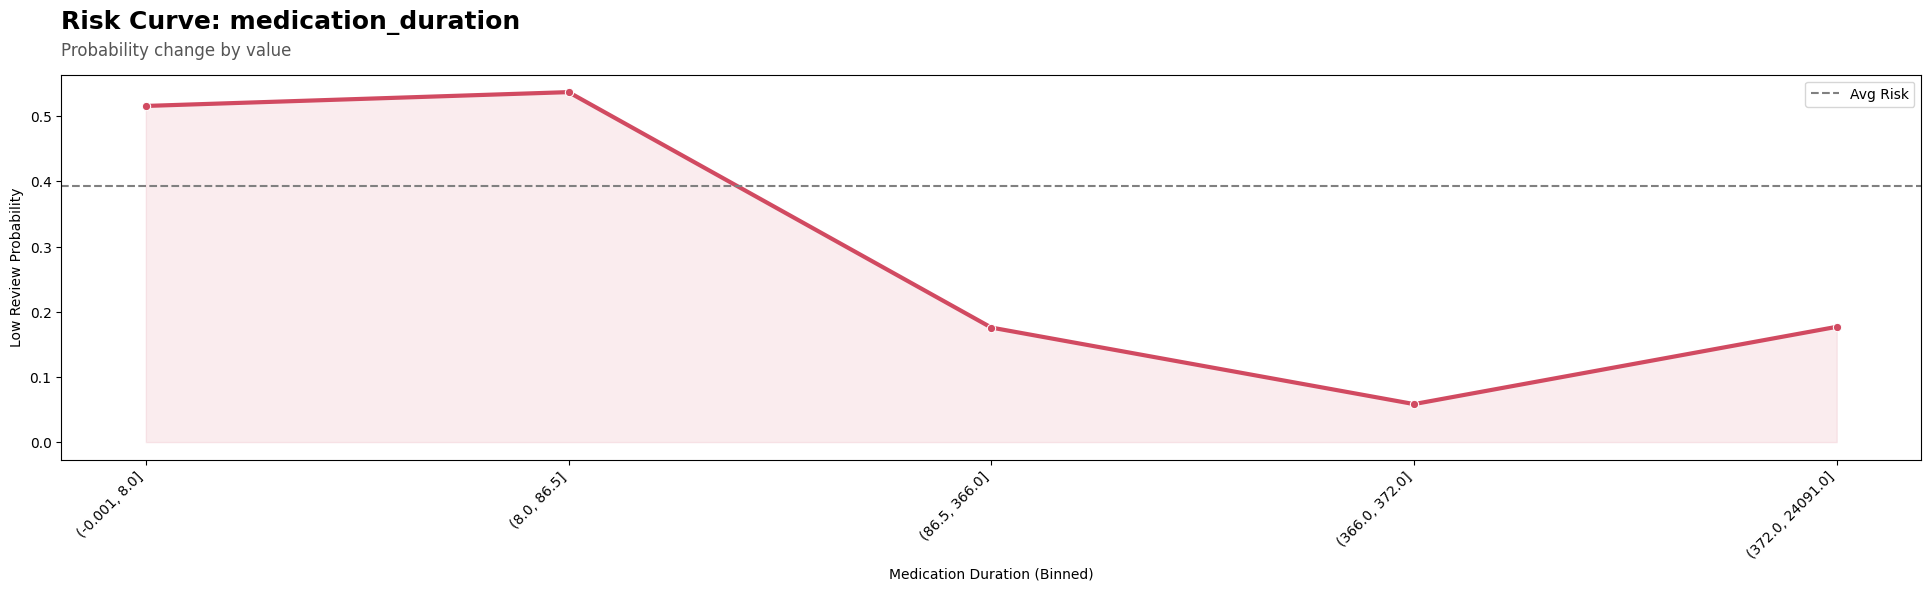

In [245]:
plt.figure(figsize=(24,5))
P.plot_risk_by_bins(data,'medication_duration','caused_readmission',bins = 10)

In [248]:
duration_groups = pd.cut(data['medication_duration'], 
                         bins=[-1, 90, float('inf')], 
                         labels=['Less than 3 Months', 'More than 3 Months'])

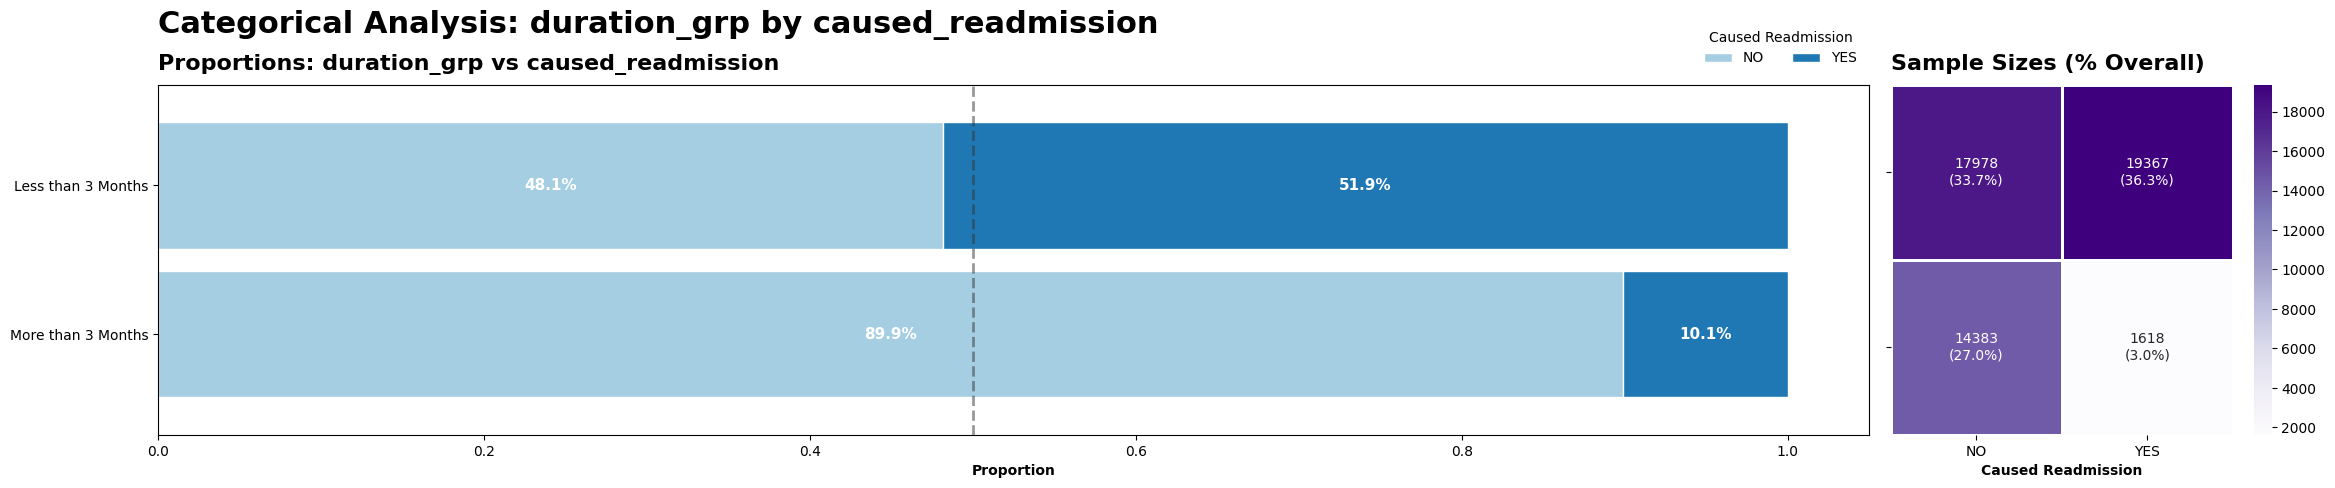

In [249]:
plt.figure(figsize=(24,5))
P.plot_categorical(data.assign(duration_grp = duration_groups),'duration_grp','caused_readmission')

In [250]:
ct = pd.crosstab(duration_groups,data['caused_readmission'])
S.test_association(ct)


--- Association Test: medication_duration vs caused_readmission ---
1. Verdict:    ✅ SIGNIFICANT Association (p=0.00000)
2. Strength:   Strong (Cramer's V = 0.392)
3. Balance:    Robust (High N)
------------------------------------------------------------


---
---
- ***By visuals we saw that `medication duration more than 3 months have approximately 90% chance of not causing any readmission` - by statistical test we can support this observation with strong strength, and large sample size makes it a reliable find***
---
---